# 目的
テキスト特徴量を諸々追加する

In [37]:
# path setting
EXP_NAME = "e107-s-sl-g-p-optuna"
MODEL_NAME = "lightgbm"
COMPETITION_NAME = "automated_essay_scoring"

DATA_PATH = "data"
DATASET_NAME = f"{EXP_NAME}-{MODEL_NAME.split('/')[-1]}"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"

N_FOLD = 3

# experiment parameter
DEBUG = True
TRAINING = True
UPLOAD_DATA_TO_S3 = True
UPLOAD_DATA_TO_KAGGLE = True
WANDB = True

# model parameter
SEED = 42
EPOCH = 4
LR = 2e-05

In [38]:
def validate_dataset_name(dataset_name: str) -> None:
    if len(dataset_name) < 6 or len(dataset_name) > 50:
        raise Exception(
            f"データセットの文字列は6~50文字にしてください。現在{len(DATASET_NAME)}文字"
        )
    if "_" in dataset_name:
        raise Exception("datasetの名称に_の使用は禁止です")


validate_dataset_name(DATASET_NAME)

In [39]:
!python --version

Python 3.11.7


In [40]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return f"../../{base_path}"
    elif cwd.startswith("/Users"):
        print("Local Mac!")
        return f"../../{base_path}"
    else:
        raise Exception("Unknown environment")


DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)

/notebooks/automated_essay_scoring/automated_essay_scoring/exp
Jupyter Lab!
../../data
/notebooks/automated_essay_scoring/automated_essay_scoring/exp
Jupyter Lab!
../../trained_models/e107-s-sl-g-p-optuna


In [41]:
import os

os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)

# import

In [42]:
%pip install -qq polars==0.20.23
%pip install -qq transformers==4.40.1
%pip install -qq datasets==2.19.0
%pip install -qq evaluate==0.4.2
%pip install -qq seqeval==1.2.2
%pip install -qq accelerate==0.30.0
%pip install -qq python-dotenv==1.0.1
%pip install -qq wandb==0.16.6

# formatter
%pip install -qq black isort

%pip install -qq kaggle

%pip install optuna==3.6.1
%pip install optuna_integration==3.6.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [43]:
!pip install lightgbm==4.4.0

In [44]:
import random
import os
import numpy as np
import scipy as sp
import torch
import json
import re
import spacy
import polars as pl
# import lightgbm as lgb
import optuna.integration.lightgbm as lgb
from functools import partial
from lightgbm import log_evaluation, early_stopping
import wandb
from sklearn.metrics import cohen_kappa_score
import pickle
from wandb.lightgbm import wandb_callback, log_summary

In [45]:
# Seed the same seed to all
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [46]:
from dotenv import load_dotenv

load_dotenv(f"{DATA_PATH}/.env")

True

In [47]:
# with open(f"{DATA_PATH}/essay_id_spelling_errors_cnt.json", "r") as f:
with open(f"{DATA_PATH}/essay_id_spelling_errors_cnt_pyspell.json", "r") as f:
    essay_id_spelling_errors_cnt = json.load(f)

# Wandb

In [48]:
if WANDB:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    wandb.init(project="automated_essay_scoring", name=EXP_NAME)
    REPORT_TO = "wandb"
else:
    REPORT_TO = "none"

REPORT_TO

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


'wandb'

# Data Import

In [49]:
train = pl.read_csv(f"{DATA_PATH}/train.csv")

In [50]:
train.head()

essay_id,full_text,score
str,str,i64
"""000d118""","""Many people have car where the…",3
"""000fe60""","""I am a scientist at NASA that …",3
"""001ab80""","""People always wish they had th…",4
"""001bdc0""","""We all heard about Venus, the …",4
"""002ba53""","""Dear, State Senator This is a…",3


# Add Fold

In [51]:
with open(f"{DATA_PATH}/essay_id_fold_by_s_sl_g_p_only_train_dict.json") as f:
    essay_id_fold_only_train = json.load(f)

In [52]:
train = train.with_columns(
    pl.col("essay_id")
    .replace(essay_id_fold_only_train, return_dtype=pl.Int64)
    .alias("fold")
)

# Add Predict

In [53]:
oof_e053 = pl.read_csv(f"{DATA_PATH}/e053-cv-w-oof/oof.csv").rename(
    {"valid_pred": "e053_xsmall_oof"}
)
train = train.join(oof_e053, on="essay_id", how="left")

In [54]:
oof_e054 = pl.read_csv(f"{DATA_PATH}/e054-cv-w-oof/oof.csv").rename(
    {"valid_pred": "e054_small_oof"}
)
train = train.join(oof_e054, on="essay_id", how="left")

In [55]:
oof_e055 = pl.read_csv(f"{DATA_PATH}/e055-cv-w-oof/oof.csv").rename(
    {"valid_pred": "e055_base_oof"}
)
train = train.join(oof_e055, on="essay_id", how="left")

In [56]:
oof_e056 = pl.read_csv(f"{DATA_PATH}/e056-cv-w-oof/oof.csv").rename(
    {"valid_pred": "e056_large_oof"}
)
train = train.join(oof_e056, on="essay_id", how="left")

# Feature Engineering

In [57]:
!pip install textstat==0.7.3

In [58]:
import textstat

In [59]:
def get_text_length() -> pl.Expr:
    return pl.col("full_text").str.len_chars().alias("text_length")


def get_word_length() -> pl.Expr:
    return (
        pl.col("full_text")
        .map_elements(lambda x: len(x.split()), return_dtype=pl.Int64)
        .alias("word_length")
    )


def count_spelling_errors() -> pl.Expr:
    return (
        pl.col("essay_id")
        .replace(essay_id_spelling_errors_cnt, return_dtype=pl.Int64)
        .alias("spelling_errors_cnt")
    )


def rate_spelling_errors_per_word() -> pl.Expr:
    return (pl.col("spelling_errors_cnt") / pl.col("word_length")).alias(
        "rate_spelling_errors_per_word"
    )


train = train.with_columns(
    get_text_length(), get_word_length(), count_spelling_errors()
).with_columns(rate_spelling_errors_per_word())

train.head()

essay_id,full_text,score,fold,e053_xsmall_oof,e054_small_oof,e055_base_oof,e056_large_oof,text_length,word_length,spelling_errors_cnt,rate_spelling_errors_per_word
str,str,i64,i64,f64,f64,f64,f64,u32,i64,i64,f64
"""000d118""","""Many people have car where the…",3,0,2.59375,2.4804688,2.4941406,2.3769531,2677,498,22,0.044177
"""000fe60""","""I am a scientist at NASA that …",3,0,2.5761719,2.2910156,2.3007812,2.7050781,1669,332,5,0.01506
"""001ab80""","""People always wish they had th…",4,1,4.4882812,4.1523438,4.53125,4.4921875,3077,550,7,0.012727
"""001bdc0""","""We all heard about Venus, the …",4,0,3.4960938,3.3242188,3.0800781,3.2382812,2701,451,6,0.013304
"""002ba53""","""Dear, State Senator This is a…",3,2,2.8261719,2.9257812,3.0273438,2.7851562,2208,373,10,0.02681


In [60]:
import pandas as pd


def textstat_features(text):
    features = {}
    features["flesch_reading_ease"] = textstat.flesch_reading_ease(text)
    features["flesch_kincaid_grade"] = textstat.flesch_kincaid_grade(text)
    features["smog_index"] = textstat.smog_index(text)
    features["coleman_liau_index"] = textstat.coleman_liau_index(text)
    features["automated_readability_index"] = textstat.automated_readability_index(text)
    features["dale_chall_readability_score"] = textstat.dale_chall_readability_score(
        text
    )
    features["difficult_words"] = textstat.difficult_words(text)
    features["linsear_write_formula"] = textstat.linsear_write_formula(text)
    features["gunning_fog"] = textstat.gunning_fog(text)
    features["text_standard"] = textstat.text_standard(text, float_output=True)
    features["spache_readability"] = textstat.spache_readability(text)
    features["mcalpine_eflaw"] = textstat.mcalpine_eflaw(text)
    features["reading_time"] = textstat.reading_time(text)
    features["syllable_count"] = textstat.syllable_count(text)
    features["lexicon_count"] = textstat.lexicon_count(text)
    features["monosyllabcount"] = textstat.monosyllabcount(text)

    return features


train_text_stat_df = pl.DataFrame(
    train["full_text"].to_pandas().apply(textstat_features).tolist()
)

train = pl.concat([train, train_text_stat_df], how="horizontal")

In [61]:
!python -m spacy download en_core_web_sm

2024-06-30 04:54:49.300625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 04:54:49.300699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 04:54:49.302115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-30 04:54:49.309628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 04:54:50.255728: W tensorflow/compiler/tf2

In [62]:
nlp = spacy.load("en_core_web_sm")
from collections import Counter
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.auto import tqdm

tqdm.pandas()
# nltk.download()


def extract_linguistic_features(text):

    doc = nlp(text)
    features = {}

    # NER Features
    entity_counts = {
        "GPE": 0,
        "PERCENT": 0,
        "NORP": 0,
        "ORG": 0,
        "CARDINAL": 0,
        "MONEY": 0,
        "DATE": 0,
        "LOC": 0,
        "PERSON": 0,
        "QUANTITY": 0,
        "EVENT": 0,
        "ORDINAL": 0,
        "WORK_OF_ART": 0,
        "LAW": 0,
        "PRODUCT": 0,
        "TIME": 0,
        "FAC": 0,
        "LANGUAGE": 0,
    }
    for entity in doc.ents:
        if entity.label_ in entity_counts:
            entity_counts[entity.label_] += 1
    features["NER_Features"] = entity_counts

    # POS Features
    pos_counts = {
        "ADJ": 0,
        "NOUN": 0,
        "VERB": 0,
        "SCONJ": 0,
        "PRON": 0,
        "PUNCT": 0,
        "DET": 0,
        "AUX": 0,
        "PART": 0,
        "ADP": 0,
        "SPACE": 0,
        "CCONJ": 0,
        "PROPN": 0,
        "NUM": 0,
        "ADV": 0,
        "SYM": 0,
        "INTJ": 0,
        "X": 0,
    }
    for token in doc:
        if token.pos_ in pos_counts:
            pos_counts[token.pos_] += 1
    features["POS_Features"] = pos_counts

    # tag Features
    tags = {
        "RB": 0,
        "-RRB-": 0,
        "PRP$": 0,
        "JJ": 0,
        "TO": 0,
        "VBP": 0,
        "JJS": 0,
        "DT": 0,
        "''": 0,
        "UH": 0,
        "RBS": 0,
        "WRB": 0,
        ".": 0,
        "HYPH": 0,
        "XX": 0,
        "``": 0,
        "SYM": 0,
        "VB": 0,
        "VBN": 0,
        "WP": 0,
        "CC": 0,
        "LS": 0,
        "POS": 0,
        "NN": 0,
        ",": 0,
        "NNPS": 0,
        "RP": 0,
        ":": 0,
        "$": 0,
        "PDT": 0,
        "VBZ": 0,
        "VBD": 0,
        "JJR": 0,
        "-LRB-": 0,
        "IN": 0,
        "RBR": 0,
        "WDT": 0,
        "EX": 0,
        "MD": 0,
        "_SP": 0,
        "NNP": 0,
        "CD": 0,
        "VBG": 0,
        "NNS": 0,
        "PRP": 0,
    }

    for token in doc:
        if token.tag_ in tags:
            tags[token.tag_] += 1
    features["tag_Features"] = tags

    # tense features
    tenses = [i.morph.get("Tense") for i in doc]
    tenses = [i[0] for i in tenses if i]
    tense_counts = Counter(tenses)
    features["past_tense_ratio"] = tense_counts.get("Past", 0) / (
        tense_counts.get("Pres", 0) + tense_counts.get("Past", 0) + 1e-5
    )
    features["present_tense_ratio"] = tense_counts.get("Pres", 0) / (
        tense_counts.get("Pres", 0) + tense_counts.get("Past", 0) + 1e-5
    )

    # len features

    features["word_count"] = len(doc)
    features["sentence_count"] = len([sentence for sentence in doc.sents])
    features["words_per_sentence"] = features["word_count"] / features["sentence_count"]
    features["std_words_per_sentence"] = np.std(
        [len(sentence) for sentence in doc.sents]
    )

    features["unique_words"] = len(set([token.text for token in doc]))
    features["lexical_diversity"] = features["unique_words"] / features["word_count"]

    paragraph = text.split("\n\n")

    features["paragraph_count"] = len(paragraph)

    features["avg_chars_by_paragraph"] = np.mean(
        [len(paragraph) for paragraph in paragraph]
    )
    features["avg_words_by_paragraph"] = np.mean(
        [len(nltk.word_tokenize(paragraph)) for paragraph in paragraph]
    )
    features["avg_sentences_by_paragraph"] = np.mean(
        [len(nltk.sent_tokenize(paragraph)) for paragraph in paragraph]
    )

    # sentiment features
    analyzer = SentimentIntensityAnalyzer()
    sentences = nltk.sent_tokenize(text)

    compound_scores, negative_scores, positive_scores, neutral_scores = [], [], [], []
    for sentence in sentences:
        scores = analyzer.polarity_scores(sentence)
        compound_scores.append(scores["compound"])
        negative_scores.append(scores["neg"])
        positive_scores.append(scores["pos"])
        neutral_scores.append(scores["neu"])

    features["mean_compound"] = np.mean(compound_scores)
    features["mean_negative"] = np.mean(negative_scores)
    features["mean_positive"] = np.mean(positive_scores)
    features["mean_neutral"] = np.mean(neutral_scores)

    features["std_compound"] = np.std(compound_scores)
    features["std_negative"] = np.std(negative_scores)
    features["std_positive"] = np.std(positive_scores)
    features["std_neutral"] = np.std(neutral_scores)

    return features


# train_linguistic = pl.DataFrame(
#     pd.json_normalize(
#         train.to_pandas()["full_text"].progress_apply(extract_linguistic_features)
#     )
# )

train_linguistic = pl.read_csv(f"{DATA_PATH}/e106/train_linguistic.csv")

# LightGBMように変数名を修正
train_linguistic = train_linguistic.rename(
    {
        "tag_Features.,": "tag_Features.comma",
        'tag_Features.PRP$': "tag_Features.PRP_doll",
        'tag_Features.PRP$': "tag_Features.PRP_doll",
        "tag_Features.''": "tag_Features.sinqle_quote",
        'tag_Features..': 'tag_Features.dot',
        'tag_Features.``': 'tag_Features.quotation',
        'tag_Features.:': 'tag_Features.semicoron',
        'tag_Features.$': 'tag_Features.doll'
        
        
    }
)

train = pl.concat([train, train_linguistic], how="horizontal")

In [63]:
train_linguistic.columns

['past_tense_ratio',
 'present_tense_ratio',
 'word_count',
 'sentence_count',
 'words_per_sentence',
 'std_words_per_sentence',
 'unique_words',
 'lexical_diversity',
 'paragraph_count',
 'avg_chars_by_paragraph',
 'avg_words_by_paragraph',
 'avg_sentences_by_paragraph',
 'mean_compound',
 'mean_negative',
 'mean_positive',
 'mean_neutral',
 'std_compound',
 'std_negative',
 'std_positive',
 'std_neutral',
 'NER_Features.GPE',
 'NER_Features.PERCENT',
 'NER_Features.NORP',
 'NER_Features.ORG',
 'NER_Features.CARDINAL',
 'NER_Features.MONEY',
 'NER_Features.DATE',
 'NER_Features.LOC',
 'NER_Features.PERSON',
 'NER_Features.QUANTITY',
 'NER_Features.EVENT',
 'NER_Features.ORDINAL',
 'NER_Features.WORK_OF_ART',
 'NER_Features.LAW',
 'NER_Features.PRODUCT',
 'NER_Features.TIME',
 'NER_Features.FAC',
 'NER_Features.LANGUAGE',
 'POS_Features.ADJ',
 'POS_Features.NOUN',
 'POS_Features.VERB',
 'POS_Features.SCONJ',
 'POS_Features.PRON',
 'POS_Features.PUNCT',
 'POS_Features.DET',
 'POS_Featur

## feedback feature

In [64]:
LOAD_FEEDBACK_FEATURE = True

In [65]:
from sentence_transformers import SentenceTransformer, models

In [66]:
import sentence_transformers
sentence_transformers.__version__

'2.2.2'

In [67]:
if not LOAD_FEEDBACK_FEATURE:
    feedback_df = pd.read_csv(f"{DATA_PATH}/e106/feedback-data/feedback_data.csv")

    feed_embeds = []

    merged_embeds = []

    test_embeds = []

    for i in range(5):
        model_path = (
            f"{DATA_PATH}/e106/sent-debsmall/deberta_small_trained/temp_fold{i}_checkpoints"
        )
        word_embedding_model = models.Transformer(model_path, max_seq_length=1024)
        pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
        model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

        model.half()
        model = model.to("cuda")

        feed_custom_embeddings_train = model.encode(
            feedback_df.loc[:, "full_text"].values,
            device="cuda",
            show_progress_bar=True,
            normalize_embeddings=True,
        )

        feed_embeds.append(feed_custom_embeddings_train)

        merged_custom_embeddings = model.encode(
            train.to_pandas().loc[:, "full_text"].values,
            device="cuda",
            show_progress_bar=True,
            normalize_embeddings=True,
        )

        merged_embeds.append(merged_custom_embeddings)

    #     test_custom_embeddings = model.encode(
    #         test.loc[:, "full_text"].values,
    #         device="cuda",
    #         show_progress_bar=True,
    #         normalize_embeddings=True,
    #     )

    #     test_embeds.append(test_custom_embeddings)

    feed_embeds = np.mean(feed_embeds, axis=0)
    merged_embeds = np.mean(merged_embeds, axis=0)
    # test_embeds = np.mean(test_embeds, axis=0)
    
    from sklearn.linear_model import Ridge
    from sklearn.multioutput import MultiOutputRegressor

    targets = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

    ridge = Ridge(alpha=1.0)

    multioutputregressor = MultiOutputRegressor(ridge)
    multioutputregressor.fit(feed_embeds, feedback_df.loc[:, targets])
    
    with open(f"{MODEL_OUTPUT_PATH}/fb_ridge.pkl", 'wb') as file:
        pickle.dump(multioutputregressor, file)
    
    feedback_predictions = multioutputregressor.predict(merged_embeds)

    feedback_predictions_df = pd.DataFrame(feedback_predictions, columns=targets)

    # test_feedback_predictions = multioutputregressor.predict(test_embeds)
    # test_feedback_predictions_df = pd.DataFrame(test_feedback_predictions, columns=targets)

    feedback_predictions_df.head()
    
    feedback_predictions_df.to_csv(f"{DATA_PATH}/e106/feedback-data/feedback_predictions.csv")
else:
    feedback_predictions_df = pd.read_csv(f"{DATA_PATH}/e106/feedback-data/feedback_predictions.csv")

In [68]:
feedback_predictions_df.columns

Index(['Unnamed: 0', 'cohesion', 'syntax', 'vocabulary', 'phraseology',
       'grammar', 'conventions'],
      dtype='object')

In [69]:
train = pl.concat([train, pl.from_pandas(feedback_predictions_df)], how="horizontal")

# Training

In [70]:
TARGET_COL = "score"
USE_COL = [
    "e053_xsmall_oof",
    "e054_small_oof",
    "e055_base_oof",
    "e056_large_oof",
    "text_length",
    "word_length",
    "spelling_errors_cnt",
    "rate_spelling_errors_per_word",
]

USE_COL += [
    "flesch_reading_ease",
    "flesch_kincaid_grade",
    "smog_index",
    "coleman_liau_index",
    "automated_readability_index",
    "dale_chall_readability_score",
    "difficult_words",
    "linsear_write_formula",
    "gunning_fog",
    "text_standard",
    "spache_readability",
    "mcalpine_eflaw",
    "reading_time",
    "syllable_count",
    "lexicon_count",
    "monosyllabcount",
]

USE_COL += ['past_tense_ratio',
 'present_tense_ratio',
 'word_count',
 'sentence_count',
 'words_per_sentence',
 'std_words_per_sentence',
 'unique_words',
 'lexical_diversity',
 'paragraph_count',
 'avg_chars_by_paragraph',
 'avg_words_by_paragraph',
 'avg_sentences_by_paragraph',
 'mean_compound',
 'mean_negative',
 'mean_positive',
 'mean_neutral',
 'std_compound',
 'std_negative',
 'std_positive',
 'std_neutral',
 'NER_Features.GPE',
 'NER_Features.PERCENT',
 'NER_Features.NORP',
 'NER_Features.ORG',
 'NER_Features.CARDINAL',
 'NER_Features.MONEY',
 'NER_Features.DATE',
 'NER_Features.LOC',
 'NER_Features.PERSON',
 'NER_Features.QUANTITY',
 'NER_Features.EVENT',
 'NER_Features.ORDINAL',
 'NER_Features.WORK_OF_ART',
 'NER_Features.LAW',
 'NER_Features.PRODUCT',
 'NER_Features.TIME',
 'NER_Features.FAC',
 'NER_Features.LANGUAGE',
 'POS_Features.ADJ',
 'POS_Features.NOUN',
 'POS_Features.VERB',
 'POS_Features.SCONJ',
 'POS_Features.PRON',
 'POS_Features.PUNCT',
 'POS_Features.DET',
 'POS_Features.AUX',
 'POS_Features.PART',
 'POS_Features.ADP',
 'POS_Features.SPACE',
 'POS_Features.CCONJ',
 'POS_Features.PROPN',
 'POS_Features.NUM',
 'POS_Features.ADV',
 'POS_Features.SYM',
 'POS_Features.INTJ',
 'POS_Features.X',
 'tag_Features.RB',
 'tag_Features.-RRB-',
 'tag_Features.PRP_doll',
 'tag_Features.JJ',
 'tag_Features.TO',
 'tag_Features.VBP',
 'tag_Features.JJS',
 'tag_Features.DT',
 'tag_Features.sinqle_quote',
 'tag_Features.UH',
 'tag_Features.RBS',
 'tag_Features.WRB',
 'tag_Features.dot',
 'tag_Features.HYPH',
 'tag_Features.XX',
 'tag_Features.quotation',
 'tag_Features.SYM',
 'tag_Features.VB',
 'tag_Features.VBN',
 'tag_Features.WP',
 'tag_Features.CC',
 'tag_Features.LS',
 'tag_Features.POS',
 'tag_Features.NN',
 'tag_Features.comma',
 'tag_Features.NNPS',
 'tag_Features.RP',
 'tag_Features.semicoron',
 'tag_Features.doll',
 'tag_Features.PDT',
 'tag_Features.VBZ',
 'tag_Features.VBD',
 'tag_Features.JJR',
 'tag_Features.-LRB-',
 'tag_Features.IN',
 'tag_Features.RBR',
 'tag_Features.WDT',
 'tag_Features.EX',
 'tag_Features.MD',
 'tag_Features._SP',
 'tag_Features.NNP',
 'tag_Features.CD',
 'tag_Features.VBG',
 'tag_Features.NNS',
 'tag_Features.PRP'
]

USE_COL += [
    'cohesion',
    'syntax',
    'vocabulary',
    'phraseology',
    'grammar',
    'conventions'
]

In [71]:
# LightGBMで用いるパラメータを指定
params = {
    "objective": "regression",
    "metric": "rmse",
    "max_depth": -1,
    "min_data_in_leaf": 10,  # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.01,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.7,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.6,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、-1はFatalなログのみを出力
    "seed": SEED,  # ランダムシードの固定
    "lambda_l1": 0.4,  # 正則化のためのパラメータ
    "lambda_l2": 0.4,  # 正則化のためのパラメータ
}

In [72]:
models = []
oofs = []

# Cross Validationによる学習の実施
for fold in range(N_FOLD):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train.filter(pl.col("fold") != fold)
    valid_fold = train.filter(pl.col("fold") == fold)

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.select(USE_COL)
    X_valid = valid_fold.select(USE_COL)
    y_train = train_fold.select(TARGET_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # LightGBMが認識可能な形にデータセットを変換
    # polars.DataFrame から pandas.DataFrame への変更を行っている
    lgb_train = lgb.Dataset(X_train.to_pandas(), y_train.to_pandas())
    lgb_eval = lgb.Dataset(
        X_valid.to_pandas(), y_valid.to_pandas(), reference=lgb_train
    )

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            early_stopping(
                stopping_rounds=100
            ),  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
            log_evaluation(100),  # 指定したiteration回数ごとにlogを出力する
            # wandb_callback()
        ],
    )

    # tuningした結果を表示
    best_params = model.params
    print("Best params:", best_params)
    
    # W&Bに特徴量重要度図をログし、モデルのチェックポイントをアップロード
    log_summary(model, save_model_checkpoint=True)
    
    with open(f"{MODEL_OUTPUT_PATH}/model_{fold}.pkl", "wb") as f:
        pickle.dump(model, f)

    # モデルを保存
    models.append([fold, model])

    # valid データに対する推論
    y_valid_pred = model.predict(X_valid.to_pandas())

    # OOF に推論結果を保存
    oof_per_fold = valid_fold.select("score").with_columns(
        pl.Series(y_valid_pred).alias("valid_pred")
    )
    oofs.append(oof_per_fold)

oof = pl.concat(oofs)

[I 2024-06-30 04:54:57,016] A new study created in memory with name: no-name-e2a10b81-1b80-4f0b-9a26-7cdfb4ec5768


Start fold 0



feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.617519	valid_1's rmse: 0.687156
[200]	valid_0's rmse: 0.515498	valid_1's rmse: 0.617107
[300]	valid_0's rmse: 0.485755	valid_1's rmse: 0.610321



feature_fraction, val_score: 0.609734:  14%|#4        | 1/7 [00:03<00:22,  3.73s/it][I 2024-06-30 04:55:00,753] Trial 0 finished with value: 0.6097337448140616 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.6097337448140616.

feature_fraction, val_score: 0.609734:  14%|#4        | 1/7 [00:03<00:22,  3.73s/it]

Early stopping, best iteration is:
[280]	valid_0's rmse: 0.489788	valid_1's rmse: 0.609734
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.61313	valid_1's rmse: 0.684608
[200]	valid_0's rmse: 0.510532	valid_1's rmse: 0.608656
[300]	valid_0's rmse: 0.480799	valid_1's rmse: 0.602463



feature_fraction, val_score: 0.601470:  29%|##8       | 2/7 [00:12<00:34,  6.99s/it][I 2024-06-30 04:55:10,023] Trial 1 finished with value: 0.6014703130551943 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.6014703130551943.

feature_fraction, val_score: 0.601470:  29%|##8       | 2/7 [00:13<00:34,  6.99s/it]

Early stopping, best iteration is:
[271]	valid_0's rmse: 0.48692	valid_1's rmse: 0.60147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.615369	valid_1's rmse: 0.686012
[200]	valid_0's rmse: 0.513445	valid_1's rmse: 0.613684
[300]	valid_0's rmse: 0.483717	valid_1's rmse: 0.606697



feature_fraction, val_score: 0.601470:  43%|####2     | 3/7 [00:15<00:18,  4.73s/it][I 2024-06-30 04:55:12,070] Trial 2 finished with value: 0.6064310075582355 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.6014703130551943.

feature_fraction, val_score: 0.601470:  43%|####2     | 3/7 [00:15<00:18,  4.73s/it]

Early stopping, best iteration is:
[272]	valid_0's rmse: 0.489522	valid_1's rmse: 0.606431
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612651	valid_1's rmse: 0.684125
[200]	valid_0's rmse: 0.50989	valid_1's rmse: 0.606559
[300]	valid_0's rmse: 0.480226	valid_1's rmse: 0.599634



feature_fraction, val_score: 0.599008:  57%|#####7    | 4/7 [00:16<00:10,  3.57s/it][I 2024-06-30 04:55:13,848] Trial 3 finished with value: 0.5990080683192055 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.5990080683192055.

feature_fraction, val_score: 0.599008:  57%|#####7    | 4/7 [00:16<00:10,  3.57s/it]

Early stopping, best iteration is:
[270]	valid_0's rmse: 0.486591	valid_1's rmse: 0.599008
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.613988	valid_1's rmse: 0.68501
[200]	valid_0's rmse: 0.511843	valid_1's rmse: 0.612036
[300]	valid_0's rmse: 0.482392	valid_1's rmse: 0.605748



feature_fraction, val_score: 0.599008:  71%|#######1  | 5/7 [00:26<00:11,  5.84s/it][I 2024-06-30 04:55:23,715] Trial 4 finished with value: 0.6050702083246791 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 0.5990080683192055.

feature_fraction, val_score: 0.599008:  71%|#######1  | 5/7 [00:26<00:11,  5.84s/it]

Early stopping, best iteration is:
[272]	valid_0's rmse: 0.488097	valid_1's rmse: 0.60507
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.613886	valid_1's rmse: 0.685304
[200]	valid_0's rmse: 0.511282	valid_1's rmse: 0.609822
[300]	valid_0's rmse: 0.481582	valid_1's rmse: 0.60323



feature_fraction, val_score: 0.599008:  86%|########5 | 6/7 [00:28<00:04,  4.50s/it][I 2024-06-30 04:55:25,620] Trial 5 finished with value: 0.602516839214367 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.5990080683192055.

feature_fraction, val_score: 0.599008:  86%|########5 | 6/7 [00:28<00:04,  4.50s/it]

Early stopping, best iteration is:
[270]	valid_0's rmse: 0.487899	valid_1's rmse: 0.602517
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612577	valid_1's rmse: 0.684554
[200]	valid_0's rmse: 0.509885	valid_1's rmse: 0.605931
[300]	valid_0's rmse: 0.480376	valid_1's rmse: 0.599284



feature_fraction, val_score: 0.599008: 100%|##########| 7/7 [00:30<00:00,  4.36s/it]


Early stopping, best iteration is:
[270]	valid_0's rmse: 0.486789	valid_1's rmse: 0.599151



num_leaves, val_score: 0.599008:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.569286	valid_1's rmse: 0.679376
[200]	valid_0's rmse: 0.427464	valid_1's rmse: 0.610699
[300]	valid_0's rmse: 0.368155	valid_1's rmse: 0.603517



num_leaves, val_score: 0.599008:   5%|5         | 1/20 [00:07<02:14,  7.08s/it][I 2024-06-30 04:55:34,642] Trial 7 finished with value: 0.6032393769993664 and parameters: {'num_leaves': 124}. Best is trial 7 with value: 0.6032393769993664.

num_leaves, val_score: 0.599008:   5%|5         | 1/20 [00:07<02:14,  7.08s/it]

Early stopping, best iteration is:
[292]	valid_0's rmse: 0.371909	valid_1's rmse: 0.603239
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.544846	valid_1's rmse: 0.678528
[200]	valid_0's rmse: 0.376416	valid_1's rmse: 0.611299
[300]	valid_0's rmse: 0.298641	valid_1's rmse: 0.605756



num_leaves, val_score: 0.599008:  10%|#         | 2/20 [00:19<03:03, 10.19s/it][I 2024-06-30 04:55:47,004] Trial 8 finished with value: 0.604760567570637 and parameters: {'num_leaves': 251}. Best is trial 7 with value: 0.6032393769993664.

num_leaves, val_score: 0.599008:  10%|#         | 2/20 [00:19<03:03, 10.19s/it]

Early stopping, best iteration is:
[279]	valid_0's rmse: 0.311804	valid_1's rmse: 0.604761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.632565	valid_1's rmse: 0.701685
[200]	valid_0's rmse: 0.537122	valid_1's rmse: 0.617607
[300]	valid_0's rmse: 0.512561	valid_1's rmse: 0.606993



num_leaves, val_score: 0.599008:  15%|#5        | 3/20 [00:24<02:11,  7.75s/it][I 2024-06-30 04:55:51,845] Trial 9 finished with value: 0.6065516167537486 and parameters: {'num_leaves': 9}. Best is trial 7 with value: 0.6032393769993664.

num_leaves, val_score: 0.599008:  15%|#5        | 3/20 [00:24<02:11,  7.75s/it]

Early stopping, best iteration is:
[296]	valid_0's rmse: 0.513179	valid_1's rmse: 0.606552
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.545107	valid_1's rmse: 0.679221
[200]	valid_0's rmse: 0.377389	valid_1's rmse: 0.610849
[300]	valid_0's rmse: 0.300099	valid_1's rmse: 0.604915



num_leaves, val_score: 0.599008:  20%|##        | 4/20 [00:40<02:57, 11.09s/it][I 2024-06-30 04:56:08,048] Trial 10 finished with value: 0.604089125340658 and parameters: {'num_leaves': 248}. Best is trial 7 with value: 0.6032393769993664.

num_leaves, val_score: 0.599008:  20%|##        | 4/20 [00:40<02:57, 11.09s/it]

Early stopping, best iteration is:
[281]	valid_0's rmse: 0.311819	valid_1's rmse: 0.604089
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.628386	valid_1's rmse: 0.696806
[200]	valid_0's rmse: 0.532062	valid_1's rmse: 0.613909



num_leaves, val_score: 0.599008:  25%|##5       | 5/20 [00:41<01:51,  7.43s/it]

[300]	valid_0's rmse: 0.507193	valid_1's rmse: 0.604622
Early stopping, best iteration is:
[295]	valid_0's rmse: 0.507986	valid_1's rmse: 0.604133


[I 2024-06-30 04:56:08,990] Trial 11 finished with value: 0.6041329982857884 and parameters: {'num_leaves': 11}. Best is trial 7 with value: 0.6032393769993664.

num_leaves, val_score: 0.599008:  25%|##5       | 5/20 [00:41<01:51,  7.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.566979	valid_1's rmse: 0.679729
[200]	valid_0's rmse: 0.42281	valid_1's rmse: 0.610638
[300]	valid_0's rmse: 0.362086	valid_1's rmse: 0.603508



num_leaves, val_score: 0.599008:  30%|###       | 6/20 [00:49<01:44,  7.49s/it][I 2024-06-30 04:56:16,608] Trial 12 finished with value: 0.6033767258390338 and parameters: {'num_leaves': 132}. Best is trial 7 with value: 0.6032393769993664.

num_leaves, val_score: 0.599008:  30%|###       | 6/20 [00:49<01:44,  7.49s/it]

Early stopping, best iteration is:
[296]	valid_0's rmse: 0.363965	valid_1's rmse: 0.603377
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.566151	valid_1's rmse: 0.679873
[200]	valid_0's rmse: 0.421027	valid_1's rmse: 0.61102
[300]	valid_0's rmse: 0.359645	valid_1's rmse: 0.603712



num_leaves, val_score: 0.599008:  35%|###5      | 7/20 [00:55<01:34,  7.26s/it][I 2024-06-30 04:56:23,385] Trial 13 finished with value: 0.6034323704816048 and parameters: {'num_leaves': 135}. Best is trial 7 with value: 0.6032393769993664.

num_leaves, val_score: 0.599008:  35%|###5      | 7/20 [00:55<01:34,  7.26s/it]

Early stopping, best iteration is:
[296]	valid_0's rmse: 0.361593	valid_1's rmse: 0.603432
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.588923	valid_1's rmse: 0.679206
[200]	valid_0's rmse: 0.467088	valid_1's rmse: 0.608185
[300]	valid_0's rmse: 0.422571	valid_1's rmse: 0.600842



num_leaves, val_score: 0.599008:  40%|####      | 8/20 [01:00<01:16,  6.42s/it][I 2024-06-30 04:56:27,997] Trial 14 finished with value: 0.6004613909008206 and parameters: {'num_leaves': 66}. Best is trial 14 with value: 0.6004613909008206.

num_leaves, val_score: 0.599008:  40%|####      | 8/20 [01:00<01:16,  6.42s/it]

Early stopping, best iteration is:
[292]	valid_0's rmse: 0.425299	valid_1's rmse: 0.600461
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.550008	valid_1's rmse: 0.677929
[200]	valid_0's rmse: 0.387695	valid_1's rmse: 0.609935
[300]	valid_0's rmse: 0.314148	valid_1's rmse: 0.605291



num_leaves, val_score: 0.599008:  45%|####5     | 9/20 [01:09<01:20,  7.35s/it][I 2024-06-30 04:56:37,385] Trial 15 finished with value: 0.6043559037087112 and parameters: {'num_leaves': 213}. Best is trial 14 with value: 0.6004613909008206.

num_leaves, val_score: 0.599008:  45%|####5     | 9/20 [01:09<01:20,  7.35s/it]

Early stopping, best iteration is:
[262]	valid_0's rmse: 0.337555	valid_1's rmse: 0.604356
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.554792	valid_1's rmse: 0.678465
[200]	valid_0's rmse: 0.398029	valid_1's rmse: 0.609991
[300]	valid_0's rmse: 0.327829	valid_1's rmse: 0.60346



num_leaves, val_score: 0.599008:  50%|#####     | 10/20 [01:31<01:57, 11.73s/it][I 2024-06-30 04:56:58,945] Trial 16 finished with value: 0.602812299746131 and parameters: {'num_leaves': 186}. Best is trial 14 with value: 0.6004613909008206.

num_leaves, val_score: 0.599008:  50%|#####     | 10/20 [01:31<01:57, 11.73s/it]

Early stopping, best iteration is:
[283]	valid_0's rmse: 0.337439	valid_1's rmse: 0.602812
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.589347	valid_1's rmse: 0.679422
[200]	valid_0's rmse: 0.467719	valid_1's rmse: 0.608191
[300]	valid_0's rmse: 0.423501	valid_1's rmse: 0.601074



num_leaves, val_score: 0.599008:  55%|#####5    | 11/20 [01:34<01:22,  9.15s/it][I 2024-06-30 04:57:02,248] Trial 17 finished with value: 0.6007427574425173 and parameters: {'num_leaves': 65}. Best is trial 14 with value: 0.6004613909008206.

num_leaves, val_score: 0.599008:  55%|#####5    | 11/20 [01:34<01:22,  9.15s/it]

Early stopping, best iteration is:
[281]	valid_0's rmse: 0.429964	valid_1's rmse: 0.600743
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.556737	valid_1's rmse: 0.678635
[200]	valid_0's rmse: 0.4019	valid_1's rmse: 0.609984
[300]	valid_0's rmse: 0.333108	valid_1's rmse: 0.603793



num_leaves, val_score: 0.599008:  60%|######    | 12/20 [01:44<01:15,  9.41s/it][I 2024-06-30 04:57:12,251] Trial 18 finished with value: 0.6029882818817721 and parameters: {'num_leaves': 176}. Best is trial 14 with value: 0.6004613909008206.

num_leaves, val_score: 0.599008:  60%|######    | 12/20 [01:44<01:15,  9.41s/it]

Early stopping, best iteration is:
[262]	valid_0's rmse: 0.355021	valid_1's rmse: 0.602988
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.586529	valid_1's rmse: 0.678955
[200]	valid_0's rmse: 0.462295	valid_1's rmse: 0.607739
[300]	valid_0's rmse: 0.416117	valid_1's rmse: 0.601225



num_leaves, val_score: 0.599008:  65%|######5   | 13/20 [01:48<00:53,  7.63s/it][I 2024-06-30 04:57:15,795] Trial 19 finished with value: 0.6007627420772598 and parameters: {'num_leaves': 72}. Best is trial 14 with value: 0.6004613909008206.

num_leaves, val_score: 0.599008:  65%|######5   | 13/20 [01:48<00:53,  7.63s/it]

Early stopping, best iteration is:
[281]	valid_0's rmse: 0.422832	valid_1's rmse: 0.600763
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.574853	valid_1's rmse: 0.679595
[200]	valid_0's rmse: 0.438937	valid_1's rmse: 0.610257
[300]	valid_0's rmse: 0.383754	valid_1's rmse: 0.603572



num_leaves, val_score: 0.599008:  70%|#######   | 14/20 [02:02<00:58,  9.74s/it][I 2024-06-30 04:57:30,408] Trial 20 finished with value: 0.6030881818289592 and parameters: {'num_leaves': 105}. Best is trial 14 with value: 0.6004613909008206.

num_leaves, val_score: 0.599008:  70%|#######   | 14/20 [02:02<00:58,  9.74s/it]

Early stopping, best iteration is:
[281]	valid_0's rmse: 0.392066	valid_1's rmse: 0.603088
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.593987	valid_1's rmse: 0.679856
[200]	valid_0's rmse: 0.476672	valid_1's rmse: 0.607512
[300]	valid_0's rmse: 0.435761	valid_1's rmse: 0.601258



num_leaves, val_score: 0.599008:  75%|#######5  | 15/20 [02:06<00:39,  7.83s/it][I 2024-06-30 04:57:33,792] Trial 21 finished with value: 0.6007808876676363 and parameters: {'num_leaves': 55}. Best is trial 14 with value: 0.6004613909008206.

num_leaves, val_score: 0.599008:  75%|#######5  | 15/20 [02:06<00:39,  7.83s/it]

Early stopping, best iteration is:
[281]	valid_0's rmse: 0.441627	valid_1's rmse: 0.600781
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.603469	valid_1's rmse: 0.682492
[200]	valid_0's rmse: 0.494407	valid_1's rmse: 0.60747
[300]	valid_0's rmse: 0.459945	valid_1's rmse: 0.601561



num_leaves, val_score: 0.599008:  80%|########  | 16/20 [02:08<00:24,  6.11s/it][I 2024-06-30 04:57:35,932] Trial 22 finished with value: 0.6012737760695517 and parameters: {'num_leaves': 37}. Best is trial 14 with value: 0.6004613909008206.

num_leaves, val_score: 0.599008:  80%|########  | 16/20 [02:08<00:24,  6.11s/it]

Early stopping, best iteration is:
[273]	valid_0's rmse: 0.466847	valid_1's rmse: 0.601274
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.579145	valid_1's rmse: 0.6796
[200]	valid_0's rmse: 0.44759	valid_1's rmse: 0.609722
[300]	valid_0's rmse: 0.395652	valid_1's rmse: 0.6025



num_leaves, val_score: 0.599008:  85%|########5 | 17/20 [02:13<00:17,  5.71s/it][I 2024-06-30 04:57:40,708] Trial 23 finished with value: 0.6022074111750665 and parameters: {'num_leaves': 92}. Best is trial 14 with value: 0.6004613909008206.

num_leaves, val_score: 0.599008:  85%|########5 | 17/20 [02:13<00:17,  5.71s/it]

Early stopping, best iteration is:
[293]	valid_0's rmse: 0.398416	valid_1's rmse: 0.602207
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.559101	valid_1's rmse: 0.678524
[200]	valid_0's rmse: 0.406648	valid_1's rmse: 0.610473
[300]	valid_0's rmse: 0.33994	valid_1's rmse: 0.603932



num_leaves, val_score: 0.599008:  90%|######### | 18/20 [02:29<00:17,  8.90s/it][I 2024-06-30 04:57:57,016] Trial 24 finished with value: 0.6032701828243509 and parameters: {'num_leaves': 165}. Best is trial 14 with value: 0.6004613909008206.

num_leaves, val_score: 0.599008:  90%|######### | 18/20 [02:29<00:17,  8.90s/it]

Early stopping, best iteration is:
[267]	valid_0's rmse: 0.358135	valid_1's rmse: 0.60327
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.600123	valid_1's rmse: 0.681388
[200]	valid_0's rmse: 0.488444	valid_1's rmse: 0.607393
[300]	valid_0's rmse: 0.451706	valid_1's rmse: 0.601531



num_leaves, val_score: 0.599008:  95%|#########5| 19/20 [02:31<00:06,  6.85s/it][I 2024-06-30 04:57:59,097] Trial 25 finished with value: 0.6010790003102199 and parameters: {'num_leaves': 43}. Best is trial 14 with value: 0.6004613909008206.

num_leaves, val_score: 0.599008:  95%|#########5| 19/20 [02:31<00:06,  6.85s/it]

Early stopping, best iteration is:
[280]	valid_0's rmse: 0.457103	valid_1's rmse: 0.601079
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.580279	valid_1's rmse: 0.679478
[200]	valid_0's rmse: 0.449651	valid_1's rmse: 0.609663
[300]	valid_0's rmse: 0.398556	valid_1's rmse: 0.602354



num_leaves, val_score: 0.599008: 100%|##########| 20/20 [02:40<00:00,  8.03s/it]


Early stopping, best iteration is:
[290]	valid_0's rmse: 0.402605	valid_1's rmse: 0.601866



bagging, val_score: 0.599008:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612735	valid_1's rmse: 0.687468
[200]	valid_0's rmse: 0.509904	valid_1's rmse: 0.609705
[300]	valid_0's rmse: 0.479618	valid_1's rmse: 0.599489



bagging, val_score: 0.599008:  10%|#         | 1/10 [00:01<00:17,  1.91s/it][I 2024-06-30 04:58:10,054] Trial 27 finished with value: 0.5992393400146939 and parameters: {'bagging_fraction': 0.8656932813349617, 'bagging_freq': 2}. Best is trial 27 with value: 0.5992393400146939.

bagging, val_score: 0.599008:  10%|#         | 1/10 [00:01<00:17,  1.91s/it]

[400]	valid_0's rmse: 0.463416	valid_1's rmse: 0.602202
Early stopping, best iteration is:
[306]	valid_0's rmse: 0.478412	valid_1's rmse: 0.599239
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.61271	valid_1's rmse: 0.685928
[200]	valid_0's rmse: 0.509748	valid_1's rmse: 0.608947
[300]	valid_0's rmse: 0.479587	valid_1's rmse: 0.600301



bagging, val_score: 0.599008:  20%|##        | 2/10 [00:08<00:36,  4.53s/it][I 2024-06-30 04:58:16,422] Trial 28 finished with value: 0.6001879645495112 and parameters: {'bagging_fraction': 0.9039175680068959, 'bagging_freq': 2}. Best is trial 27 with value: 0.5992393400146939.

bagging, val_score: 0.599008:  20%|##        | 2/10 [00:08<00:36,  4.53s/it]

[400]	valid_0's rmse: 0.463386	valid_1's rmse: 0.60345
Early stopping, best iteration is:
[303]	valid_0's rmse: 0.478978	valid_1's rmse: 0.600188
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612455	valid_1's rmse: 0.685297
[200]	valid_0's rmse: 0.50932	valid_1's rmse: 0.609734
[300]	valid_0's rmse: 0.479306	valid_1's rmse: 0.60263



bagging, val_score: 0.599008:  30%|###       | 3/10 [00:10<00:24,  3.50s/it][I 2024-06-30 04:58:18,688] Trial 29 finished with value: 0.6019309331853154 and parameters: {'bagging_fraction': 0.6012142863500469, 'bagging_freq': 2}. Best is trial 27 with value: 0.5992393400146939.

bagging, val_score: 0.599008:  30%|###       | 3/10 [00:10<00:24,  3.50s/it]

Early stopping, best iteration is:
[281]	valid_0's rmse: 0.483296	valid_1's rmse: 0.601931
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612533	valid_1's rmse: 0.684911
[200]	valid_0's rmse: 0.509925	valid_1's rmse: 0.608001
[300]	valid_0's rmse: 0.479886	valid_1's rmse: 0.599927



bagging, val_score: 0.599008:  40%|####      | 4/10 [00:13<00:20,  3.43s/it][I 2024-06-30 04:58:22,022] Trial 30 finished with value: 0.5996140049175516 and parameters: {'bagging_fraction': 0.9660013416166868, 'bagging_freq': 7}. Best is trial 27 with value: 0.5992393400146939.

bagging, val_score: 0.599008:  40%|####      | 4/10 [00:13<00:20,  3.43s/it]

[400]	valid_0's rmse: 0.46379	valid_1's rmse: 0.601838
Early stopping, best iteration is:
[308]	valid_0's rmse: 0.478307	valid_1's rmse: 0.599614
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612401	valid_1's rmse: 0.684673
[200]	valid_0's rmse: 0.509681	valid_1's rmse: 0.606538
[300]	valid_0's rmse: 0.479561	valid_1's rmse: 0.598028



bagging, val_score: 0.598028:  50%|#####     | 5/10 [00:16<00:15,  3.07s/it][I 2024-06-30 04:58:24,470] Trial 31 finished with value: 0.5980280908933175 and parameters: {'bagging_fraction': 0.9986293054420182, 'bagging_freq': 7}. Best is trial 31 with value: 0.5980280908933175.

bagging, val_score: 0.598028:  50%|#####     | 5/10 [00:16<00:15,  3.07s/it]

[400]	valid_0's rmse: 0.463525	valid_1's rmse: 0.601309
Early stopping, best iteration is:
[300]	valid_0's rmse: 0.479561	valid_1's rmse: 0.598028
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.613059	valid_1's rmse: 0.686164
[200]	valid_0's rmse: 0.510139	valid_1's rmse: 0.608974
[300]	valid_0's rmse: 0.479977	valid_1's rmse: 0.60081



bagging, val_score: 0.598028:  60%|######    | 6/10 [00:19<00:12,  3.24s/it][I 2024-06-30 04:58:28,027] Trial 32 finished with value: 0.6007398014683076 and parameters: {'bagging_fraction': 0.8465815734352524, 'bagging_freq': 7}. Best is trial 31 with value: 0.5980280908933175.

bagging, val_score: 0.598028:  60%|######    | 6/10 [00:19<00:12,  3.24s/it]

[400]	valid_0's rmse: 0.46375	valid_1's rmse: 0.602787
Early stopping, best iteration is:
[308]	valid_0's rmse: 0.478369	valid_1's rmse: 0.60074
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612568	valid_1's rmse: 0.684998
[200]	valid_0's rmse: 0.509939	valid_1's rmse: 0.607294
[300]	valid_0's rmse: 0.479804	valid_1's rmse: 0.598666



bagging, val_score: 0.598028:  70%|#######   | 7/10 [00:22<00:08,  2.99s/it][I 2024-06-30 04:58:30,511] Trial 33 finished with value: 0.5984199429460701 and parameters: {'bagging_fraction': 0.9980617955776299, 'bagging_freq': 4}. Best is trial 31 with value: 0.5980280908933175.

bagging, val_score: 0.598028:  70%|#######   | 7/10 [00:22<00:08,  2.99s/it]

Early stopping, best iteration is:
[283]	valid_0's rmse: 0.483312	valid_1's rmse: 0.59842
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612064	valid_1's rmse: 0.685004
[200]	valid_0's rmse: 0.509706	valid_1's rmse: 0.609199
[300]	valid_0's rmse: 0.48038	valid_1's rmse: 0.602688



bagging, val_score: 0.598028:  80%|########  | 8/10 [00:25<00:06,  3.04s/it][I 2024-06-30 04:58:33,652] Trial 34 finished with value: 0.6011430544368018 and parameters: {'bagging_fraction': 0.44602383718844507, 'bagging_freq': 5}. Best is trial 31 with value: 0.5980280908933175.

bagging, val_score: 0.598028:  80%|########  | 8/10 [00:25<00:06,  3.04s/it]

Early stopping, best iteration is:
[275]	valid_0's rmse: 0.485303	valid_1's rmse: 0.601143
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612461	valid_1's rmse: 0.686235
[200]	valid_0's rmse: 0.509999	valid_1's rmse: 0.608556
[300]	valid_0's rmse: 0.479847	valid_1's rmse: 0.600203



bagging, val_score: 0.598028:  90%|######### | 9/10 [00:28<00:02,  2.92s/it][I 2024-06-30 04:58:36,309] Trial 35 finished with value: 0.6000035336643643 and parameters: {'bagging_fraction': 0.9855981717268679, 'bagging_freq': 4}. Best is trial 31 with value: 0.5980280908933175.

bagging, val_score: 0.598028:  90%|######### | 9/10 [00:28<00:02,  2.92s/it]

Early stopping, best iteration is:
[296]	valid_0's rmse: 0.480655	valid_1's rmse: 0.600004
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.61295	valid_1's rmse: 0.686513
[200]	valid_0's rmse: 0.509897	valid_1's rmse: 0.608037
[300]	valid_0's rmse: 0.479961	valid_1's rmse: 0.60006



bagging, val_score: 0.598028: 100%|##########| 10/10 [00:30<00:00,  3.03s/it]


Early stopping, best iteration is:
[278]	valid_0's rmse: 0.48443	valid_1's rmse: 0.599859



feature_fraction_stage2, val_score: 0.598028:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612361	valid_1's rmse: 0.684751
[200]	valid_0's rmse: 0.509701	valid_1's rmse: 0.605592
[300]	valid_0's rmse: 0.479505	valid_1's rmse: 0.597163



feature_fraction_stage2, val_score: 0.597123:  17%|#6        | 1/6 [00:02<00:12,  2.59s/it][I 2024-06-30 04:58:41,016] Trial 37 finished with value: 0.5971233121813109 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 0.5971233121813109.

feature_fraction_stage2, val_score: 0.597123:  17%|#6        | 1/6 [00:02<00:12,  2.59s/it]

Early stopping, best iteration is:
[292]	valid_0's rmse: 0.48111	valid_1's rmse: 0.597123
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612694	valid_1's rmse: 0.685041
[200]	valid_0's rmse: 0.510044	valid_1's rmse: 0.608102
[300]	valid_0's rmse: 0.480065	valid_1's rmse: 0.600482



feature_fraction_stage2, val_score: 0.597123:  33%|###3      | 2/6 [00:04<00:09,  2.37s/it][I 2024-06-30 04:58:43,237] Trial 38 finished with value: 0.6003596469561332 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 0.5971233121813109.

feature_fraction_stage2, val_score: 0.597123:  33%|###3      | 2/6 [00:04<00:09,  2.37s/it]

Early stopping, best iteration is:
[271]	valid_0's rmse: 0.486262	valid_1's rmse: 0.60036
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612339	valid_1's rmse: 0.684746
[200]	valid_0's rmse: 0.509756	valid_1's rmse: 0.606871
[300]	valid_0's rmse: 0.479672	valid_1's rmse: 0.598462



feature_fraction_stage2, val_score: 0.597123:  50%|#####     | 3/6 [00:07<00:07,  2.56s/it][I 2024-06-30 04:58:46,026] Trial 39 finished with value: 0.5984120497107119 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 0.5971233121813109.

feature_fraction_stage2, val_score: 0.597123:  50%|#####     | 3/6 [00:07<00:07,  2.56s/it]

[400]	valid_0's rmse: 0.463795	valid_1's rmse: 0.601511
Early stopping, best iteration is:
[301]	valid_0's rmse: 0.479471	valid_1's rmse: 0.598412
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612606	valid_1's rmse: 0.685356
[200]	valid_0's rmse: 0.509961	valid_1's rmse: 0.607919
[300]	valid_0's rmse: 0.479918	valid_1's rmse: 0.599918



feature_fraction_stage2, val_score: 0.597123:  67%|######6   | 4/6 [00:12<00:06,  3.33s/it][I 2024-06-30 04:58:50,525] Trial 40 finished with value: 0.5998467144397872 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 0.5971233121813109.

feature_fraction_stage2, val_score: 0.597123:  67%|######6   | 4/6 [00:12<00:06,  3.33s/it]

Early stopping, best iteration is:
[278]	valid_0's rmse: 0.484457	valid_1's rmse: 0.599847
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612391	valid_1's rmse: 0.684381
[200]	valid_0's rmse: 0.50974	valid_1's rmse: 0.606999
[300]	valid_0's rmse: 0.479518	valid_1's rmse: 0.598937



feature_fraction_stage2, val_score: 0.597123:  83%|########3 | 5/6 [00:14<00:02,  2.96s/it][I 2024-06-30 04:58:52,848] Trial 41 finished with value: 0.5989367417560879 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 0.5971233121813109.

feature_fraction_stage2, val_score: 0.597123:  83%|########3 | 5/6 [00:14<00:02,  2.96s/it]

[400]	valid_0's rmse: 0.463402	valid_1's rmse: 0.601819
Early stopping, best iteration is:
[300]	valid_0's rmse: 0.479518	valid_1's rmse: 0.598937
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612332	valid_1's rmse: 0.684442
[200]	valid_0's rmse: 0.509573	valid_1's rmse: 0.605769
[300]	valid_0's rmse: 0.479504	valid_1's rmse: 0.597362



feature_fraction_stage2, val_score: 0.597123: 100%|##########| 6/6 [00:17<00:00,  2.96s/it]


[400]	valid_0's rmse: 0.463602	valid_1's rmse: 0.600121
Early stopping, best iteration is:
[306]	valid_0's rmse: 0.478319	valid_1's rmse: 0.597258



regularization_factors, val_score: 0.597123:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611874	valid_1's rmse: 0.684806
[200]	valid_0's rmse: 0.509043	valid_1's rmse: 0.605966
[300]	valid_0's rmse: 0.478797	valid_1's rmse: 0.597333



regularization_factors, val_score: 0.597123:   5%|5         | 1/20 [00:02<00:44,  2.32s/it][I 2024-06-30 04:58:58,538] Trial 43 finished with value: 0.5971336590753699 and parameters: {'lambda_l1': 0.16404471255576333, 'lambda_l2': 0.0020509004786547383}. Best is trial 43 with value: 0.5971336590753699.

regularization_factors, val_score: 0.597123:   5%|5         | 1/20 [00:02<00:44,  2.32s/it]

Early stopping, best iteration is:
[293]	valid_0's rmse: 0.480193	valid_1's rmse: 0.597134
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612127	valid_1's rmse: 0.684798
[200]	valid_0's rmse: 0.509425	valid_1's rmse: 0.605677
[300]	valid_0's rmse: 0.47923	valid_1's rmse: 0.596768



regularization_factors, val_score: 0.596768:  10%|#         | 2/20 [00:04<00:42,  2.38s/it][I 2024-06-30 04:59:00,957] Trial 44 finished with value: 0.5967682765539858 and parameters: {'lambda_l1': 0.4060949238418218, 'lambda_l2': 0.0022010253619633444}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  10%|#         | 2/20 [00:04<00:42,  2.38s/it]

[400]	valid_0's rmse: 0.463123	valid_1's rmse: 0.599606
Early stopping, best iteration is:
[300]	valid_0's rmse: 0.47923	valid_1's rmse: 0.596768
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611973	valid_1's rmse: 0.684688
[200]	valid_0's rmse: 0.509216	valid_1's rmse: 0.606063
[300]	valid_0's rmse: 0.478969	valid_1's rmse: 0.597682



regularization_factors, val_score: 0.596768:  15%|#5        | 3/20 [00:12<01:19,  4.65s/it][I 2024-06-30 04:59:08,308] Trial 45 finished with value: 0.597551445925599 and parameters: {'lambda_l1': 0.35405163585183047, 'lambda_l2': 0.0038446773928333573}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  15%|#5        | 3/20 [00:12<01:19,  4.65s/it]

Early stopping, best iteration is:
[290]	valid_0's rmse: 0.481015	valid_1's rmse: 0.597551
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612188	valid_1's rmse: 0.68454
[200]	valid_0's rmse: 0.509465	valid_1's rmse: 0.606064
[300]	valid_0's rmse: 0.479345	valid_1's rmse: 0.59721



regularization_factors, val_score: 0.596768:  20%|##        | 4/20 [00:14<01:03,  3.96s/it][I 2024-06-30 04:59:11,200] Trial 46 finished with value: 0.5971727491491012 and parameters: {'lambda_l1': 0.5028468419223114, 'lambda_l2': 0.0024063531726474224}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  20%|##        | 4/20 [00:14<01:03,  3.96s/it]

Early stopping, best iteration is:
[299]	valid_0's rmse: 0.479537	valid_1's rmse: 0.597173
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612376	valid_1's rmse: 0.685191
[200]	valid_0's rmse: 0.509703	valid_1's rmse: 0.606146
[300]	valid_0's rmse: 0.479585	valid_1's rmse: 0.597271



regularization_factors, val_score: 0.596768:  25%|##5       | 5/20 [00:30<02:01,  8.08s/it][I 2024-06-30 04:59:26,600] Trial 47 finished with value: 0.5972318377658726 and parameters: {'lambda_l1': 0.694837253895228, 'lambda_l2': 0.0014729771432324607}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  25%|##5       | 5/20 [00:30<02:01,  8.08s/it]

[400]	valid_0's rmse: 0.463641	valid_1's rmse: 0.600098
Early stopping, best iteration is:
[302]	valid_0's rmse: 0.479198	valid_1's rmse: 0.597232
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612191	valid_1's rmse: 0.684851
[200]	valid_0's rmse: 0.509557	valid_1's rmse: 0.606047
[300]	valid_0's rmse: 0.479462	valid_1's rmse: 0.597402



regularization_factors, val_score: 0.596768:  30%|###       | 6/20 [00:33<01:27,  6.28s/it][I 2024-06-30 04:59:29,390] Trial 48 finished with value: 0.5973964820612673 and parameters: {'lambda_l1': 0.5460618732721741, 'lambda_l2': 0.0019729042651290447}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  30%|###       | 6/20 [00:33<01:27,  6.28s/it]

Early stopping, best iteration is:
[298]	valid_0's rmse: 0.479845	valid_1's rmse: 0.597396
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612191	valid_1's rmse: 0.685169
[200]	valid_0's rmse: 0.509392	valid_1's rmse: 0.606214
[300]	valid_0's rmse: 0.479215	valid_1's rmse: 0.596896



regularization_factors, val_score: 0.596768:  35%|###5      | 7/20 [00:35<01:06,  5.09s/it][I 2024-06-30 04:59:32,021] Trial 49 finished with value: 0.5968647621808942 and parameters: {'lambda_l1': 0.4578097084390597, 'lambda_l2': 0.0016779489982836596}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  35%|###5      | 7/20 [00:35<01:06,  5.09s/it]

Early stopping, best iteration is:
[299]	valid_0's rmse: 0.479409	valid_1's rmse: 0.596865
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611892	valid_1's rmse: 0.684611
[200]	valid_0's rmse: 0.509209	valid_1's rmse: 0.605827
[300]	valid_0's rmse: 0.479032	valid_1's rmse: 0.597572



regularization_factors, val_score: 0.596768:  40%|####      | 8/20 [00:40<00:59,  4.94s/it][I 2024-06-30 04:59:36,658] Trial 50 finished with value: 0.5975364890576305 and parameters: {'lambda_l1': 0.2924261751764563, 'lambda_l2': 0.002009866981143184}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  40%|####      | 8/20 [00:40<00:59,  4.94s/it]

Early stopping, best iteration is:
[299]	valid_0's rmse: 0.479233	valid_1's rmse: 0.597536
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612649	valid_1's rmse: 0.685816
[200]	valid_0's rmse: 0.510127	valid_1's rmse: 0.606405
[300]	valid_0's rmse: 0.480206	valid_1's rmse: 0.597811



regularization_factors, val_score: 0.596768:  45%|####5     | 9/20 [00:43<00:47,  4.27s/it][I 2024-06-30 04:59:39,457] Trial 51 finished with value: 0.5978021751354984 and parameters: {'lambda_l1': 1.0232454343945279, 'lambda_l2': 0.0015525203573007404}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  45%|####5     | 9/20 [00:43<00:47,  4.27s/it]

[400]	valid_0's rmse: 0.464374	valid_1's rmse: 0.600524
Early stopping, best iteration is:
[301]	valid_0's rmse: 0.480002	valid_1's rmse: 0.597802
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612016	valid_1's rmse: 0.684755
[200]	valid_0's rmse: 0.509211	valid_1's rmse: 0.605876
[300]	valid_0's rmse: 0.478955	valid_1's rmse: 0.596925



regularization_factors, val_score: 0.596768:  50%|#####     | 10/20 [00:46<00:39,  3.90s/it][I 2024-06-30 04:59:42,518] Trial 52 finished with value: 0.5968835954498783 and parameters: {'lambda_l1': 0.331701371894374, 'lambda_l2': 0.0013722642109967559}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  50%|#####     | 10/20 [00:46<00:39,  3.90s/it]

Early stopping, best iteration is:
[289]	valid_0's rmse: 0.481241	valid_1's rmse: 0.596884
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611592	valid_1's rmse: 0.684633
[200]	valid_0's rmse: 0.508762	valid_1's rmse: 0.606092
[300]	valid_0's rmse: 0.47838	valid_1's rmse: 0.597548



regularization_factors, val_score: 0.596768:  55%|#####5    | 11/20 [00:48<00:31,  3.47s/it][I 2024-06-30 04:59:45,013] Trial 53 finished with value: 0.5975139501753801 and parameters: {'lambda_l1': 0.0018636278279242824, 'lambda_l2': 1.1100535201362528e-05}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  55%|#####5    | 11/20 [00:48<00:31,  3.47s/it]

Early stopping, best iteration is:
[293]	valid_0's rmse: 0.479765	valid_1's rmse: 0.597514
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611892	valid_1's rmse: 0.684346
[200]	valid_0's rmse: 0.509039	valid_1's rmse: 0.606256
[300]	valid_0's rmse: 0.478701	valid_1's rmse: 0.597321



regularization_factors, val_score: 0.596768:  60%|######    | 12/20 [00:51<00:25,  3.14s/it][I 2024-06-30 04:59:47,393] Trial 54 finished with value: 0.597320592093546 and parameters: {'lambda_l1': 0.009955200731621788, 'lambda_l2': 0.40180819620959046}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  60%|######    | 12/20 [00:51<00:25,  3.14s/it]

[400]	valid_0's rmse: 0.462644	valid_1's rmse: 0.599952
Early stopping, best iteration is:
[300]	valid_0's rmse: 0.478701	valid_1's rmse: 0.597321
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611682	valid_1's rmse: 0.684354
[200]	valid_0's rmse: 0.508857	valid_1's rmse: 0.605503
[300]	valid_0's rmse: 0.478674	valid_1's rmse: 0.596997



regularization_factors, val_score: 0.596768:  65%|######5   | 13/20 [00:53<00:20,  2.87s/it][I 2024-06-30 04:59:49,647] Trial 55 finished with value: 0.596892231067515 and parameters: {'lambda_l1': 3.1739155387993545e-07, 'lambda_l2': 0.045967318342235684}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  65%|######5   | 13/20 [00:53<00:20,  2.87s/it]

Early stopping, best iteration is:
[290]	valid_0's rmse: 0.480699	valid_1's rmse: 0.596892
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611699	valid_1's rmse: 0.684925
[200]	valid_0's rmse: 0.508895	valid_1's rmse: 0.606204
[300]	valid_0's rmse: 0.478523	valid_1's rmse: 0.598102



regularization_factors, val_score: 0.596768:  70%|#######   | 14/20 [00:55<00:16,  2.69s/it][I 2024-06-30 04:59:51,909] Trial 56 finished with value: 0.5978260728878403 and parameters: {'lambda_l1': 3.0507646742330744e-07, 'lambda_l2': 0.0627726174374816}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  70%|#######   | 14/20 [00:55<00:16,  2.69s/it]

Early stopping, best iteration is:
[280]	valid_0's rmse: 0.482771	valid_1's rmse: 0.597826
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.61169	valid_1's rmse: 0.684693
[200]	valid_0's rmse: 0.50895	valid_1's rmse: 0.606682
[300]	valid_0's rmse: 0.478561	valid_1's rmse: 0.598043



regularization_factors, val_score: 0.596768:  75%|#######5  | 15/20 [00:58<00:13,  2.62s/it][I 2024-06-30 04:59:54,386] Trial 57 finished with value: 0.597847759354893 and parameters: {'lambda_l1': 1.1759176229761852e-06, 'lambda_l2': 1.2441532911160516e-05}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  75%|#######5  | 15/20 [00:58<00:13,  2.62s/it]

Early stopping, best iteration is:
[291]	valid_0's rmse: 0.480383	valid_1's rmse: 0.597848
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611765	valid_1's rmse: 0.684685
[200]	valid_0's rmse: 0.508885	valid_1's rmse: 0.605833
[300]	valid_0's rmse: 0.478582	valid_1's rmse: 0.597156



regularization_factors, val_score: 0.596768:  80%|########  | 16/20 [01:00<00:10,  2.63s/it][I 2024-06-30 04:59:57,041] Trial 58 finished with value: 0.5969928792716466 and parameters: {'lambda_l1': 9.222114881522436e-06, 'lambda_l2': 0.07303486516092324}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  80%|########  | 16/20 [01:00<00:10,  2.63s/it]

Early stopping, best iteration is:
[296]	valid_0's rmse: 0.479394	valid_1's rmse: 0.596993
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611713	valid_1's rmse: 0.684648
[200]	valid_0's rmse: 0.508952	valid_1's rmse: 0.605873
[300]	valid_0's rmse: 0.478616	valid_1's rmse: 0.597606



regularization_factors, val_score: 0.596768:  85%|########5 | 17/20 [01:03<00:08,  2.77s/it][I 2024-06-30 05:00:00,125] Trial 59 finished with value: 0.597468335098433 and parameters: {'lambda_l1': 4.5631127612798215e-05, 'lambda_l2': 0.14049883989910672}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  85%|########5 | 17/20 [01:03<00:08,  2.77s/it]

Early stopping, best iteration is:
[290]	valid_0's rmse: 0.480648	valid_1's rmse: 0.597468
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611679	valid_1's rmse: 0.684102
[200]	valid_0's rmse: 0.509004	valid_1's rmse: 0.606343
[300]	valid_0's rmse: 0.47865	valid_1's rmse: 0.597738



regularization_factors, val_score: 0.596768:  90%|######### | 18/20 [01:13<00:09,  4.77s/it][I 2024-06-30 05:00:09,550] Trial 60 finished with value: 0.5976921015440142 and parameters: {'lambda_l1': 9.453023686126873e-06, 'lambda_l2': 0.04091234978250454}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  90%|######### | 18/20 [01:13<00:09,  4.77s/it]

Early stopping, best iteration is:
[289]	valid_0's rmse: 0.480901	valid_1's rmse: 0.597692
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.615985	valid_1's rmse: 0.687968
[200]	valid_0's rmse: 0.512472	valid_1's rmse: 0.606428
[300]	valid_0's rmse: 0.482187	valid_1's rmse: 0.597527



regularization_factors, val_score: 0.596768:  95%|#########5| 19/20 [01:23<00:06,  6.25s/it][I 2024-06-30 05:00:19,241] Trial 61 finished with value: 0.597397584190405 and parameters: {'lambda_l1': 3.015599995802778e-08, 'lambda_l2': 6.339506531629571}. Best is trial 44 with value: 0.5967682765539858.

regularization_factors, val_score: 0.596768:  95%|#########5| 19/20 [01:23<00:06,  6.25s/it]

[400]	valid_0's rmse: 0.466463	valid_1's rmse: 0.599636
Early stopping, best iteration is:
[305]	valid_0's rmse: 0.481228	valid_1's rmse: 0.597398
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611645	valid_1's rmse: 0.684713
[200]	valid_0's rmse: 0.508841	valid_1's rmse: 0.606088
[300]	valid_0's rmse: 0.478571	valid_1's rmse: 0.597501



regularization_factors, val_score: 0.596768: 100%|##########| 20/20 [01:27<00:00,  4.40s/it]


Early stopping, best iteration is:
[280]	valid_0's rmse: 0.482854	valid_1's rmse: 0.597311



min_child_samples, val_score: 0.596768:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612127	valid_1's rmse: 0.684798
[200]	valid_0's rmse: 0.509425	valid_1's rmse: 0.605677
[300]	valid_0's rmse: 0.47923	valid_1's rmse: 0.596768



min_child_samples, val_score: 0.596768:  20%|##        | 1/5 [00:05<00:21,  5.35s/it][I 2024-06-30 05:00:29,513] Trial 63 finished with value: 0.5967682765539858 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.5967682765539858.

min_child_samples, val_score: 0.596768:  20%|##        | 1/5 [00:05<00:21,  5.35s/it]

[400]	valid_0's rmse: 0.463123	valid_1's rmse: 0.599606
Early stopping, best iteration is:
[300]	valid_0's rmse: 0.47923	valid_1's rmse: 0.596768
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.613011	valid_1's rmse: 0.685073
[200]	valid_0's rmse: 0.51128	valid_1's rmse: 0.606255
[300]	valid_0's rmse: 0.482102	valid_1's rmse: 0.596972



min_child_samples, val_score: 0.596768:  40%|####      | 2/5 [00:13<00:21,  7.10s/it][I 2024-06-30 05:00:37,841] Trial 64 finished with value: 0.5969498857382983 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.5967682765539858.

min_child_samples, val_score: 0.596768:  40%|####      | 2/5 [00:13<00:21,  7.10s/it]

Early stopping, best iteration is:
[299]	valid_0's rmse: 0.482292	valid_1's rmse: 0.59695
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.612441	valid_1's rmse: 0.68489
[200]	valid_0's rmse: 0.510313	valid_1's rmse: 0.605651
[300]	valid_0's rmse: 0.480474	valid_1's rmse: 0.596535



min_child_samples, val_score: 0.596504:  60%|######    | 3/5 [00:17<00:10,  5.48s/it][I 2024-06-30 05:00:41,399] Trial 65 finished with value: 0.5965039899688693 and parameters: {'min_child_samples': 25}. Best is trial 65 with value: 0.5965039899688693.

min_child_samples, val_score: 0.596504:  60%|######    | 3/5 [00:17<00:10,  5.48s/it]

Early stopping, best iteration is:
[298]	valid_0's rmse: 0.480867	valid_1's rmse: 0.596504
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611945	valid_1's rmse: 0.684908
[200]	valid_0's rmse: 0.509098	valid_1's rmse: 0.606784
[300]	valid_0's rmse: 0.478658	valid_1's rmse: 0.598122



min_child_samples, val_score: 0.596504:  80%|########  | 4/5 [00:19<00:04,  4.28s/it][I 2024-06-30 05:00:43,837] Trial 66 finished with value: 0.5979981759243356 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 0.5965039899688693.

min_child_samples, val_score: 0.596504:  80%|########  | 4/5 [00:19<00:04,  4.28s/it]

Early stopping, best iteration is:
[298]	valid_0's rmse: 0.479064	valid_1's rmse: 0.597998
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.613595	valid_1's rmse: 0.684729
[200]	valid_0's rmse: 0.513307	valid_1's rmse: 0.606999
[300]	valid_0's rmse: 0.484836	valid_1's rmse: 0.597878



min_child_samples, val_score: 0.596504: 100%|##########| 5/5 [00:22<00:00,  4.43s/it]

[400]	valid_0's rmse: 0.470202	valid_1's rmse: 0.601569
Early stopping, best iteration is:
[304]	valid_0's rmse: 0.484096	valid_1's rmse: 0.597835
Best params: {'objective': 'regression', 'metric': 'rmse', 'max_depth': -1, 'num_leaves': 24, 'learning_rate': 0.01, 'bagging_freq': 7, 'feature_fraction': 0.9799999999999999, 'bagging_fraction': 0.9986293054420182, 'verbose': -1, 'seed': 42, 'lambda_l1': 0.4060949238418218, 'lambda_l2': 0.0022010253619633444, 'feature_pre_filter': False, 'min_child_samples': 25, 'num_iterations': 10000}



[I 2024-06-30 05:00:46,988] A new study created in memory with name: no-name-0449ecfa-2d27-4f1f-b7ef-b260ac178958


Start fold 1



feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.648211	valid_1's rmse: 0.597324
[200]	valid_0's rmse: 0.542463	valid_1's rmse: 0.528517
[300]	valid_0's rmse: 0.510374	valid_1's rmse: 0.51902
[400]	valid_0's rmse: 0.493469	valid_1's rmse: 0.518474



feature_fraction, val_score: 0.518144:  14%|#4        | 1/7 [00:06<00:40,  6.73s/it][I 2024-06-30 05:00:53,726] Trial 0 finished with value: 0.5181443760964075 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.5181443760964075.

feature_fraction, val_score: 0.518144:  14%|#4        | 1/7 [00:06<00:40,  6.73s/it]

Early stopping, best iteration is:
[355]	valid_0's rmse: 0.500407	valid_1's rmse: 0.518144
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.647437	valid_1's rmse: 0.597445
[200]	valid_0's rmse: 0.541501	valid_1's rmse: 0.528135
[300]	valid_0's rmse: 0.509937	valid_1's rmse: 0.51837
[400]	valid_0's rmse: 0.493063	valid_1's rmse: 0.517833



feature_fraction, val_score: 0.517246:  29%|##8       | 2/7 [00:09<00:23,  4.60s/it][I 2024-06-30 05:00:56,839] Trial 1 finished with value: 0.5172463356197156 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.5172463356197156.

feature_fraction, val_score: 0.517246:  29%|##8       | 2/7 [00:09<00:23,  4.60s/it]

Early stopping, best iteration is:
[357]	valid_0's rmse: 0.49966	valid_1's rmse: 0.517246
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.647972	valid_1's rmse: 0.597606
[200]	valid_0's rmse: 0.541944	valid_1's rmse: 0.528121
[300]	valid_0's rmse: 0.510148	valid_1's rmse: 0.518396
[400]	valid_0's rmse: 0.493244	valid_1's rmse: 0.518047



feature_fraction, val_score: 0.517246:  43%|####2     | 3/7 [00:14<00:19,  4.83s/it][I 2024-06-30 05:01:01,944] Trial 2 finished with value: 0.5175527778972784 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.5172463356197156.

feature_fraction, val_score: 0.517246:  43%|####2     | 3/7 [00:14<00:19,  4.83s/it]

Early stopping, best iteration is:
[361]	valid_0's rmse: 0.499137	valid_1's rmse: 0.517553
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.650701	valid_1's rmse: 0.59855
[200]	valid_0's rmse: 0.544738	valid_1's rmse: 0.530424
[300]	valid_0's rmse: 0.512316	valid_1's rmse: 0.520013
[400]	valid_0's rmse: 0.49544	valid_1's rmse: 0.519454



feature_fraction, val_score: 0.517246:  57%|#####7    | 4/7 [00:17<00:11,  3.80s/it][I 2024-06-30 05:01:04,161] Trial 3 finished with value: 0.5191474068020793 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.5172463356197156.

feature_fraction, val_score: 0.517246:  57%|#####7    | 4/7 [00:17<00:11,  3.80s/it]

Early stopping, best iteration is:
[358]	valid_0's rmse: 0.501726	valid_1's rmse: 0.519147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.655322	valid_1's rmse: 0.598839
[200]	valid_0's rmse: 0.549636	valid_1's rmse: 0.531731
[300]	valid_0's rmse: 0.517247	valid_1's rmse: 0.521468
[400]	valid_0's rmse: 0.500028	valid_1's rmse: 0.520249
[500]	valid_0's rmse: 0.487323	valid_1's rmse: 0.520259



feature_fraction, val_score: 0.517246:  71%|#######1  | 5/7 [00:19<00:06,  3.41s/it][I 2024-06-30 05:01:06,889] Trial 4 finished with value: 0.5201407992677207 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.5172463356197156.

feature_fraction, val_score: 0.517246:  71%|#######1  | 5/7 [00:19<00:06,  3.41s/it]

[600]	valid_0's rmse: 0.476641	valid_1's rmse: 0.520558
Early stopping, best iteration is:
[525]	valid_0's rmse: 0.484521	valid_1's rmse: 0.520141
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.652802	valid_1's rmse: 0.598293
[200]	valid_0's rmse: 0.547158	valid_1's rmse: 0.530936
[300]	valid_0's rmse: 0.514717	valid_1's rmse: 0.52058
[400]	valid_0's rmse: 0.497721	valid_1's rmse: 0.519731



feature_fraction, val_score: 0.517246:  86%|########5 | 6/7 [00:22<00:02,  2.98s/it][I 2024-06-30 05:01:09,036] Trial 5 finished with value: 0.5196031230463253 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.5172463356197156.

feature_fraction, val_score: 0.517246:  86%|########5 | 6/7 [00:22<00:02,  2.98s/it]

Early stopping, best iteration is:
[359]	valid_0's rmse: 0.503891	valid_1's rmse: 0.519603
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.649474	valid_1's rmse: 0.598241
[200]	valid_0's rmse: 0.543165	valid_1's rmse: 0.52895
[300]	valid_0's rmse: 0.510995	valid_1's rmse: 0.519256
[400]	valid_0's rmse: 0.494159	valid_1's rmse: 0.518793



feature_fraction, val_score: 0.517246: 100%|##########| 7/7 [00:31<00:00,  4.51s/it]


Early stopping, best iteration is:
[351]	valid_0's rmse: 0.501599	valid_1's rmse: 0.518453



num_leaves, val_score: 0.517246:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.60338	valid_1's rmse: 0.595962
[200]	valid_0's rmse: 0.460549	valid_1's rmse: 0.528131
[300]	valid_0's rmse: 0.400951	valid_1's rmse: 0.519497
[400]	valid_0's rmse: 0.362012	valid_1's rmse: 0.518866



num_leaves, val_score: 0.517246:   5%|5         | 1/20 [00:09<02:53,  9.14s/it][I 2024-06-30 05:01:27,687] Trial 7 finished with value: 0.518480983669958 and parameters: {'num_leaves': 123}. Best is trial 7 with value: 0.518480983669958.

num_leaves, val_score: 0.517246:   5%|5         | 1/20 [00:09<02:53,  9.14s/it]

Early stopping, best iteration is:
[360]	valid_0's rmse: 0.376377	valid_1's rmse: 0.518481
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.624082	valid_1's rmse: 0.593889
[200]	valid_0's rmse: 0.501359	valid_1's rmse: 0.525844
[300]	valid_0's rmse: 0.457137	valid_1's rmse: 0.516685
[400]	valid_0's rmse: 0.42964	valid_1's rmse: 0.516431



num_leaves, val_score: 0.516081:  10%|#         | 2/20 [00:17<02:34,  8.60s/it][I 2024-06-30 05:01:35,910] Trial 8 finished with value: 0.5160805038087719 and parameters: {'num_leaves': 63}. Best is trial 8 with value: 0.5160805038087719.

num_leaves, val_score: 0.516081:  10%|#         | 2/20 [00:17<02:34,  8.60s/it]

Early stopping, best iteration is:
[359]	valid_0's rmse: 0.440281	valid_1's rmse: 0.516081
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.604973	valid_1's rmse: 0.595268
[200]	valid_0's rmse: 0.463788	valid_1's rmse: 0.527495
[300]	valid_0's rmse: 0.405814	valid_1's rmse: 0.518997
[400]	valid_0's rmse: 0.367964	valid_1's rmse: 0.51916



num_leaves, val_score: 0.516081:  15%|#5        | 3/20 [00:28<02:45,  9.76s/it][I 2024-06-30 05:01:47,050] Trial 9 finished with value: 0.5187866908148577 and parameters: {'num_leaves': 117}. Best is trial 8 with value: 0.5160805038087719.

num_leaves, val_score: 0.516081:  15%|#5        | 3/20 [00:28<02:45,  9.76s/it]

Early stopping, best iteration is:
[357]	valid_0's rmse: 0.383	valid_1's rmse: 0.518787
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.689253	valid_1's rmse: 0.623121
[200]	valid_0's rmse: 0.590258	valid_1's rmse: 0.547081
[300]	valid_0's rmse: 0.56276	valid_1's rmse: 0.532725
[400]	valid_0's rmse: 0.551148	valid_1's rmse: 0.530247
[500]	valid_0's rmse: 0.543905	valid_1's rmse: 0.52872
[600]	valid_0's rmse: 0.538618	valid_1's rmse: 0.528032
[700]	valid_0's rmse: 0.533999	valid_1's rmse: 0.527459
[800]	valid_0's rmse: 0.530162	valid_1's rmse: 0.527275
[900]	valid_0's rmse: 0.526726	valid_1's rmse: 0.526557
[1000]	valid_0's rmse: 0.523654	valid_1's rmse: 0.526783
Early stopping, best iteration is:
[938]	valid_0's rmse: 0.525459	valid_1's rmse: 0.526439



num_leaves, val_score: 0.516081:  20%|##        | 4/20 [00:33<02:04,  7.78s/it][I 2024-06-30 05:01:51,795] Trial 10 finished with value: 0.5264389068876659 and parameters: {'num_leaves': 5}. Best is trial 8 with value: 0.5160805038087719.

num_leaves, val_score: 0.516081:  20%|##        | 4/20 [00:33<02:04,  7.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.633897	valid_1's rmse: 0.594608
[200]	valid_0's rmse: 0.519202	valid_1's rmse: 0.526382
[300]	valid_0's rmse: 0.480968	valid_1's rmse: 0.517869
[400]	valid_0's rmse: 0.458678	valid_1's rmse: 0.517577



num_leaves, val_score: 0.516081:  25%|##5       | 5/20 [00:42<02:05,  8.34s/it][I 2024-06-30 05:02:01,138] Trial 11 finished with value: 0.5170285678494705 and parameters: {'num_leaves': 43}. Best is trial 8 with value: 0.5160805038087719.

num_leaves, val_score: 0.516081:  25%|##5       | 5/20 [00:42<02:05,  8.34s/it]

Early stopping, best iteration is:
[356]	valid_0's rmse: 0.467831	valid_1's rmse: 0.517029
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.643149	valid_1's rmse: 0.595899
[200]	valid_0's rmse: 0.534775	valid_1's rmse: 0.527197
[300]	valid_0's rmse: 0.501222	valid_1's rmse: 0.518272
[400]	valid_0's rmse: 0.482888	valid_1's rmse: 0.517788



num_leaves, val_score: 0.516081:  30%|###       | 6/20 [00:45<01:32,  6.59s/it][I 2024-06-30 05:02:04,338] Trial 12 finished with value: 0.5174937725747987 and parameters: {'num_leaves': 29}. Best is trial 8 with value: 0.5160805038087719.

num_leaves, val_score: 0.516081:  30%|###       | 6/20 [00:45<01:32,  6.59s/it]

Early stopping, best iteration is:
[365]	valid_0's rmse: 0.488767	valid_1's rmse: 0.517494
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.619026	valid_1's rmse: 0.594489
[200]	valid_0's rmse: 0.491934	valid_1's rmse: 0.526692
[300]	valid_0's rmse: 0.444319	valid_1's rmse: 0.517592
[400]	valid_0's rmse: 0.414072	valid_1's rmse: 0.517169



num_leaves, val_score: 0.516081:  35%|###5      | 7/20 [00:51<01:22,  6.38s/it][I 2024-06-30 05:02:10,283] Trial 13 finished with value: 0.5167560425857258 and parameters: {'num_leaves': 75}. Best is trial 8 with value: 0.5160805038087719.

num_leaves, val_score: 0.516081:  35%|###5      | 7/20 [00:51<01:22,  6.38s/it]

Early stopping, best iteration is:
[365]	valid_0's rmse: 0.423994	valid_1's rmse: 0.516756
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.583241	valid_1's rmse: 0.597033
[200]	valid_0's rmse: 0.419379	valid_1's rmse: 0.52985
[300]	valid_0's rmse: 0.345387	valid_1's rmse: 0.521707
[400]	valid_0's rmse: 0.296554	valid_1's rmse: 0.521114
[500]	valid_0's rmse: 0.257431	valid_1's rmse: 0.521456
Early stopping, best iteration is:
[402]	valid_0's rmse: 0.295688	valid_1's rmse: 0.521013



num_leaves, val_score: 0.516081:  40%|####      | 8/20 [01:09<02:01, 10.13s/it][I 2024-06-30 05:02:28,446] Trial 14 finished with value: 0.5210125087706793 and parameters: {'num_leaves': 210}. Best is trial 8 with value: 0.5160805038087719.

num_leaves, val_score: 0.516081:  40%|####      | 8/20 [01:09<02:01, 10.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.614687	valid_1's rmse: 0.595016
[200]	valid_0's rmse: 0.483264	valid_1's rmse: 0.52692
[300]	valid_0's rmse: 0.432189	valid_1's rmse: 0.518479



num_leaves, val_score: 0.516081:  45%|####5     | 9/20 [01:27<02:15, 12.36s/it][I 2024-06-30 05:02:45,701] Trial 15 finished with value: 0.5180162686117007 and parameters: {'num_leaves': 87}. Best is trial 8 with value: 0.5160805038087719.

num_leaves, val_score: 0.516081:  45%|####5     | 9/20 [01:27<02:15, 12.36s/it]

[400]	valid_0's rmse: 0.399463	valid_1's rmse: 0.518202
Early stopping, best iteration is:
[310]	valid_0's rmse: 0.428513	valid_1's rmse: 0.518016
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.585619	valid_1's rmse: 0.596818
[200]	valid_0's rmse: 0.424306	valid_1's rmse: 0.529296
[300]	valid_0's rmse: 0.35224	valid_1's rmse: 0.52073
[400]	valid_0's rmse: 0.304468	valid_1's rmse: 0.520135



num_leaves, val_score: 0.516081:  50%|#####     | 10/20 [02:04<03:19, 19.99s/it][I 2024-06-30 05:03:22,782] Trial 16 finished with value: 0.5201032196611386 and parameters: {'num_leaves': 197}. Best is trial 8 with value: 0.5160805038087719.

num_leaves, val_score: 0.516081:  50%|#####     | 10/20 [02:04<03:19, 19.99s/it]

Early stopping, best iteration is:
[397]	valid_0's rmse: 0.305789	valid_1's rmse: 0.520103
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.619884	valid_1's rmse: 0.594398
[200]	valid_0's rmse: 0.493477	valid_1's rmse: 0.526217
[300]	valid_0's rmse: 0.446385	valid_1's rmse: 0.516964
[400]	valid_0's rmse: 0.416986	valid_1's rmse: 0.516686



num_leaves, val_score: 0.516081:  55%|#####5    | 11/20 [02:25<03:02, 20.32s/it][I 2024-06-30 05:03:43,840] Trial 17 finished with value: 0.5163076565742671 and parameters: {'num_leaves': 73}. Best is trial 8 with value: 0.5160805038087719.

num_leaves, val_score: 0.516081:  55%|#####5    | 11/20 [02:25<03:02, 20.32s/it]

Early stopping, best iteration is:
[378]	valid_0's rmse: 0.423104	valid_1's rmse: 0.516308
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.592062	valid_1's rmse: 0.59634
[200]	valid_0's rmse: 0.437765	valid_1's rmse: 0.528578
[300]	valid_0's rmse: 0.370579	valid_1's rmse: 0.519838
[400]	valid_0's rmse: 0.325795	valid_1's rmse: 0.519891



num_leaves, val_score: 0.516081:  60%|######    | 12/20 [02:35<02:17, 17.19s/it][I 2024-06-30 05:03:53,859] Trial 18 finished with value: 0.5193839692944682 and parameters: {'num_leaves': 166}. Best is trial 8 with value: 0.5160805038087719.

num_leaves, val_score: 0.516081:  60%|######    | 12/20 [02:35<02:17, 17.19s/it]

Early stopping, best iteration is:
[325]	valid_0's rmse: 0.358208	valid_1's rmse: 0.519384
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.620281	valid_1's rmse: 0.594401
[200]	valid_0's rmse: 0.494222	valid_1's rmse: 0.526231
[300]	valid_0's rmse: 0.447338	valid_1's rmse: 0.516563
[400]	valid_0's rmse: 0.417957	valid_1's rmse: 0.515893



num_leaves, val_score: 0.515736:  65%|######5   | 13/20 [02:56<02:09, 18.55s/it][I 2024-06-30 05:04:15,547] Trial 19 finished with value: 0.5157355210124217 and parameters: {'num_leaves': 72}. Best is trial 19 with value: 0.5157355210124217.

num_leaves, val_score: 0.515736:  65%|######5   | 13/20 [02:57<02:09, 18.55s/it]

Early stopping, best iteration is:
[363]	valid_0's rmse: 0.428083	valid_1's rmse: 0.515736
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.595785	valid_1's rmse: 0.596598
[200]	valid_0's rmse: 0.445496	valid_1's rmse: 0.529485
[300]	valid_0's rmse: 0.380546	valid_1's rmse: 0.521168
[400]	valid_0's rmse: 0.337565	valid_1's rmse: 0.521189



num_leaves, val_score: 0.515736:  70%|#######   | 14/20 [03:21<02:01, 20.24s/it][I 2024-06-30 05:04:39,691] Trial 20 finished with value: 0.5208364787017352 and parameters: {'num_leaves': 151}. Best is trial 19 with value: 0.5157355210124217.

num_leaves, val_score: 0.515736:  70%|#######   | 14/20 [03:21<02:01, 20.24s/it]

Early stopping, best iteration is:
[329]	valid_0's rmse: 0.366916	valid_1's rmse: 0.520836
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.620281	valid_1's rmse: 0.594401
[200]	valid_0's rmse: 0.494222	valid_1's rmse: 0.526231
[300]	valid_0's rmse: 0.447338	valid_1's rmse: 0.516563
[400]	valid_0's rmse: 0.417957	valid_1's rmse: 0.515893



num_leaves, val_score: 0.515736:  75%|#######5  | 15/20 [03:27<01:20, 16.10s/it][I 2024-06-30 05:04:46,187] Trial 21 finished with value: 0.5157355210124217 and parameters: {'num_leaves': 72}. Best is trial 19 with value: 0.5157355210124217.

num_leaves, val_score: 0.515736:  75%|#######5  | 15/20 [03:27<01:20, 16.10s/it]

Early stopping, best iteration is:
[363]	valid_0's rmse: 0.428083	valid_1's rmse: 0.515736
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.62775	valid_1's rmse: 0.593891
[200]	valid_0's rmse: 0.508221	valid_1's rmse: 0.525644
[300]	valid_0's rmse: 0.466238	valid_1's rmse: 0.517248
[400]	valid_0's rmse: 0.440806	valid_1's rmse: 0.516691



num_leaves, val_score: 0.515736:  80%|########  | 16/20 [03:39<00:59, 14.93s/it][I 2024-06-30 05:04:58,395] Trial 22 finished with value: 0.5164118262477232 and parameters: {'num_leaves': 55}. Best is trial 19 with value: 0.5157355210124217.

num_leaves, val_score: 0.515736:  80%|########  | 16/20 [03:39<00:59, 14.93s/it]

Early stopping, best iteration is:
[362]	valid_0's rmse: 0.449835	valid_1's rmse: 0.516412
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.609141	valid_1's rmse: 0.595154
[200]	valid_0's rmse: 0.472121	valid_1's rmse: 0.527408
[300]	valid_0's rmse: 0.417141	valid_1's rmse: 0.519398
[400]	valid_0's rmse: 0.381685	valid_1's rmse: 0.518467



num_leaves, val_score: 0.515736:  85%|########5 | 17/20 [04:02<00:51, 17.16s/it][I 2024-06-30 05:05:20,760] Trial 23 finished with value: 0.5182413488933042 and parameters: {'num_leaves': 103}. Best is trial 19 with value: 0.5157355210124217.

num_leaves, val_score: 0.515736:  85%|########5 | 17/20 [04:02<00:51, 17.16s/it]

Early stopping, best iteration is:
[370]	valid_0's rmse: 0.391623	valid_1's rmse: 0.518241
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.658893	valid_1's rmse: 0.601881
[200]	valid_0's rmse: 0.558518	valid_1's rmse: 0.531778
[300]	valid_0's rmse: 0.530395	valid_1's rmse: 0.521636
[400]	valid_0's rmse: 0.516632	valid_1's rmse: 0.520597



num_leaves, val_score: 0.515736:  90%|######### | 18/20 [04:04<00:25, 12.71s/it][I 2024-06-30 05:05:23,117] Trial 24 finished with value: 0.5204227364881631 and parameters: {'num_leaves': 14}. Best is trial 19 with value: 0.5157355210124217.

num_leaves, val_score: 0.515736:  90%|######### | 18/20 [04:04<00:25, 12.71s/it]

[500]	valid_0's rmse: 0.506768	valid_1's rmse: 0.520748
Early stopping, best iteration is:
[425]	valid_0's rmse: 0.513886	valid_1's rmse: 0.520423
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.625922	valid_1's rmse: 0.594161
[200]	valid_0's rmse: 0.504868	valid_1's rmse: 0.526329
[300]	valid_0's rmse: 0.461617	valid_1's rmse: 0.516869
[400]	valid_0's rmse: 0.435414	valid_1's rmse: 0.516204



num_leaves, val_score: 0.515736:  95%|#########5| 19/20 [04:21<00:13, 13.95s/it][I 2024-06-30 05:05:39,961] Trial 25 finished with value: 0.5159437908153303 and parameters: {'num_leaves': 59}. Best is trial 19 with value: 0.5157355210124217.

num_leaves, val_score: 0.515736:  95%|#########5| 19/20 [04:21<00:13, 13.95s/it]

Early stopping, best iteration is:
[380]	valid_0's rmse: 0.440374	valid_1's rmse: 0.515944
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.57785	valid_1's rmse: 0.597177
[200]	valid_0's rmse: 0.408136	valid_1's rmse: 0.529831
[300]	valid_0's rmse: 0.330127	valid_1's rmse: 0.520471
[400]	valid_0's rmse: 0.279009	valid_1's rmse: 0.519989



num_leaves, val_score: 0.515736: 100%|##########| 20/20 [04:45<00:00, 14.27s/it]


Early stopping, best iteration is:
[344]	valid_0's rmse: 0.305717	valid_1's rmse: 0.519823



bagging, val_score: 0.515736:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.621025	valid_1's rmse: 0.594853
[200]	valid_0's rmse: 0.494514	valid_1's rmse: 0.526832
[300]	valid_0's rmse: 0.448361	valid_1's rmse: 0.518458
[400]	valid_0's rmse: 0.418698	valid_1's rmse: 0.518396



bagging, val_score: 0.515736:  10%|#         | 1/10 [00:15<02:17, 15.33s/it][I 2024-06-30 05:06:19,306] Trial 27 finished with value: 0.5180434407714931 and parameters: {'bagging_fraction': 0.5529927682141479, 'bagging_freq': 4}. Best is trial 27 with value: 0.5180434407714931.

bagging, val_score: 0.515736:  10%|#         | 1/10 [00:15<02:17, 15.33s/it]

Early stopping, best iteration is:
[372]	valid_0's rmse: 0.426102	valid_1's rmse: 0.518043
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.619136	valid_1's rmse: 0.594348
[200]	valid_0's rmse: 0.492433	valid_1's rmse: 0.528082
[300]	valid_0's rmse: 0.444979	valid_1's rmse: 0.519585
[400]	valid_0's rmse: 0.414023	valid_1's rmse: 0.519519



bagging, val_score: 0.515736:  20%|##        | 2/10 [00:23<01:30, 11.37s/it][I 2024-06-30 05:06:27,898] Trial 28 finished with value: 0.519015306126179 and parameters: {'bagging_fraction': 0.9928378241164317, 'bagging_freq': 7}. Best is trial 27 with value: 0.5180434407714931.

bagging, val_score: 0.515736:  20%|##        | 2/10 [00:23<01:30, 11.37s/it]

Early stopping, best iteration is:
[354]	valid_0's rmse: 0.427355	valid_1's rmse: 0.519015
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.618546	valid_1's rmse: 0.593343
[200]	valid_0's rmse: 0.491512	valid_1's rmse: 0.52677
[300]	valid_0's rmse: 0.443724	valid_1's rmse: 0.51759
[400]	valid_0's rmse: 0.412835	valid_1's rmse: 0.517285



bagging, val_score: 0.515736:  30%|###       | 3/10 [00:41<01:39, 14.22s/it][I 2024-06-30 05:06:45,514] Trial 29 finished with value: 0.5170855504575665 and parameters: {'bagging_fraction': 0.8978593100533039, 'bagging_freq': 1}. Best is trial 29 with value: 0.5170855504575665.

bagging, val_score: 0.515736:  30%|###       | 3/10 [00:41<01:39, 14.22s/it]

Early stopping, best iteration is:
[378]	valid_0's rmse: 0.419004	valid_1's rmse: 0.517086
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.621008	valid_1's rmse: 0.596161
[200]	valid_0's rmse: 0.495687	valid_1's rmse: 0.528422
[300]	valid_0's rmse: 0.449146	valid_1's rmse: 0.51749
[400]	valid_0's rmse: 0.419691	valid_1's rmse: 0.517707



bagging, val_score: 0.515736:  40%|####      | 4/10 [00:47<01:04, 10.81s/it][I 2024-06-30 05:06:51,101] Trial 30 finished with value: 0.5170106458367905 and parameters: {'bagging_fraction': 0.5394056932378487, 'bagging_freq': 7}. Best is trial 30 with value: 0.5170106458367905.

bagging, val_score: 0.515736:  40%|####      | 4/10 [00:47<01:04, 10.81s/it]

Early stopping, best iteration is:
[339]	valid_0's rmse: 0.436589	valid_1's rmse: 0.517011
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.618829	valid_1's rmse: 0.593298
[200]	valid_0's rmse: 0.491565	valid_1's rmse: 0.527068
[300]	valid_0's rmse: 0.443796	valid_1's rmse: 0.517735
[400]	valid_0's rmse: 0.413343	valid_1's rmse: 0.517109



bagging, val_score: 0.515736:  50%|#####     | 5/10 [00:53<00:45,  9.17s/it][I 2024-06-30 05:06:57,344] Trial 31 finished with value: 0.5169422734429309 and parameters: {'bagging_fraction': 0.7358110135675244, 'bagging_freq': 1}. Best is trial 31 with value: 0.5169422734429309.

bagging, val_score: 0.515736:  50%|#####     | 5/10 [00:53<00:45,  9.17s/it]

Early stopping, best iteration is:
[362]	valid_0's rmse: 0.423998	valid_1's rmse: 0.516942
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.62259	valid_1's rmse: 0.594236
[200]	valid_0's rmse: 0.497157	valid_1's rmse: 0.526588
[300]	valid_0's rmse: 0.451912	valid_1's rmse: 0.517854
[400]	valid_0's rmse: 0.423478	valid_1's rmse: 0.517662



bagging, val_score: 0.515736:  60%|######    | 6/10 [01:01<00:35,  8.89s/it][I 2024-06-30 05:07:05,692] Trial 32 finished with value: 0.5173832842203582 and parameters: {'bagging_fraction': 0.4042885219704703, 'bagging_freq': 4}. Best is trial 31 with value: 0.5169422734429309.

bagging, val_score: 0.515736:  60%|######    | 6/10 [01:01<00:35,  8.89s/it]

Early stopping, best iteration is:
[362]	valid_0's rmse: 0.433352	valid_1's rmse: 0.517383
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.619242	valid_1's rmse: 0.594274
[200]	valid_0's rmse: 0.491717	valid_1's rmse: 0.527548
[300]	valid_0's rmse: 0.444354	valid_1's rmse: 0.519225
[400]	valid_0's rmse: 0.414173	valid_1's rmse: 0.518865



bagging, val_score: 0.515736:  70%|#######   | 7/10 [01:21<00:37, 12.37s/it][I 2024-06-30 05:07:25,226] Trial 33 finished with value: 0.5187083737927846 and parameters: {'bagging_fraction': 0.789464224656464, 'bagging_freq': 3}. Best is trial 31 with value: 0.5169422734429309.

bagging, val_score: 0.515736:  70%|#######   | 7/10 [01:21<00:37, 12.37s/it]

Early stopping, best iteration is:
[388]	valid_0's rmse: 0.417501	valid_1's rmse: 0.518708
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.620352	valid_1's rmse: 0.595367
[200]	valid_0's rmse: 0.494926	valid_1's rmse: 0.527067
[300]	valid_0's rmse: 0.447845	valid_1's rmse: 0.517431
[400]	valid_0's rmse: 0.418385	valid_1's rmse: 0.517359



bagging, val_score: 0.515736:  80%|########  | 8/10 [01:26<00:20, 10.23s/it][I 2024-06-30 05:07:30,893] Trial 34 finished with value: 0.5166620160357518 and parameters: {'bagging_fraction': 0.5972671704959468, 'bagging_freq': 6}. Best is trial 34 with value: 0.5166620160357518.

bagging, val_score: 0.515736:  80%|########  | 8/10 [01:26<00:20, 10.23s/it]

Early stopping, best iteration is:
[372]	valid_0's rmse: 0.426092	valid_1's rmse: 0.516662
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.621039	valid_1's rmse: 0.593139
[200]	valid_0's rmse: 0.495642	valid_1's rmse: 0.526172
[300]	valid_0's rmse: 0.449556	valid_1's rmse: 0.517031
[400]	valid_0's rmse: 0.420356	valid_1's rmse: 0.516292
[500]	valid_0's rmse: 0.396687	valid_1's rmse: 0.516782



bagging, val_score: 0.515736:  90%|######### | 9/10 [01:33<00:09,  9.14s/it][I 2024-06-30 05:07:37,638] Trial 35 finished with value: 0.5159986307433418 and parameters: {'bagging_fraction': 0.44222989475798763, 'bagging_freq': 2}. Best is trial 35 with value: 0.5159986307433418.

bagging, val_score: 0.515736:  90%|######### | 9/10 [01:33<00:09,  9.14s/it]

Early stopping, best iteration is:
[434]	valid_0's rmse: 0.411833	valid_1's rmse: 0.515999
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.621147	valid_1's rmse: 0.593269
[200]	valid_0's rmse: 0.496202	valid_1's rmse: 0.527004
[300]	valid_0's rmse: 0.450088	valid_1's rmse: 0.517282
[400]	valid_0's rmse: 0.421013	valid_1's rmse: 0.517228



bagging, val_score: 0.515736: 100%|##########| 10/10 [01:49<00:00, 10.93s/it]


Early stopping, best iteration is:
[338]	valid_0's rmse: 0.438145	valid_1's rmse: 0.516447



feature_fraction_stage2, val_score: 0.515736:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.620587	valid_1's rmse: 0.594249
[200]	valid_0's rmse: 0.494372	valid_1's rmse: 0.526382
[300]	valid_0's rmse: 0.447387	valid_1's rmse: 0.518164
[400]	valid_0's rmse: 0.418051	valid_1's rmse: 0.517224



feature_fraction_stage2, val_score: 0.515736:  33%|###3      | 1/3 [00:13<00:27, 13.70s/it][I 2024-06-30 05:08:07,017] Trial 37 finished with value: 0.5171338392365689 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.5171338392365689.

feature_fraction_stage2, val_score: 0.515736:  33%|###3      | 1/3 [00:13<00:27, 13.70s/it]

Early stopping, best iteration is:
[390]	valid_0's rmse: 0.420742	valid_1's rmse: 0.517134
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.620377	valid_1's rmse: 0.594574
[200]	valid_0's rmse: 0.494416	valid_1's rmse: 0.525956
[300]	valid_0's rmse: 0.447554	valid_1's rmse: 0.516896
[400]	valid_0's rmse: 0.418252	valid_1's rmse: 0.516223



feature_fraction_stage2, val_score: 0.515736:  67%|######6   | 2/3 [00:27<00:13, 13.95s/it][I 2024-06-30 05:08:21,133] Trial 38 finished with value: 0.5159231959292616 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 38 with value: 0.5159231959292616.

feature_fraction_stage2, val_score: 0.515736:  67%|######6   | 2/3 [00:27<00:13, 13.95s/it]

Early stopping, best iteration is:
[380]	valid_0's rmse: 0.423731	valid_1's rmse: 0.515923
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.62069	valid_1's rmse: 0.59459
[200]	valid_0's rmse: 0.49436	valid_1's rmse: 0.526151
[300]	valid_0's rmse: 0.447242	valid_1's rmse: 0.517616
[400]	valid_0's rmse: 0.417878	valid_1's rmse: 0.517232



feature_fraction_stage2, val_score: 0.515736: 100%|##########| 3/3 [00:41<00:00, 13.73s/it]


Early stopping, best iteration is:
[380]	valid_0's rmse: 0.423333	valid_1's rmse: 0.517021



regularization_factors, val_score: 0.515736:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.618609	valid_1's rmse: 0.5932
[200]	valid_0's rmse: 0.492667	valid_1's rmse: 0.525761
[300]	valid_0's rmse: 0.445407	valid_1's rmse: 0.517614
[400]	valid_0's rmse: 0.41556	valid_1's rmse: 0.517745



regularization_factors, val_score: 0.515736:   5%|5         | 1/20 [00:08<02:41,  8.49s/it][I 2024-06-30 05:08:43,005] Trial 40 finished with value: 0.5171556603826108 and parameters: {'lambda_l1': 0.016102478513095493, 'lambda_l2': 0.24427617456074693}. Best is trial 40 with value: 0.5171556603826108.

regularization_factors, val_score: 0.515736:   5%|5         | 1/20 [00:08<02:41,  8.49s/it]

Early stopping, best iteration is:
[357]	valid_0's rmse: 0.427625	valid_1's rmse: 0.517156
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.617794	valid_1's rmse: 0.593012
[200]	valid_0's rmse: 0.491748	valid_1's rmse: 0.52593
[300]	valid_0's rmse: 0.444451	valid_1's rmse: 0.517127
[400]	valid_0's rmse: 0.414677	valid_1's rmse: 0.517109



regularization_factors, val_score: 0.515736:  10%|#         | 2/20 [00:24<03:54, 13.05s/it][I 2024-06-30 05:08:59,248] Trial 41 finished with value: 0.5167583365883979 and parameters: {'lambda_l1': 1.8687767746832728e-08, 'lambda_l2': 4.8272049657834615e-08}. Best is trial 41 with value: 0.5167583365883979.

regularization_factors, val_score: 0.515736:  10%|#         | 2/20 [00:24<03:54, 13.05s/it]

Early stopping, best iteration is:
[380]	valid_0's rmse: 0.420243	valid_1's rmse: 0.516758
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.647766	valid_1's rmse: 0.60807
[200]	valid_0's rmse: 0.532668	valid_1's rmse: 0.539833
[300]	valid_0's rmse: 0.493146	valid_1's rmse: 0.527526
[400]	valid_0's rmse: 0.470723	valid_1's rmse: 0.525275
[500]	valid_0's rmse: 0.453528	valid_1's rmse: 0.524701
[600]	valid_0's rmse: 0.439068	valid_1's rmse: 0.524737
[700]	valid_0's rmse: 0.426009	valid_1's rmse: 0.524295
[800]	valid_0's rmse: 0.414231	valid_1's rmse: 0.524338



regularization_factors, val_score: 0.515736:  15%|#5        | 3/20 [00:37<03:42, 13.10s/it][I 2024-06-30 05:09:12,412] Trial 42 finished with value: 0.5241958581653183 and parameters: {'lambda_l1': 9.043106293012881, 'lambda_l2': 1.0721714450222894e-06}. Best is trial 41 with value: 0.5167583365883979.

regularization_factors, val_score: 0.515736:  15%|#5        | 3/20 [00:37<03:42, 13.10s/it]

Early stopping, best iteration is:
[755]	valid_0's rmse: 0.419225	valid_1's rmse: 0.524196
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.63411	valid_1's rmse: 0.601347
[200]	valid_0's rmse: 0.507407	valid_1's rmse: 0.530899
[300]	valid_0's rmse: 0.459953	valid_1's rmse: 0.519841
[400]	valid_0's rmse: 0.430979	valid_1's rmse: 0.518525



regularization_factors, val_score: 0.515736:  20%|##        | 4/20 [00:43<02:41, 10.12s/it][I 2024-06-30 05:09:17,946] Trial 43 finished with value: 0.5184476137931606 and parameters: {'lambda_l1': 9.735007060990753e-08, 'lambda_l2': 8.391038590711362}. Best is trial 41 with value: 0.5167583365883979.

regularization_factors, val_score: 0.515736:  20%|##        | 4/20 [00:43<02:41, 10.12s/it]

Early stopping, best iteration is:
[365]	valid_0's rmse: 0.440225	valid_1's rmse: 0.518448
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.617787	valid_1's rmse: 0.592993
[200]	valid_0's rmse: 0.49193	valid_1's rmse: 0.525734
[300]	valid_0's rmse: 0.444575	valid_1's rmse: 0.518253
[400]	valid_0's rmse: 0.41481	valid_1's rmse: 0.518437



regularization_factors, val_score: 0.515736:  25%|##5       | 5/20 [00:55<02:40, 10.70s/it][I 2024-06-30 05:09:29,677] Trial 44 finished with value: 0.5179991793655079 and parameters: {'lambda_l1': 2.6551827949051275e-05, 'lambda_l2': 0.0007299604838381517}. Best is trial 41 with value: 0.5167583365883979.

regularization_factors, val_score: 0.515736:  25%|##5       | 5/20 [00:55<02:40, 10.70s/it]

Early stopping, best iteration is:
[325]	valid_0's rmse: 0.436289	valid_1's rmse: 0.517999
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.617803	valid_1's rmse: 0.593028
[200]	valid_0's rmse: 0.491758	valid_1's rmse: 0.526187
[300]	valid_0's rmse: 0.44443	valid_1's rmse: 0.517605



regularization_factors, val_score: 0.515736:  30%|###       | 6/20 [00:59<01:59,  8.54s/it][I 2024-06-30 05:09:34,041] Trial 45 finished with value: 0.5173776255206154 and parameters: {'lambda_l1': 0.0017211282206500225, 'lambda_l2': 0.000534914545692552}. Best is trial 41 with value: 0.5167583365883979.

regularization_factors, val_score: 0.515736:  30%|###       | 6/20 [00:59<01:59,  8.54s/it]

[400]	valid_0's rmse: 0.414542	valid_1's rmse: 0.51792
Early stopping, best iteration is:
[310]	valid_0's rmse: 0.44099	valid_1's rmse: 0.517378
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.633924	valid_1's rmse: 0.600132
[200]	valid_0's rmse: 0.513514	valid_1's rmse: 0.532091
[300]	valid_0's rmse: 0.470482	valid_1's rmse: 0.520798
[400]	valid_0's rmse: 0.444639	valid_1's rmse: 0.518985



regularization_factors, val_score: 0.515736:  35%|###5      | 7/20 [01:06<01:43,  7.97s/it][I 2024-06-30 05:09:40,823] Trial 46 finished with value: 0.5188524818182986 and parameters: {'lambda_l1': 3.7592653181192874, 'lambda_l2': 4.282738015219217e-06}. Best is trial 41 with value: 0.5167583365883979.

regularization_factors, val_score: 0.515736:  35%|###5      | 7/20 [01:06<01:43,  7.97s/it]

Early stopping, best iteration is:
[384]	valid_0's rmse: 0.448435	valid_1's rmse: 0.518852
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.617838	valid_1's rmse: 0.59302
[200]	valid_0's rmse: 0.491931	valid_1's rmse: 0.525578
[300]	valid_0's rmse: 0.444622	valid_1's rmse: 0.51727



regularization_factors, val_score: 0.515736:  40%|####      | 8/20 [01:14<01:34,  7.89s/it][I 2024-06-30 05:09:48,539] Trial 47 finished with value: 0.517031905869644 and parameters: {'lambda_l1': 4.952365960301482e-06, 'lambda_l2': 0.044989660629361876}. Best is trial 41 with value: 0.5167583365883979.

regularization_factors, val_score: 0.515736:  40%|####      | 8/20 [01:14<01:34,  7.89s/it]

[400]	valid_0's rmse: 0.415018	valid_1's rmse: 0.517822
Early stopping, best iteration is:
[310]	valid_0's rmse: 0.441184	valid_1's rmse: 0.517032
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.618142	valid_1's rmse: 0.593108
[200]	valid_0's rmse: 0.492116	valid_1's rmse: 0.525839
[300]	valid_0's rmse: 0.444805	valid_1's rmse: 0.517814
[400]	valid_0's rmse: 0.415231	valid_1's rmse: 0.517572



regularization_factors, val_score: 0.515736:  45%|####5     | 9/20 [01:19<01:18,  7.18s/it][I 2024-06-30 05:09:54,157] Trial 48 finished with value: 0.5173718027229756 and parameters: {'lambda_l1': 0.06551809898926414, 'lambda_l2': 1.0601581496023224e-08}. Best is trial 41 with value: 0.5167583365883979.

regularization_factors, val_score: 0.515736:  45%|####5     | 9/20 [01:19<01:18,  7.18s/it]

Early stopping, best iteration is:
[391]	valid_0's rmse: 0.417782	valid_1's rmse: 0.517372
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.617794	valid_1's rmse: 0.593012
[200]	valid_0's rmse: 0.491749	valid_1's rmse: 0.52593
[300]	valid_0's rmse: 0.444419	valid_1's rmse: 0.517206



regularization_factors, val_score: 0.515736:  50%|#####     | 10/20 [01:23<01:02,  6.22s/it][I 2024-06-30 05:09:58,223] Trial 49 finished with value: 0.5169870697885512 and parameters: {'lambda_l1': 1.6480070700269828e-06, 'lambda_l2': 1.623311067520013e-05}. Best is trial 41 with value: 0.5167583365883979.

regularization_factors, val_score: 0.515736:  50%|#####     | 10/20 [01:23<01:02,  6.22s/it]

[400]	valid_0's rmse: 0.41449	valid_1's rmse: 0.51725
Early stopping, best iteration is:
[310]	valid_0's rmse: 0.440987	valid_1's rmse: 0.516987
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.617823	valid_1's rmse: 0.593099
[200]	valid_0's rmse: 0.491735	valid_1's rmse: 0.525928
[300]	valid_0's rmse: 0.444502	valid_1's rmse: 0.517783



regularization_factors, val_score: 0.515736:  55%|#####5    | 11/20 [01:28<00:51,  5.73s/it][I 2024-06-30 05:10:02,837] Trial 50 finished with value: 0.5174280988549326 and parameters: {'lambda_l1': 7.089931459195887e-05, 'lambda_l2': 0.010372874097469158}. Best is trial 41 with value: 0.5167583365883979.

regularization_factors, val_score: 0.515736:  55%|#####5    | 11/20 [01:28<00:51,  5.73s/it]

[400]	valid_0's rmse: 0.414675	valid_1's rmse: 0.517839
Early stopping, best iteration is:
[309]	valid_0's rmse: 0.441446	valid_1's rmse: 0.517428
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.623746	valid_1's rmse: 0.596439
[200]	valid_0's rmse: 0.496975	valid_1's rmse: 0.527385
[300]	valid_0's rmse: 0.449833	valid_1's rmse: 0.518726
[400]	valid_0's rmse: 0.420452	valid_1's rmse: 0.518103



regularization_factors, val_score: 0.515736:  60%|######    | 12/20 [01:33<00:43,  5.48s/it][I 2024-06-30 05:10:07,737] Trial 51 finished with value: 0.5178623162873407 and parameters: {'lambda_l1': 0.2028481180082197, 'lambda_l2': 2.1043575689582306}. Best is trial 41 with value: 0.5167583365883979.

regularization_factors, val_score: 0.515736:  60%|######    | 12/20 [01:33<00:43,  5.48s/it]

Early stopping, best iteration is:
[364]	valid_0's rmse: 0.430332	valid_1's rmse: 0.517862
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.617802	valid_1's rmse: 0.593027
[200]	valid_0's rmse: 0.492017	valid_1's rmse: 0.525977
[300]	valid_0's rmse: 0.444789	valid_1's rmse: 0.517541
[400]	valid_0's rmse: 0.415055	valid_1's rmse: 0.51762



regularization_factors, val_score: 0.515736:  65%|######5   | 13/20 [01:38<00:37,  5.35s/it][I 2024-06-30 05:10:12,811] Trial 52 finished with value: 0.5169138775496603 and parameters: {'lambda_l1': 0.0018301562912418677, 'lambda_l2': 3.3959192410266164e-05}. Best is trial 41 with value: 0.5167583365883979.

regularization_factors, val_score: 0.515736:  65%|######5   | 13/20 [01:38<00:37,  5.35s/it]

Early stopping, best iteration is:
[362]	valid_0's rmse: 0.425591	valid_1's rmse: 0.516914
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.617794	valid_1's rmse: 0.593012
[200]	valid_0's rmse: 0.491748	valid_1's rmse: 0.52593
[300]	valid_0's rmse: 0.444451	valid_1's rmse: 0.517127
[400]	valid_0's rmse: 0.414677	valid_1's rmse: 0.517109



regularization_factors, val_score: 0.515736:  70%|#######   | 14/20 [01:47<00:39,  6.55s/it][I 2024-06-30 05:10:22,117] Trial 53 finished with value: 0.516758336514514 and parameters: {'lambda_l1': 1.9015672797289991e-07, 'lambda_l2': 2.4169583306416505e-07}. Best is trial 53 with value: 0.516758336514514.

regularization_factors, val_score: 0.515736:  70%|#######   | 14/20 [01:47<00:39,  6.55s/it]

Early stopping, best iteration is:
[380]	valid_0's rmse: 0.420243	valid_1's rmse: 0.516758
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.619272	valid_1's rmse: 0.593965
[200]	valid_0's rmse: 0.493509	valid_1's rmse: 0.526271
[300]	valid_0's rmse: 0.446665	valid_1's rmse: 0.517075
[400]	valid_0's rmse: 0.417392	valid_1's rmse: 0.516456



regularization_factors, val_score: 0.515736:  75%|#######5  | 15/20 [01:57<00:38,  7.67s/it][I 2024-06-30 05:10:32,395] Trial 54 finished with value: 0.5161395894844888 and parameters: {'lambda_l1': 0.43651389955725806, 'lambda_l2': 0.009217771226105882}. Best is trial 54 with value: 0.5161395894844888.

regularization_factors, val_score: 0.515736:  75%|#######5  | 15/20 [01:57<00:38,  7.67s/it]

Early stopping, best iteration is:
[380]	valid_0's rmse: 0.422925	valid_1's rmse: 0.51614
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.617787	valid_1's rmse: 0.592993
[200]	valid_0's rmse: 0.491843	valid_1's rmse: 0.525677
[300]	valid_0's rmse: 0.444528	valid_1's rmse: 0.517748
[400]	valid_0's rmse: 0.414556	valid_1's rmse: 0.517606



regularization_factors, val_score: 0.515736:  80%|########  | 16/20 [02:07<00:32,  8.11s/it][I 2024-06-30 05:10:41,523] Trial 55 finished with value: 0.5173524608788194 and parameters: {'lambda_l1': 0.0004834774222997216, 'lambda_l2': 0.00013365381431550602}. Best is trial 54 with value: 0.5161395894844888.

regularization_factors, val_score: 0.515736:  80%|########  | 16/20 [02:07<00:32,  8.11s/it]

Early stopping, best iteration is:
[379]	valid_0's rmse: 0.420543	valid_1's rmse: 0.517352
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.617902	valid_1's rmse: 0.593036
[200]	valid_0's rmse: 0.492035	valid_1's rmse: 0.526137
[300]	valid_0's rmse: 0.444808	valid_1's rmse: 0.517864
[400]	valid_0's rmse: 0.414977	valid_1's rmse: 0.51763



regularization_factors, val_score: 0.515736:  85%|########5 | 17/20 [02:14<00:23,  7.90s/it][I 2024-06-30 05:10:48,921] Trial 56 finished with value: 0.5173881980981072 and parameters: {'lambda_l1': 0.015802221885400133, 'lambda_l2': 0.002731344712700936}. Best is trial 54 with value: 0.5161395894844888.

regularization_factors, val_score: 0.515736:  85%|########5 | 17/20 [02:14<00:23,  7.90s/it]

Early stopping, best iteration is:
[380]	valid_0's rmse: 0.420581	valid_1's rmse: 0.517388
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.61941	valid_1's rmse: 0.593383
[200]	valid_0's rmse: 0.493049	valid_1's rmse: 0.525722
[300]	valid_0's rmse: 0.445855	valid_1's rmse: 0.517032
[400]	valid_0's rmse: 0.416237	valid_1's rmse: 0.516599



regularization_factors, val_score: 0.515736:  90%|######### | 18/20 [02:33<00:22, 11.36s/it][I 2024-06-30 05:11:08,329] Trial 57 finished with value: 0.5164848753017567 and parameters: {'lambda_l1': 2.1801364370589895e-06, 'lambda_l2': 0.5163667324558548}. Best is trial 54 with value: 0.5161395894844888.

regularization_factors, val_score: 0.515736:  90%|######### | 18/20 [02:33<00:22, 11.36s/it]

Early stopping, best iteration is:
[365]	valid_0's rmse: 0.425737	valid_1's rmse: 0.516485
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.617794	valid_1's rmse: 0.593012
[200]	valid_0's rmse: 0.491748	valid_1's rmse: 0.52593
[300]	valid_0's rmse: 0.444451	valid_1's rmse: 0.517127
[400]	valid_0's rmse: 0.41463	valid_1's rmse: 0.517156



regularization_factors, val_score: 0.515736:  95%|#########5| 19/20 [02:55<00:14, 14.38s/it][I 2024-06-30 05:11:29,751] Trial 58 finished with value: 0.5168518236669725 and parameters: {'lambda_l1': 1.0959376823849094e-08, 'lambda_l2': 5.702015200267317e-07}. Best is trial 54 with value: 0.5161395894844888.

regularization_factors, val_score: 0.515736:  95%|#########5| 19/20 [02:55<00:14, 14.38s/it]

Early stopping, best iteration is:
[380]	valid_0's rmse: 0.420189	valid_1's rmse: 0.516852
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.622332	valid_1's rmse: 0.59562
[200]	valid_0's rmse: 0.497095	valid_1's rmse: 0.527897
[300]	valid_0's rmse: 0.450988	valid_1's rmse: 0.518838
[400]	valid_0's rmse: 0.422264	valid_1's rmse: 0.517553



regularization_factors, val_score: 0.515736: 100%|##########| 20/20 [03:02<00:00,  9.11s/it]


Early stopping, best iteration is:
[390]	valid_0's rmse: 0.424979	valid_1's rmse: 0.517501



min_child_samples, val_score: 0.515736:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.619745	valid_1's rmse: 0.594677
[200]	valid_0's rmse: 0.492938	valid_1's rmse: 0.526572
[300]	valid_0's rmse: 0.445656	valid_1's rmse: 0.517452
[400]	valid_0's rmse: 0.416257	valid_1's rmse: 0.517145



min_child_samples, val_score: 0.515736:  20%|##        | 1/5 [00:14<00:59, 14.75s/it][I 2024-06-30 05:11:51,551] Trial 60 finished with value: 0.5168474643919221 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.5168474643919221.

min_child_samples, val_score: 0.515736:  20%|##        | 1/5 [00:14<00:59, 14.75s/it]

Early stopping, best iteration is:
[380]	valid_0's rmse: 0.421778	valid_1's rmse: 0.516847
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.625019	valid_1's rmse: 0.594293
[200]	valid_0's rmse: 0.503882	valid_1's rmse: 0.525874
[300]	valid_0's rmse: 0.460703	valid_1's rmse: 0.517149
[400]	valid_0's rmse: 0.433484	valid_1's rmse: 0.516754



min_child_samples, val_score: 0.515736:  40%|####      | 2/5 [00:20<00:27,  9.25s/it][I 2024-06-30 05:11:56,952] Trial 61 finished with value: 0.51638083961777 and parameters: {'min_child_samples': 50}. Best is trial 61 with value: 0.51638083961777.

min_child_samples, val_score: 0.515736:  40%|####      | 2/5 [00:20<00:27,  9.25s/it]

Early stopping, best iteration is:
[360]	valid_0's rmse: 0.443565	valid_1's rmse: 0.516381
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.635404	valid_1's rmse: 0.59339
[200]	valid_0's rmse: 0.523142	valid_1's rmse: 0.525653
[300]	valid_0's rmse: 0.486795	valid_1's rmse: 0.517077
[400]	valid_0's rmse: 0.465401	valid_1's rmse: 0.516373



min_child_samples, val_score: 0.515736:  60%|######    | 3/5 [00:23<00:13,  6.67s/it][I 2024-06-30 05:12:00,536] Trial 62 finished with value: 0.5161411381756879 and parameters: {'min_child_samples': 100}. Best is trial 62 with value: 0.5161411381756879.

min_child_samples, val_score: 0.515736:  60%|######    | 3/5 [00:23<00:13,  6.67s/it]

Early stopping, best iteration is:
[390]	valid_0's rmse: 0.467396	valid_1's rmse: 0.516141
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.622021	valid_1's rmse: 0.594268
[200]	valid_0's rmse: 0.497685	valid_1's rmse: 0.525583
[300]	valid_0's rmse: 0.451848	valid_1's rmse: 0.51729
[400]	valid_0's rmse: 0.423058	valid_1's rmse: 0.51626



min_child_samples, val_score: 0.515736:  80%|########  | 4/5 [00:30<00:06,  6.54s/it][I 2024-06-30 05:12:06,896] Trial 63 finished with value: 0.5161749546600829 and parameters: {'min_child_samples': 25}. Best is trial 62 with value: 0.5161411381756879.

min_child_samples, val_score: 0.515736:  80%|########  | 4/5 [00:30<00:06,  6.54s/it]

Early stopping, best iteration is:
[380]	valid_0's rmse: 0.428575	valid_1's rmse: 0.516175
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.620281	valid_1's rmse: 0.594401
[200]	valid_0's rmse: 0.494222	valid_1's rmse: 0.526231
[300]	valid_0's rmse: 0.447338	valid_1's rmse: 0.516563
[400]	valid_0's rmse: 0.417957	valid_1's rmse: 0.515893



min_child_samples, val_score: 0.515736: 100%|##########| 5/5 [00:36<00:00,  7.35s/it]

Early stopping, best iteration is:
[363]	valid_0's rmse: 0.428083	valid_1's rmse: 0.515736
Best params: {'objective': 'regression', 'metric': 'rmse', 'max_depth': -1, 'num_leaves': 72, 'learning_rate': 0.01, 'bagging_freq': 5, 'feature_fraction': 1.0, 'bagging_fraction': 0.6, 'verbose': -1, 'seed': 42, 'lambda_l1': 0.4, 'lambda_l2': 0.4, 'feature_pre_filter': False, 'min_child_samples': 10, 'num_iterations': 10000}



[I 2024-06-30 05:12:13,987] A new study created in memory with name: no-name-40c9b680-0105-4703-a04d-8830444010dd


Start fold 2



feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.628836	valid_1's rmse: 0.670865
[200]	valid_0's rmse: 0.534432	valid_1's rmse: 0.567211
[300]	valid_0's rmse: 0.5056	valid_1's rmse: 0.547506
[400]	valid_0's rmse: 0.490077	valid_1's rmse: 0.541785
[500]	valid_0's rmse: 0.478028	valid_1's rmse: 0.53992
[600]	valid_0's rmse: 0.468038	valid_1's rmse: 0.53986
[700]	valid_0's rmse: 0.458887	valid_1's rmse: 0.539078



feature_fraction, val_score: 0.538902:  14%|#4        | 1/7 [00:04<00:29,  4.84s/it][I 2024-06-30 05:12:18,831] Trial 0 finished with value: 0.5389016679970209 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.5389016679970209.

feature_fraction, val_score: 0.538902:  14%|#4        | 1/7 [00:04<00:29,  4.84s/it]

[800]	valid_0's rmse: 0.450303	valid_1's rmse: 0.539061
Early stopping, best iteration is:
[715]	valid_0's rmse: 0.457596	valid_1's rmse: 0.538902
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.629464	valid_1's rmse: 0.672015
[200]	valid_0's rmse: 0.535113	valid_1's rmse: 0.569749
[300]	valid_0's rmse: 0.50646	valid_1's rmse: 0.549457
[400]	valid_0's rmse: 0.490917	valid_1's rmse: 0.543367
[500]	valid_0's rmse: 0.478729	valid_1's rmse: 0.54126
[600]	valid_0's rmse: 0.4687	valid_1's rmse: 0.54032
[700]	valid_0's rmse: 0.459759	valid_1's rmse: 0.539676
[800]	valid_0's rmse: 0.450919	valid_1's rmse: 0.539311
[900]	valid_0's rmse: 0.442974	valid_1's rmse: 0.539175
[1000]	valid_0's rmse: 0.435039	valid_1's rmse: 0.539349
[1100]	valid_0's rmse: 0.427503	valid_1's rmse: 0.53893



feature_fraction, val_score: 0.538723:  29%|##8       | 2/7 [00:18<00:51, 10.28s/it][I 2024-06-30 05:12:32,925] Trial 1 finished with value: 0.5387226604043799 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.5387226604043799.

feature_fraction, val_score: 0.538723:  29%|##8       | 2/7 [00:18<00:51, 10.28s/it]

Early stopping, best iteration is:
[1080]	valid_0's rmse: 0.429057	valid_1's rmse: 0.538723
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.63377	valid_1's rmse: 0.677802
[200]	valid_0's rmse: 0.539279	valid_1's rmse: 0.574855
[300]	valid_0's rmse: 0.51024	valid_1's rmse: 0.552842
[400]	valid_0's rmse: 0.494491	valid_1's rmse: 0.546333
[500]	valid_0's rmse: 0.482636	valid_1's rmse: 0.544189
[600]	valid_0's rmse: 0.472791	valid_1's rmse: 0.543497
[700]	valid_0's rmse: 0.463873	valid_1's rmse: 0.542948
[800]	valid_0's rmse: 0.455387	valid_1's rmse: 0.5426
[900]	valid_0's rmse: 0.447408	valid_1's rmse: 0.542418



feature_fraction, val_score: 0.538723:  43%|####2     | 3/7 [00:28<00:40, 10.00s/it][I 2024-06-30 05:12:42,603] Trial 2 finished with value: 0.5422269342062491 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.5387226604043799.

feature_fraction, val_score: 0.538723:  43%|####2     | 3/7 [00:28<00:40, 10.00s/it]

Early stopping, best iteration is:
[889]	valid_0's rmse: 0.448244	valid_1's rmse: 0.542227
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.629226	valid_1's rmse: 0.672587
[200]	valid_0's rmse: 0.534582	valid_1's rmse: 0.568317
[300]	valid_0's rmse: 0.505808	valid_1's rmse: 0.547811
[400]	valid_0's rmse: 0.490355	valid_1's rmse: 0.541919
[500]	valid_0's rmse: 0.478282	valid_1's rmse: 0.540011
[600]	valid_0's rmse: 0.468209	valid_1's rmse: 0.539222
[700]	valid_0's rmse: 0.459175	valid_1's rmse: 0.538127
[800]	valid_0's rmse: 0.450495	valid_1's rmse: 0.537951
[900]	valid_0's rmse: 0.442249	valid_1's rmse: 0.537852
[1000]	valid_0's rmse: 0.434414	valid_1's rmse: 0.538146
Early stopping, best iteration is:
[945]	valid_0's rmse: 0.438694	valid_1's rmse: 0.537653



feature_fraction, val_score: 0.537653:  57%|#####7    | 4/7 [00:34<00:24,  8.29s/it][I 2024-06-30 05:12:48,260] Trial 3 finished with value: 0.5376534213300298 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.5376534213300298.

feature_fraction, val_score: 0.537653:  57%|#####7    | 4/7 [00:34<00:24,  8.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.630706	valid_1's rmse: 0.675034
[200]	valid_0's rmse: 0.535953	valid_1's rmse: 0.571713
[300]	valid_0's rmse: 0.507351	valid_1's rmse: 0.55059
[400]	valid_0's rmse: 0.491738	valid_1's rmse: 0.544592
[500]	valid_0's rmse: 0.47961	valid_1's rmse: 0.542334
[600]	valid_0's rmse: 0.469512	valid_1's rmse: 0.54156
[700]	valid_0's rmse: 0.460613	valid_1's rmse: 0.540776
[800]	valid_0's rmse: 0.451905	valid_1's rmse: 0.540751
Early stopping, best iteration is:
[739]	valid_0's rmse: 0.457127	valid_1's rmse: 0.540605



feature_fraction, val_score: 0.537653:  71%|#######1  | 5/7 [00:38<00:13,  6.88s/it][I 2024-06-30 05:12:52,644] Trial 4 finished with value: 0.5406052961825929 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.5376534213300298.

feature_fraction, val_score: 0.537653:  71%|#######1  | 5/7 [00:38<00:13,  6.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.636081	valid_1's rmse: 0.68135
[200]	valid_0's rmse: 0.541317	valid_1's rmse: 0.578069
[300]	valid_0's rmse: 0.512307	valid_1's rmse: 0.555749
[400]	valid_0's rmse: 0.496426	valid_1's rmse: 0.549339
[500]	valid_0's rmse: 0.484595	valid_1's rmse: 0.546688
[600]	valid_0's rmse: 0.474713	valid_1's rmse: 0.545945
[700]	valid_0's rmse: 0.465863	valid_1's rmse: 0.545069



feature_fraction, val_score: 0.537653:  86%|########5 | 6/7 [00:44<00:06,  6.49s/it][I 2024-06-30 05:12:58,387] Trial 5 finished with value: 0.5449021669782413 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 0.5376534213300298.

feature_fraction, val_score: 0.537653:  86%|########5 | 6/7 [00:44<00:06,  6.49s/it]

[800]	valid_0's rmse: 0.45758	valid_1's rmse: 0.545063
Early stopping, best iteration is:
[724]	valid_0's rmse: 0.463844	valid_1's rmse: 0.544902
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.631696	valid_1's rmse: 0.675323
[200]	valid_0's rmse: 0.537275	valid_1's rmse: 0.572654
[300]	valid_0's rmse: 0.508416	valid_1's rmse: 0.551398
[400]	valid_0's rmse: 0.492808	valid_1's rmse: 0.545116
[500]	valid_0's rmse: 0.480896	valid_1's rmse: 0.542892
[600]	valid_0's rmse: 0.470823	valid_1's rmse: 0.542401
[700]	valid_0's rmse: 0.461879	valid_1's rmse: 0.541497
[800]	valid_0's rmse: 0.45323	valid_1's rmse: 0.541148
[900]	valid_0's rmse: 0.445187	valid_1's rmse: 0.540971



feature_fraction, val_score: 0.537653: 100%|##########| 7/7 [00:51<00:00,  7.36s/it]


Early stopping, best iteration is:
[889]	valid_0's rmse: 0.446029	valid_1's rmse: 0.540821



num_leaves, val_score: 0.537653:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.569594	valid_1's rmse: 0.667758
[200]	valid_0's rmse: 0.422443	valid_1's rmse: 0.564435
[300]	valid_0's rmse: 0.354825	valid_1's rmse: 0.544442
[400]	valid_0's rmse: 0.308471	valid_1's rmse: 0.539837
[500]	valid_0's rmse: 0.271164	valid_1's rmse: 0.538135
[600]	valid_0's rmse: 0.239446	valid_1's rmse: 0.53841
Early stopping, best iteration is:
[508]	valid_0's rmse: 0.268474	valid_1's rmse: 0.538028



num_leaves, val_score: 0.537653:   5%|5         | 1/20 [00:19<06:07, 19.36s/it][I 2024-06-30 05:13:24,892] Trial 7 finished with value: 0.5380283328806273 and parameters: {'num_leaves': 192}. Best is trial 7 with value: 0.5380283328806273.

num_leaves, val_score: 0.537653:   5%|5         | 1/20 [00:19<06:07, 19.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.587578	valid_1's rmse: 0.667435
[200]	valid_0's rmse: 0.458674	valid_1's rmse: 0.563703
[300]	valid_0's rmse: 0.404229	valid_1's rmse: 0.543649
[400]	valid_0's rmse: 0.36715	valid_1's rmse: 0.539294
[500]	valid_0's rmse: 0.336537	valid_1's rmse: 0.537923
[600]	valid_0's rmse: 0.309801	valid_1's rmse: 0.538093



num_leaves, val_score: 0.537653:  10%|#         | 2/20 [00:35<05:18, 17.71s/it][I 2024-06-30 05:13:41,448] Trial 8 finished with value: 0.5377018232308696 and parameters: {'num_leaves': 118}. Best is trial 8 with value: 0.5377018232308696.

num_leaves, val_score: 0.537653:  10%|#         | 2/20 [00:35<05:18, 17.71s/it]

Early stopping, best iteration is:
[524]	valid_0's rmse: 0.329825	valid_1's rmse: 0.537702
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.561808	valid_1's rmse: 0.667942
[200]	valid_0's rmse: 0.40661	valid_1's rmse: 0.564445
[300]	valid_0's rmse: 0.333909	valid_1's rmse: 0.544415
[400]	valid_0's rmse: 0.284157	valid_1's rmse: 0.53959
[500]	valid_0's rmse: 0.24497	valid_1's rmse: 0.538212
[600]	valid_0's rmse: 0.212383	valid_1's rmse: 0.538045



num_leaves, val_score: 0.537653:  15%|#5        | 3/20 [01:02<06:06, 21.58s/it]

Early stopping, best iteration is:
[569]	valid_0's rmse: 0.221859	valid_1's rmse: 0.537924


[I 2024-06-30 05:14:07,641] Trial 9 finished with value: 0.5379241064918191 and parameters: {'num_leaves': 234}. Best is trial 8 with value: 0.5377018232308696.

num_leaves, val_score: 0.537653:  15%|#5        | 3/20 [01:02<06:06, 21.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.65326	valid_1's rmse: 0.687816
[200]	valid_0's rmse: 0.565404	valid_1's rmse: 0.582772
[300]	valid_0's rmse: 0.541088	valid_1's rmse: 0.560393
[400]	valid_0's rmse: 0.529875	valid_1's rmse: 0.552318
[500]	valid_0's rmse: 0.522451	valid_1's rmse: 0.54909
[600]	valid_0's rmse: 0.516709	valid_1's rmse: 0.547431
[700]	valid_0's rmse: 0.512155	valid_1's rmse: 0.54602
[800]	valid_0's rmse: 0.507913	valid_1's rmse: 0.545733
[900]	valid_0's rmse: 0.504164	valid_1's rmse: 0.545434
[1000]	valid_0's rmse: 0.500792	valid_1's rmse: 0.544656
[1100]	valid_0's rmse: 0.497528	valid_1's rmse: 0.544045



num_leaves, val_score: 0.537653:  20%|##        | 4/20 [01:15<04:51, 18.20s/it][I 2024-06-30 05:14:20,647] Trial 10 finished with value: 0.543706829987175 and parameters: {'num_leaves': 8}. Best is trial 8 with value: 0.5377018232308696.

num_leaves, val_score: 0.537653:  20%|##        | 4/20 [01:15<04:51, 18.20s/it]

[1200]	valid_0's rmse: 0.49439	valid_1's rmse: 0.544289
Early stopping, best iteration is:
[1126]	valid_0's rmse: 0.496764	valid_1's rmse: 0.543707
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.597576	valid_1's rmse: 0.667994
[200]	valid_0's rmse: 0.478125	valid_1's rmse: 0.563681
[300]	valid_0's rmse: 0.431117	valid_1's rmse: 0.54394
[400]	valid_0's rmse: 0.399372	valid_1's rmse: 0.539064
[500]	valid_0's rmse: 0.373121	valid_1's rmse: 0.537767



num_leaves, val_score: 0.537653:  25%|##5       | 5/20 [01:34<04:40, 18.69s/it][I 2024-06-30 05:14:40,203] Trial 11 finished with value: 0.5376772464167935 and parameters: {'num_leaves': 87}. Best is trial 11 with value: 0.5376772464167935.

num_leaves, val_score: 0.537653:  25%|##5       | 5/20 [01:34<04:40, 18.69s/it]

[600]	valid_0's rmse: 0.35015	valid_1's rmse: 0.537876
Early stopping, best iteration is:
[510]	valid_0's rmse: 0.370689	valid_1's rmse: 0.537677
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.602646	valid_1's rmse: 0.667693
[200]	valid_0's rmse: 0.48829	valid_1's rmse: 0.563565
[300]	valid_0's rmse: 0.444605	valid_1's rmse: 0.543823
[400]	valid_0's rmse: 0.41576	valid_1's rmse: 0.538549
[500]	valid_0's rmse: 0.392061	valid_1's rmse: 0.537404



num_leaves, val_score: 0.537154:  30%|###       | 6/20 [01:41<03:27, 14.79s/it][I 2024-06-30 05:14:47,415] Trial 12 finished with value: 0.5371543646191933 and parameters: {'num_leaves': 73}. Best is trial 12 with value: 0.5371543646191933.

num_leaves, val_score: 0.537154:  30%|###       | 6/20 [01:41<03:27, 14.79s/it]

Early stopping, best iteration is:
[470]	valid_0's rmse: 0.398794	valid_1's rmse: 0.537154
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.62087	valid_1's rmse: 0.670013
[200]	valid_0's rmse: 0.521573	valid_1's rmse: 0.565632
[300]	valid_0's rmse: 0.489456	valid_1's rmse: 0.545424
[400]	valid_0's rmse: 0.470729	valid_1's rmse: 0.53997
[500]	valid_0's rmse: 0.45534	valid_1's rmse: 0.538343
[600]	valid_0's rmse: 0.442374	valid_1's rmse: 0.538247
[700]	valid_0's rmse: 0.43075	valid_1's rmse: 0.537507



num_leaves, val_score: 0.537154:  35%|###5      | 7/20 [01:50<02:44, 12.65s/it][I 2024-06-30 05:14:55,655] Trial 13 finished with value: 0.5374592950771359 and parameters: {'num_leaves': 35}. Best is trial 12 with value: 0.5371543646191933.

num_leaves, val_score: 0.537154:  35%|###5      | 7/20 [01:50<02:44, 12.65s/it]

[800]	valid_0's rmse: 0.419389	valid_1's rmse: 0.537799
Early stopping, best iteration is:
[708]	valid_0's rmse: 0.429829	valid_1's rmse: 0.537459
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.623562	valid_1's rmse: 0.670691
[200]	valid_0's rmse: 0.52592	valid_1's rmse: 0.56692
[300]	valid_0's rmse: 0.495025	valid_1's rmse: 0.546453
[400]	valid_0's rmse: 0.477227	valid_1's rmse: 0.540867
[500]	valid_0's rmse: 0.462962	valid_1's rmse: 0.538724
[600]	valid_0's rmse: 0.451028	valid_1's rmse: 0.538482
[700]	valid_0's rmse: 0.440341	valid_1's rmse: 0.537935



num_leaves, val_score: 0.537154:  40%|####      | 8/20 [01:55<02:02, 10.17s/it][I 2024-06-30 05:15:00,536] Trial 14 finished with value: 0.5378874537535638 and parameters: {'num_leaves': 31}. Best is trial 12 with value: 0.5371543646191933.

num_leaves, val_score: 0.537154:  40%|####      | 8/20 [01:55<02:02, 10.17s/it]

Early stopping, best iteration is:
[695]	valid_0's rmse: 0.440765	valid_1's rmse: 0.537887
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.604166	valid_1's rmse: 0.668117
[200]	valid_0's rmse: 0.491038	valid_1's rmse: 0.563419
[300]	valid_0's rmse: 0.448503	valid_1's rmse: 0.5437
[400]	valid_0's rmse: 0.420583	valid_1's rmse: 0.53899
[500]	valid_0's rmse: 0.397653	valid_1's rmse: 0.537983
[600]	valid_0's rmse: 0.377656	valid_1's rmse: 0.538174
Early stopping, best iteration is:
[515]	valid_0's rmse: 0.394583	valid_1's rmse: 0.537677



num_leaves, val_score: 0.537154:  45%|####5     | 9/20 [02:11<02:15, 12.29s/it][I 2024-06-30 05:15:17,486] Trial 15 finished with value: 0.5376766025620887 and parameters: {'num_leaves': 69}. Best is trial 12 with value: 0.5371543646191933.

num_leaves, val_score: 0.537154:  45%|####5     | 9/20 [02:11<02:15, 12.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.605858	valid_1's rmse: 0.667871
[200]	valid_0's rmse: 0.494456	valid_1's rmse: 0.563297
[300]	valid_0's rmse: 0.453135	valid_1's rmse: 0.543505
[400]	valid_0's rmse: 0.426117	valid_1's rmse: 0.53856
[500]	valid_0's rmse: 0.404076	valid_1's rmse: 0.536992
[600]	valid_0's rmse: 0.384825	valid_1's rmse: 0.537388



num_leaves, val_score: 0.536725:  50%|#####     | 10/20 [02:19<01:47, 10.77s/it][I 2024-06-30 05:15:24,834] Trial 16 finished with value: 0.536725389192692 and parameters: {'num_leaves': 65}. Best is trial 16 with value: 0.536725389192692.

num_leaves, val_score: 0.536725:  50%|#####     | 10/20 [02:19<01:47, 10.77s/it]

Early stopping, best iteration is:
[520]	valid_0's rmse: 0.400125	valid_1's rmse: 0.536725
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.578313	valid_1's rmse: 0.667613
[200]	valid_0's rmse: 0.439982	valid_1's rmse: 0.564475
[300]	valid_0's rmse: 0.378755	valid_1's rmse: 0.544279
[400]	valid_0's rmse: 0.336798	valid_1's rmse: 0.539466
[500]	valid_0's rmse: 0.302443	valid_1's rmse: 0.538472
[600]	valid_0's rmse: 0.272881	valid_1's rmse: 0.538522



num_leaves, val_score: 0.536725:  55%|#####5    | 11/20 [02:46<02:21, 15.71s/it][I 2024-06-30 05:15:51,742] Trial 17 finished with value: 0.5383449090166301 and parameters: {'num_leaves': 153}. Best is trial 16 with value: 0.536725389192692.

num_leaves, val_score: 0.536725:  55%|#####5    | 11/20 [02:46<02:21, 15.71s/it]

Early stopping, best iteration is:
[521]	valid_0's rmse: 0.295939	valid_1's rmse: 0.538345
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.600656	valid_1's rmse: 0.66778
[200]	valid_0's rmse: 0.484291	valid_1's rmse: 0.563161
[300]	valid_0's rmse: 0.439335	valid_1's rmse: 0.542974
[400]	valid_0's rmse: 0.40956	valid_1's rmse: 0.538471
[500]	valid_0's rmse: 0.38497	valid_1's rmse: 0.53668
[600]	valid_0's rmse: 0.363632	valid_1's rmse: 0.537344



num_leaves, val_score: 0.536608:  60%|######    | 12/20 [03:04<02:12, 16.61s/it][I 2024-06-30 05:16:10,406] Trial 18 finished with value: 0.5366082549839172 and parameters: {'num_leaves': 78}. Best is trial 18 with value: 0.5366082549839172.

num_leaves, val_score: 0.536608:  60%|######    | 12/20 [03:04<02:12, 16.61s/it]

Early stopping, best iteration is:
[510]	valid_0's rmse: 0.382658	valid_1's rmse: 0.536608
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.585693	valid_1's rmse: 0.667628
[200]	valid_0's rmse: 0.454721	valid_1's rmse: 0.563896
[300]	valid_0's rmse: 0.398903	valid_1's rmse: 0.544175
[400]	valid_0's rmse: 0.360714	valid_1's rmse: 0.53896
[500]	valid_0's rmse: 0.329099	valid_1's rmse: 0.537451
[600]	valid_0's rmse: 0.301692	valid_1's rmse: 0.537191
[700]	valid_0's rmse: 0.277174	valid_1's rmse: 0.536876
[800]	valid_0's rmse: 0.254926	valid_1's rmse: 0.536858



num_leaves, val_score: 0.536608:  65%|######5   | 13/20 [03:48<02:53, 24.84s/it][I 2024-06-30 05:16:54,209] Trial 19 finished with value: 0.5366308998013694 and parameters: {'num_leaves': 125}. Best is trial 18 with value: 0.5366082549839172.

num_leaves, val_score: 0.536608:  65%|######5   | 13/20 [03:48<02:53, 24.84s/it]

Early stopping, best iteration is:
[717]	valid_0's rmse: 0.273223	valid_1's rmse: 0.536631
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.58326	valid_1's rmse: 0.66775
[200]	valid_0's rmse: 0.449933	valid_1's rmse: 0.564583
[300]	valid_0's rmse: 0.392061	valid_1's rmse: 0.544471
[400]	valid_0's rmse: 0.352525	valid_1's rmse: 0.540036
[500]	valid_0's rmse: 0.320154	valid_1's rmse: 0.538826



num_leaves, val_score: 0.536608:  70%|#######   | 14/20 [04:11<02:24, 24.16s/it][I 2024-06-30 05:17:16,781] Trial 20 finished with value: 0.538721690881833 and parameters: {'num_leaves': 134}. Best is trial 18 with value: 0.5366082549839172.

num_leaves, val_score: 0.536608:  70%|#######   | 14/20 [04:11<02:24, 24.16s/it]

Early stopping, best iteration is:
[470]	valid_0's rmse: 0.329445	valid_1's rmse: 0.538722
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.594981	valid_1's rmse: 0.668046
[200]	valid_0's rmse: 0.472964	valid_1's rmse: 0.564197
[300]	valid_0's rmse: 0.42333	valid_1's rmse: 0.544171
[400]	valid_0's rmse: 0.390305	valid_1's rmse: 0.539169
[500]	valid_0's rmse: 0.362985	valid_1's rmse: 0.538008
[600]	valid_0's rmse: 0.33885	valid_1's rmse: 0.538469
Early stopping, best iteration is:
[510]	valid_0's rmse: 0.360484	valid_1's rmse: 0.53787



num_leaves, val_score: 0.536608:  75%|#######5  | 15/20 [04:22<01:40, 20.15s/it][I 2024-06-30 05:17:27,625] Trial 21 finished with value: 0.5378698624705865 and parameters: {'num_leaves': 95}. Best is trial 18 with value: 0.5366082549839172.

num_leaves, val_score: 0.536608:  75%|#######5  | 15/20 [04:22<01:40, 20.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.573769	valid_1's rmse: 0.668178
[200]	valid_0's rmse: 0.431107	valid_1's rmse: 0.565387
[300]	valid_0's rmse: 0.366753	valid_1's rmse: 0.545664
[400]	valid_0's rmse: 0.322213	valid_1's rmse: 0.541471
[500]	valid_0's rmse: 0.286245	valid_1's rmse: 0.53999
[600]	valid_0's rmse: 0.255429	valid_1's rmse: 0.540062



num_leaves, val_score: 0.536608:  80%|########  | 16/20 [04:42<01:21, 20.35s/it][I 2024-06-30 05:17:48,445] Trial 22 finished with value: 0.5399100717872397 and parameters: {'num_leaves': 172}. Best is trial 18 with value: 0.5366082549839172.

num_leaves, val_score: 0.536608:  80%|########  | 16/20 [04:42<01:21, 20.35s/it]

Early stopping, best iteration is:
[520]	valid_0's rmse: 0.279818	valid_1's rmse: 0.53991
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.58912	valid_1's rmse: 0.667475
[200]	valid_0's rmse: 0.461517	valid_1's rmse: 0.563925
[300]	valid_0's rmse: 0.408238	valid_1's rmse: 0.54362
[400]	valid_0's rmse: 0.371865	valid_1's rmse: 0.539562
[500]	valid_0's rmse: 0.341886	valid_1's rmse: 0.538394
[600]	valid_0's rmse: 0.315751	valid_1's rmse: 0.538636



num_leaves, val_score: 0.536608:  85%|########5 | 17/20 [05:02<01:00, 20.08s/it][I 2024-06-30 05:18:07,915] Trial 23 finished with value: 0.5382094981059258 and parameters: {'num_leaves': 113}. Best is trial 18 with value: 0.5366082549839172.

num_leaves, val_score: 0.536608:  85%|########5 | 17/20 [05:02<01:00, 20.08s/it]

Early stopping, best iteration is:
[517]	valid_0's rmse: 0.337279	valid_1's rmse: 0.538209
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611594	valid_1's rmse: 0.668925
[200]	valid_0's rmse: 0.505138	valid_1's rmse: 0.565069
[300]	valid_0's rmse: 0.467846	valid_1's rmse: 0.54506
[400]	valid_0's rmse: 0.444074	valid_1's rmse: 0.539937
[500]	valid_0's rmse: 0.42467	valid_1's rmse: 0.538693



num_leaves, val_score: 0.536608:  90%|######### | 18/20 [05:25<00:41, 20.93s/it][I 2024-06-30 05:18:30,800] Trial 24 finished with value: 0.5384598165982746 and parameters: {'num_leaves': 52}. Best is trial 18 with value: 0.5366082549839172.

num_leaves, val_score: 0.536608:  90%|######### | 18/20 [05:25<00:41, 20.93s/it]

[600]	valid_0's rmse: 0.407701	valid_1's rmse: 0.538666
Early stopping, best iteration is:
[512]	valid_0's rmse: 0.422578	valid_1's rmse: 0.53846
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.593674	valid_1's rmse: 0.667416
[200]	valid_0's rmse: 0.470298	valid_1's rmse: 0.563406
[300]	valid_0's rmse: 0.420045	valid_1's rmse: 0.543706
[400]	valid_0's rmse: 0.38597	valid_1's rmse: 0.539334
[500]	valid_0's rmse: 0.357818	valid_1's rmse: 0.537862



num_leaves, val_score: 0.536608:  95%|#########5| 19/20 [05:35<00:17, 17.69s/it][I 2024-06-30 05:18:40,956] Trial 25 finished with value: 0.5377461409050208 and parameters: {'num_leaves': 99}. Best is trial 18 with value: 0.5366082549839172.

num_leaves, val_score: 0.536608:  95%|#########5| 19/20 [05:35<00:17, 17.69s/it]

[600]	valid_0's rmse: 0.333483	valid_1's rmse: 0.538019
Early stopping, best iteration is:
[505]	valid_0's rmse: 0.356496	valid_1's rmse: 0.537746
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.582046	valid_1's rmse: 0.66788
[200]	valid_0's rmse: 0.447463	valid_1's rmse: 0.564394
[300]	valid_0's rmse: 0.388797	valid_1's rmse: 0.544583
[400]	valid_0's rmse: 0.348481	valid_1's rmse: 0.539275
[500]	valid_0's rmse: 0.315537	valid_1's rmse: 0.538211



num_leaves, val_score: 0.536608: 100%|##########| 20/20 [05:54<00:00, 17.73s/it]


Early stopping, best iteration is:
[470]	valid_0's rmse: 0.324929	valid_1's rmse: 0.537939



bagging, val_score: 0.536608:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.599241	valid_1's rmse: 0.666372
[200]	valid_0's rmse: 0.48268	valid_1's rmse: 0.56521
[300]	valid_0's rmse: 0.437316	valid_1's rmse: 0.544499
[400]	valid_0's rmse: 0.407392	valid_1's rmse: 0.539258
[500]	valid_0's rmse: 0.382131	valid_1's rmse: 0.538204
[600]	valid_0's rmse: 0.360405	valid_1's rmse: 0.538134



bagging, val_score: 0.536608:  10%|#         | 1/10 [00:17<02:33, 17.05s/it][I 2024-06-30 05:19:17,111] Trial 27 finished with value: 0.537957660129782 and parameters: {'bagging_fraction': 0.8226344880460007, 'bagging_freq': 7}. Best is trial 27 with value: 0.537957660129782.

bagging, val_score: 0.536608:  10%|#         | 1/10 [00:17<02:33, 17.05s/it]

Early stopping, best iteration is:
[571]	valid_0's rmse: 0.366287	valid_1's rmse: 0.537958
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.60194	valid_1's rmse: 0.665432
[200]	valid_0's rmse: 0.48626	valid_1's rmse: 0.564537
[300]	valid_0's rmse: 0.441834	valid_1's rmse: 0.543633
[400]	valid_0's rmse: 0.413248	valid_1's rmse: 0.538735
[500]	valid_0's rmse: 0.389399	valid_1's rmse: 0.537319
[600]	valid_0's rmse: 0.367924	valid_1's rmse: 0.537537



bagging, val_score: 0.536608:  20%|##        | 2/10 [00:28<01:51, 13.96s/it][I 2024-06-30 05:19:28,911] Trial 28 finished with value: 0.5371227100189142 and parameters: {'bagging_fraction': 0.4430912147418859, 'bagging_freq': 1}. Best is trial 28 with value: 0.5371227100189142.

bagging, val_score: 0.536608:  20%|##        | 2/10 [00:28<01:51, 13.96s/it]

Early stopping, best iteration is:
[519]	valid_0's rmse: 0.385112	valid_1's rmse: 0.537123
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.59892	valid_1's rmse: 0.666261
[200]	valid_0's rmse: 0.481975	valid_1's rmse: 0.565818
[300]	valid_0's rmse: 0.436346	valid_1's rmse: 0.544454
[400]	valid_0's rmse: 0.40595	valid_1's rmse: 0.539649
[500]	valid_0's rmse: 0.381052	valid_1's rmse: 0.538691
[600]	valid_0's rmse: 0.359638	valid_1's rmse: 0.538546
[700]	valid_0's rmse: 0.340815	valid_1's rmse: 0.53832



bagging, val_score: 0.536608:  30%|###       | 3/10 [00:46<01:49, 15.63s/it][I 2024-06-30 05:19:46,513] Trial 29 finished with value: 0.5382419573820284 and parameters: {'bagging_fraction': 0.9648331686635209, 'bagging_freq': 4}. Best is trial 28 with value: 0.5371227100189142.

bagging, val_score: 0.536608:  30%|###       | 3/10 [00:46<01:49, 15.63s/it]

Early stopping, best iteration is:
[645]	valid_0's rmse: 0.351043	valid_1's rmse: 0.538242
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.602437	valid_1's rmse: 0.669014
[200]	valid_0's rmse: 0.487901	valid_1's rmse: 0.568677
[300]	valid_0's rmse: 0.443382	valid_1's rmse: 0.546122
[400]	valid_0's rmse: 0.414154	valid_1's rmse: 0.541522
[500]	valid_0's rmse: 0.390165	valid_1's rmse: 0.541247
[600]	valid_0's rmse: 0.368364	valid_1's rmse: 0.5401
[700]	valid_0's rmse: 0.349028	valid_1's rmse: 0.539592
[800]	valid_0's rmse: 0.330862	valid_1's rmse: 0.539919



bagging, val_score: 0.536608:  40%|####      | 4/10 [00:57<01:22, 13.70s/it][I 2024-06-30 05:19:57,273] Trial 30 finished with value: 0.5394439546541727 and parameters: {'bagging_fraction': 0.48070579489884835, 'bagging_freq': 7}. Best is trial 28 with value: 0.5371227100189142.

bagging, val_score: 0.536608:  40%|####      | 4/10 [00:57<01:22, 13.70s/it]

Early stopping, best iteration is:
[726]	valid_0's rmse: 0.34407	valid_1's rmse: 0.539444
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.602697	valid_1's rmse: 0.666198
[200]	valid_0's rmse: 0.487168	valid_1's rmse: 0.565385
[300]	valid_0's rmse: 0.443106	valid_1's rmse: 0.544043
[400]	valid_0's rmse: 0.414269	valid_1's rmse: 0.538934
[500]	valid_0's rmse: 0.390574	valid_1's rmse: 0.537663
[600]	valid_0's rmse: 0.368972	valid_1's rmse: 0.536997



bagging, val_score: 0.536608:  50%|#####     | 5/10 [01:05<00:59, 11.89s/it][I 2024-06-30 05:20:05,959] Trial 31 finished with value: 0.5368095329354263 and parameters: {'bagging_fraction': 0.4125087087470482, 'bagging_freq': 1}. Best is trial 31 with value: 0.5368095329354263.

bagging, val_score: 0.536608:  50%|#####     | 5/10 [01:05<00:59, 11.89s/it]

Early stopping, best iteration is:
[591]	valid_0's rmse: 0.370872	valid_1's rmse: 0.53681
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.599467	valid_1's rmse: 0.664864
[200]	valid_0's rmse: 0.48265	valid_1's rmse: 0.563617
[300]	valid_0's rmse: 0.437639	valid_1's rmse: 0.542886
[400]	valid_0's rmse: 0.408003	valid_1's rmse: 0.537917
[500]	valid_0's rmse: 0.383363	valid_1's rmse: 0.536412
[600]	valid_0's rmse: 0.361498	valid_1's rmse: 0.536263



bagging, val_score: 0.536081:  60%|######    | 6/10 [01:14<00:43, 10.79s/it][I 2024-06-30 05:20:14,593] Trial 32 finished with value: 0.5360814947200979 and parameters: {'bagging_fraction': 0.6467117436141725, 'bagging_freq': 1}. Best is trial 32 with value: 0.5360814947200979.

bagging, val_score: 0.536081:  60%|######    | 6/10 [01:14<00:43, 10.79s/it]

Early stopping, best iteration is:
[523]	valid_0's rmse: 0.378164	valid_1's rmse: 0.536081
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.599729	valid_1's rmse: 0.667551
[200]	valid_0's rmse: 0.482934	valid_1's rmse: 0.565165
[300]	valid_0's rmse: 0.437667	valid_1's rmse: 0.54488
[400]	valid_0's rmse: 0.407758	valid_1's rmse: 0.539652
[500]	valid_0's rmse: 0.383157	valid_1's rmse: 0.538065
[600]	valid_0's rmse: 0.361276	valid_1's rmse: 0.53808



bagging, val_score: 0.536081:  70%|#######   | 7/10 [01:22<00:29,  9.95s/it][I 2024-06-30 05:20:22,835] Trial 33 finished with value: 0.5379995362672614 and parameters: {'bagging_fraction': 0.6762842044082378, 'bagging_freq': 3}. Best is trial 32 with value: 0.5360814947200979.

bagging, val_score: 0.536081:  70%|#######   | 7/10 [01:22<00:29,  9.95s/it]

Early stopping, best iteration is:
[534]	valid_0's rmse: 0.375429	valid_1's rmse: 0.538
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.6003	valid_1's rmse: 0.666058
[200]	valid_0's rmse: 0.483834	valid_1's rmse: 0.564255
[300]	valid_0's rmse: 0.438626	valid_1's rmse: 0.543822
[400]	valid_0's rmse: 0.408966	valid_1's rmse: 0.538433
[500]	valid_0's rmse: 0.384549	valid_1's rmse: 0.537934
[600]	valid_0's rmse: 0.362734	valid_1's rmse: 0.537748
[700]	valid_0's rmse: 0.343344	valid_1's rmse: 0.536978



bagging, val_score: 0.536081:  80%|########  | 8/10 [01:34<00:20, 10.40s/it][I 2024-06-30 05:20:34,184] Trial 34 finished with value: 0.5368759499271413 and parameters: {'bagging_fraction': 0.6337806862588304, 'bagging_freq': 3}. Best is trial 32 with value: 0.5360814947200979.

bagging, val_score: 0.536081:  80%|########  | 8/10 [01:34<00:20, 10.40s/it]

[800]	valid_0's rmse: 0.325408	valid_1's rmse: 0.537173
Early stopping, best iteration is:
[708]	valid_0's rmse: 0.341851	valid_1's rmse: 0.536876
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.599176	valid_1's rmse: 0.668359
[200]	valid_0's rmse: 0.482352	valid_1's rmse: 0.56516
[300]	valid_0's rmse: 0.436864	valid_1's rmse: 0.543991
[400]	valid_0's rmse: 0.406739	valid_1's rmse: 0.539481
[500]	valid_0's rmse: 0.381795	valid_1's rmse: 0.538716
[600]	valid_0's rmse: 0.360237	valid_1's rmse: 0.538476
[700]	valid_0's rmse: 0.340809	valid_1's rmse: 0.538631



bagging, val_score: 0.536081:  90%|######### | 9/10 [01:48<00:11, 11.79s/it][I 2024-06-30 05:20:49,043] Trial 35 finished with value: 0.5384188768617763 and parameters: {'bagging_fraction': 0.8088411110724837, 'bagging_freq': 5}. Best is trial 32 with value: 0.5360814947200979.

bagging, val_score: 0.536081:  90%|######### | 9/10 [01:48<00:11, 11.79s/it]

Early stopping, best iteration is:
[639]	valid_0's rmse: 0.352374	valid_1's rmse: 0.538419
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.600268	valid_1's rmse: 0.665887
[200]	valid_0's rmse: 0.483777	valid_1's rmse: 0.565647
[300]	valid_0's rmse: 0.438393	valid_1's rmse: 0.544569
[400]	valid_0's rmse: 0.408946	valid_1's rmse: 0.539555
[500]	valid_0's rmse: 0.384784	valid_1's rmse: 0.538553
[600]	valid_0's rmse: 0.363034	valid_1's rmse: 0.538016



bagging, val_score: 0.536081: 100%|##########| 10/10 [01:57<00:00, 11.77s/it]


Early stopping, best iteration is:
[580]	valid_0's rmse: 0.36729	valid_1's rmse: 0.537927



feature_fraction_stage2, val_score: 0.536081:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.599037	valid_1's rmse: 0.664901
[200]	valid_0's rmse: 0.482182	valid_1's rmse: 0.563703
[300]	valid_0's rmse: 0.436992	valid_1's rmse: 0.542491
[400]	valid_0's rmse: 0.40707	valid_1's rmse: 0.538235
[500]	valid_0's rmse: 0.38227	valid_1's rmse: 0.536927
[600]	valid_0's rmse: 0.360549	valid_1's rmse: 0.536849



feature_fraction_stage2, val_score: 0.536081:  17%|#6        | 1/6 [00:09<00:47,  9.54s/it][I 2024-06-30 05:21:07,354] Trial 37 finished with value: 0.536785530751215 and parameters: {'feature_fraction': 0.948}. Best is trial 37 with value: 0.536785530751215.

feature_fraction_stage2, val_score: 0.536081:  17%|#6        | 1/6 [00:09<00:47,  9.54s/it]

Early stopping, best iteration is:
[519]	valid_0's rmse: 0.378006	valid_1's rmse: 0.536786
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.59911	valid_1's rmse: 0.665285
[200]	valid_0's rmse: 0.482223	valid_1's rmse: 0.564664
[300]	valid_0's rmse: 0.436839	valid_1's rmse: 0.54346
[400]	valid_0's rmse: 0.406914	valid_1's rmse: 0.539125
[500]	valid_0's rmse: 0.382282	valid_1's rmse: 0.537878
[600]	valid_0's rmse: 0.360299	valid_1's rmse: 0.537665
[700]	valid_0's rmse: 0.340426	valid_1's rmse: 0.537296
[800]	valid_0's rmse: 0.322152	valid_1's rmse: 0.537446



feature_fraction_stage2, val_score: 0.536081:  33%|###3      | 2/6 [00:41<01:30, 22.73s/it][I 2024-06-30 05:21:39,314] Trial 38 finished with value: 0.537129921228808 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 0.536785530751215.

feature_fraction_stage2, val_score: 0.536081:  33%|###3      | 2/6 [00:41<01:30, 22.73s/it]

Early stopping, best iteration is:
[760]	valid_0's rmse: 0.329368	valid_1's rmse: 0.53713
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.599436	valid_1's rmse: 0.664861
[200]	valid_0's rmse: 0.482512	valid_1's rmse: 0.563712
[300]	valid_0's rmse: 0.437405	valid_1's rmse: 0.542559
[400]	valid_0's rmse: 0.407476	valid_1's rmse: 0.537653
[500]	valid_0's rmse: 0.382826	valid_1's rmse: 0.536176
[600]	valid_0's rmse: 0.360944	valid_1's rmse: 0.535483



feature_fraction_stage2, val_score: 0.535383:  50%|#####     | 3/6 [00:57<00:59, 19.76s/it][I 2024-06-30 05:21:55,537] Trial 39 finished with value: 0.5353830025306848 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 39 with value: 0.5353830025306848.

feature_fraction_stage2, val_score: 0.535383:  50%|#####     | 3/6 [00:57<00:59, 19.76s/it]

Early stopping, best iteration is:
[584]	valid_0's rmse: 0.364272	valid_1's rmse: 0.535383
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.59955	valid_1's rmse: 0.665403
[200]	valid_0's rmse: 0.482803	valid_1's rmse: 0.564103
[300]	valid_0's rmse: 0.43787	valid_1's rmse: 0.543001
[400]	valid_0's rmse: 0.408194	valid_1's rmse: 0.537986
[500]	valid_0's rmse: 0.383473	valid_1's rmse: 0.536545
[600]	valid_0's rmse: 0.36168	valid_1's rmse: 0.536535
Early stopping, best iteration is:
[519]	valid_0's rmse: 0.379172	valid_1's rmse: 0.536268



feature_fraction_stage2, val_score: 0.535383:  67%|######6   | 4/6 [01:04<00:29, 14.71s/it][I 2024-06-30 05:22:02,510] Trial 40 finished with value: 0.5362684272577989 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 39 with value: 0.5353830025306848.

feature_fraction_stage2, val_score: 0.535383:  67%|######6   | 4/6 [01:04<00:29, 14.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.600102	valid_1's rmse: 0.664893
[200]	valid_0's rmse: 0.48391	valid_1's rmse: 0.564442
[300]	valid_0's rmse: 0.439096	valid_1's rmse: 0.543908
[400]	valid_0's rmse: 0.409376	valid_1's rmse: 0.539289
[500]	valid_0's rmse: 0.384795	valid_1's rmse: 0.538194
[600]	valid_0's rmse: 0.363298	valid_1's rmse: 0.537652



feature_fraction_stage2, val_score: 0.535383:  83%|########3 | 5/6 [01:11<00:11, 11.93s/it][I 2024-06-30 05:22:09,521] Trial 41 finished with value: 0.5376052867366964 and parameters: {'feature_fraction': 0.82}. Best is trial 39 with value: 0.5353830025306848.

feature_fraction_stage2, val_score: 0.535383:  83%|########3 | 5/6 [01:11<00:11, 11.93s/it]

Early stopping, best iteration is:
[593]	valid_0's rmse: 0.364758	valid_1's rmse: 0.537605
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.599768	valid_1's rmse: 0.664548
[200]	valid_0's rmse: 0.483329	valid_1's rmse: 0.564081
[300]	valid_0's rmse: 0.438399	valid_1's rmse: 0.543234
[400]	valid_0's rmse: 0.408675	valid_1's rmse: 0.538407
[500]	valid_0's rmse: 0.384128	valid_1's rmse: 0.536687
[600]	valid_0's rmse: 0.362586	valid_1's rmse: 0.5365
[700]	valid_0's rmse: 0.342756	valid_1's rmse: 0.536432



feature_fraction_stage2, val_score: 0.535383: 100%|##########| 6/6 [01:45<00:00, 17.50s/it]


Early stopping, best iteration is:
[697]	valid_0's rmse: 0.343347	valid_1's rmse: 0.536371



regularization_factors, val_score: 0.535383:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.596385	valid_1's rmse: 0.663616
[200]	valid_0's rmse: 0.479161	valid_1's rmse: 0.563251
[300]	valid_0's rmse: 0.433713	valid_1's rmse: 0.543287
[400]	valid_0's rmse: 0.403259	valid_1's rmse: 0.538598
[500]	valid_0's rmse: 0.378104	valid_1's rmse: 0.536932
[600]	valid_0's rmse: 0.356192	valid_1's rmse: 0.536415
[700]	valid_0's rmse: 0.336176	valid_1's rmse: 0.536488
Early stopping, best iteration is:
[615]	valid_0's rmse: 0.353079	valid_1's rmse: 0.536278



regularization_factors, val_score: 0.535383:   5%|5         | 1/20 [00:12<04:01, 12.71s/it][I 2024-06-30 05:22:55,544] Trial 43 finished with value: 0.5362781576802321 and parameters: {'lambda_l1': 4.563772241271458e-06, 'lambda_l2': 4.077564541107899e-05}. Best is trial 43 with value: 0.5362781576802321.

regularization_factors, val_score: 0.535383:   5%|5         | 1/20 [00:12<04:01, 12.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.596385	valid_1's rmse: 0.663616
[200]	valid_0's rmse: 0.479161	valid_1's rmse: 0.563251
[300]	valid_0's rmse: 0.433713	valid_1's rmse: 0.543287
[400]	valid_0's rmse: 0.403258	valid_1's rmse: 0.538598
[500]	valid_0's rmse: 0.378104	valid_1's rmse: 0.536932
[600]	valid_0's rmse: 0.356191	valid_1's rmse: 0.536415
[700]	valid_0's rmse: 0.336203	valid_1's rmse: 0.536848
Early stopping, best iteration is:
[615]	valid_0's rmse: 0.353076	valid_1's rmse: 0.5363



regularization_factors, val_score: 0.535383:  10%|#         | 2/20 [00:32<05:06, 17.03s/it][I 2024-06-30 05:23:15,596] Trial 44 finished with value: 0.5363004333701639 and parameters: {'lambda_l1': 2.1596605649889312e-06, 'lambda_l2': 8.60865763837386e-06}. Best is trial 43 with value: 0.5362781576802321.

regularization_factors, val_score: 0.535383:  10%|#         | 2/20 [00:32<05:06, 17.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.596385	valid_1's rmse: 0.663616
[200]	valid_0's rmse: 0.479161	valid_1's rmse: 0.563251
[300]	valid_0's rmse: 0.433713	valid_1's rmse: 0.543287
[400]	valid_0's rmse: 0.403258	valid_1's rmse: 0.538598
[500]	valid_0's rmse: 0.378104	valid_1's rmse: 0.536932
[600]	valid_0's rmse: 0.356191	valid_1's rmse: 0.536415
[700]	valid_0's rmse: 0.336203	valid_1's rmse: 0.536847



regularization_factors, val_score: 0.535383:  15%|#5        | 3/20 [00:46<04:23, 15.50s/it][I 2024-06-30 05:23:29,279] Trial 45 finished with value: 0.5363004345864428 and parameters: {'lambda_l1': 2.568759094306041e-06, 'lambda_l2': 1.5006931825650619e-05}. Best is trial 43 with value: 0.5362781576802321.

regularization_factors, val_score: 0.535383:  15%|#5        | 3/20 [00:46<04:23, 15.50s/it]

Early stopping, best iteration is:
[615]	valid_0's rmse: 0.353076	valid_1's rmse: 0.5363
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.596385	valid_1's rmse: 0.663616
[200]	valid_0's rmse: 0.479161	valid_1's rmse: 0.563251
[300]	valid_0's rmse: 0.433713	valid_1's rmse: 0.543287
[400]	valid_0's rmse: 0.403258	valid_1's rmse: 0.538598
[500]	valid_0's rmse: 0.378104	valid_1's rmse: 0.536932
[600]	valid_0's rmse: 0.356191	valid_1's rmse: 0.536415
[700]	valid_0's rmse: 0.336203	valid_1's rmse: 0.536848



regularization_factors, val_score: 0.535383:  20%|##        | 4/20 [01:06<04:35, 17.21s/it][I 2024-06-30 05:23:49,122] Trial 46 finished with value: 0.5363004159733447 and parameters: {'lambda_l1': 2.141165302059006e-06, 'lambda_l2': 1.9125671508973722e-05}. Best is trial 43 with value: 0.5362781576802321.

regularization_factors, val_score: 0.535383:  20%|##        | 4/20 [01:06<04:35, 17.21s/it]

Early stopping, best iteration is:
[615]	valid_0's rmse: 0.353076	valid_1's rmse: 0.5363
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.596677	valid_1's rmse: 0.664223
[200]	valid_0's rmse: 0.479373	valid_1's rmse: 0.563503
[300]	valid_0's rmse: 0.43398	valid_1's rmse: 0.542957
[400]	valid_0's rmse: 0.403744	valid_1's rmse: 0.538093
[500]	valid_0's rmse: 0.37868	valid_1's rmse: 0.536524
[600]	valid_0's rmse: 0.356689	valid_1's rmse: 0.536024
[700]	valid_0's rmse: 0.33669	valid_1's rmse: 0.536053



regularization_factors, val_score: 0.535383:  25%|##5       | 5/20 [01:20<04:04, 16.30s/it][I 2024-06-30 05:24:03,792] Trial 47 finished with value: 0.5359058083709279 and parameters: {'lambda_l1': 0.009425867441358156, 'lambda_l2': 0.06322479351547787}. Best is trial 47 with value: 0.5359058083709279.

regularization_factors, val_score: 0.535383:  25%|##5       | 5/20 [01:20<04:04, 16.30s/it]

Early stopping, best iteration is:
[624]	valid_0's rmse: 0.351698	valid_1's rmse: 0.535906
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.608653	valid_1's rmse: 0.669434
[200]	valid_0's rmse: 0.491562	valid_1's rmse: 0.56595
[300]	valid_0's rmse: 0.446322	valid_1's rmse: 0.54345
[400]	valid_0's rmse: 0.417175	valid_1's rmse: 0.538099
[500]	valid_0's rmse: 0.393063	valid_1's rmse: 0.536525
[600]	valid_0's rmse: 0.371714	valid_1's rmse: 0.535915
[700]	valid_0's rmse: 0.352279	valid_1's rmse: 0.535816



regularization_factors, val_score: 0.535383:  30%|###       | 6/20 [01:43<04:19, 18.57s/it][I 2024-06-30 05:24:26,759] Trial 48 finished with value: 0.5357781423652257 and parameters: {'lambda_l1': 0.20489750524321512, 'lambda_l2': 4.948353468505991}. Best is trial 48 with value: 0.5357781423652257.

regularization_factors, val_score: 0.535383:  30%|###       | 6/20 [01:43<04:19, 18.57s/it]

[800]	valid_0's rmse: 0.334555	valid_1's rmse: 0.535957
Early stopping, best iteration is:
[709]	valid_0's rmse: 0.350655	valid_1's rmse: 0.535778
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.608376	valid_1's rmse: 0.669125
[200]	valid_0's rmse: 0.49179	valid_1's rmse: 0.56592
[300]	valid_0's rmse: 0.446797	valid_1's rmse: 0.543626
[400]	valid_0's rmse: 0.417848	valid_1's rmse: 0.538285
[500]	valid_0's rmse: 0.393762	valid_1's rmse: 0.53681
[600]	valid_0's rmse: 0.372652	valid_1's rmse: 0.53577
[700]	valid_0's rmse: 0.353372	valid_1's rmse: 0.535489
[800]	valid_0's rmse: 0.335548	valid_1's rmse: 0.535484



regularization_factors, val_score: 0.535215:  35%|###5      | 7/20 [02:09<04:29, 20.74s/it][I 2024-06-30 05:24:51,991] Trial 49 finished with value: 0.5352146932532971 and parameters: {'lambda_l1': 0.4897913127921953, 'lambda_l2': 4.207892844613314}. Best is trial 49 with value: 0.5352146932532971.

regularization_factors, val_score: 0.535215:  35%|###5      | 7/20 [02:09<04:29, 20.74s/it]

Early stopping, best iteration is:
[761]	valid_0's rmse: 0.342329	valid_1's rmse: 0.535215
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.606189	valid_1's rmse: 0.668071
[200]	valid_0's rmse: 0.489547	valid_1's rmse: 0.565506
[300]	valid_0's rmse: 0.444554	valid_1's rmse: 0.543049
[400]	valid_0's rmse: 0.415464	valid_1's rmse: 0.537661
[500]	valid_0's rmse: 0.391312	valid_1's rmse: 0.536435
[600]	valid_0's rmse: 0.37002	valid_1's rmse: 0.536067
[700]	valid_0's rmse: 0.350637	valid_1's rmse: 0.535503
[800]	valid_0's rmse: 0.332775	valid_1's rmse: 0.535614



regularization_factors, val_score: 0.535215:  40%|####      | 8/20 [02:31<04:13, 21.11s/it][I 2024-06-30 05:25:13,891] Trial 50 finished with value: 0.5354111375936761 and parameters: {'lambda_l1': 0.49085211894670183, 'lambda_l2': 3.0240797162117348}. Best is trial 49 with value: 0.5352146932532971.

regularization_factors, val_score: 0.535215:  40%|####      | 8/20 [02:31<04:13, 21.11s/it]

Early stopping, best iteration is:
[767]	valid_0's rmse: 0.338606	valid_1's rmse: 0.535411
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611536	valid_1's rmse: 0.671228
[200]	valid_0's rmse: 0.49516	valid_1's rmse: 0.567632
[300]	valid_0's rmse: 0.450082	valid_1's rmse: 0.544415
[400]	valid_0's rmse: 0.421163	valid_1's rmse: 0.538917
[500]	valid_0's rmse: 0.397463	valid_1's rmse: 0.537166
[600]	valid_0's rmse: 0.376424	valid_1's rmse: 0.536531
[700]	valid_0's rmse: 0.357264	valid_1's rmse: 0.536291
[800]	valid_0's rmse: 0.339713	valid_1's rmse: 0.536126
[900]	valid_0's rmse: 0.323457	valid_1's rmse: 0.536098



regularization_factors, val_score: 0.535215:  45%|####5     | 9/20 [02:49<03:42, 20.21s/it][I 2024-06-30 05:25:32,118] Trial 51 finished with value: 0.5358777899537591 and parameters: {'lambda_l1': 0.4706511133628072, 'lambda_l2': 6.258643534563568}. Best is trial 49 with value: 0.5352146932532971.

regularization_factors, val_score: 0.535215:  45%|####5     | 9/20 [02:49<03:42, 20.21s/it]

Early stopping, best iteration is:
[846]	valid_0's rmse: 0.33215	valid_1's rmse: 0.535878
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.611731	valid_1's rmse: 0.671447
[200]	valid_0's rmse: 0.495484	valid_1's rmse: 0.567856
[300]	valid_0's rmse: 0.450507	valid_1's rmse: 0.544899
[400]	valid_0's rmse: 0.42161	valid_1's rmse: 0.539441
[500]	valid_0's rmse: 0.397838	valid_1's rmse: 0.537563
[600]	valid_0's rmse: 0.376811	valid_1's rmse: 0.536699
[700]	valid_0's rmse: 0.357717	valid_1's rmse: 0.536055
[800]	valid_0's rmse: 0.340083	valid_1's rmse: 0.53589
[900]	valid_0's rmse: 0.323702	valid_1's rmse: 0.535974



regularization_factors, val_score: 0.535215:  50%|#####     | 10/20 [03:07<03:15, 19.51s/it][I 2024-06-30 05:25:50,062] Trial 52 finished with value: 0.5358220608486126 and parameters: {'lambda_l1': 0.5049720949318722, 'lambda_l2': 6.306019904814846}. Best is trial 49 with value: 0.5352146932532971.

regularization_factors, val_score: 0.535215:  50%|#####     | 10/20 [03:07<03:15, 19.51s/it]

Early stopping, best iteration is:
[826]	valid_0's rmse: 0.33576	valid_1's rmse: 0.535822
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.62492	valid_1's rmse: 0.679496
[200]	valid_0's rmse: 0.515685	valid_1's rmse: 0.574281
[300]	valid_0's rmse: 0.474974	valid_1's rmse: 0.549846
[400]	valid_0's rmse: 0.449909	valid_1's rmse: 0.54292
[500]	valid_0's rmse: 0.430064	valid_1's rmse: 0.540589
[600]	valid_0's rmse: 0.412947	valid_1's rmse: 0.539727
[700]	valid_0's rmse: 0.397541	valid_1's rmse: 0.538943
[800]	valid_0's rmse: 0.383212	valid_1's rmse: 0.538678
[900]	valid_0's rmse: 0.370136	valid_1's rmse: 0.538618
[1000]	valid_0's rmse: 0.357653	valid_1's rmse: 0.538195
[1100]	valid_0's rmse: 0.346062	valid_1's rmse: 0.538082
[1200]	valid_0's rmse: 0.335152	valid_1's rmse: 0.538198



regularization_factors, val_score: 0.535215:  55%|#####5    | 11/20 [03:53<04:10, 27.79s/it][I 2024-06-30 05:26:36,620] Trial 53 finished with value: 0.5380203167201756 and parameters: {'lambda_l1': 4.5454416008799905, 'lambda_l2': 7.822403725121163}. Best is trial 49 with value: 0.5352146932532971.

regularization_factors, val_score: 0.535215:  55%|#####5    | 11/20 [03:53<04:10, 27.79s/it]

Early stopping, best iteration is:
[1104]	valid_0's rmse: 0.345627	valid_1's rmse: 0.53802
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.615124	valid_1's rmse: 0.674474
[200]	valid_0's rmse: 0.499402	valid_1's rmse: 0.5694
[300]	valid_0's rmse: 0.454549	valid_1's rmse: 0.545366
[400]	valid_0's rmse: 0.425923	valid_1's rmse: 0.539255
[500]	valid_0's rmse: 0.402392	valid_1's rmse: 0.537442
[600]	valid_0's rmse: 0.381731	valid_1's rmse: 0.536954
[700]	valid_0's rmse: 0.363074	valid_1's rmse: 0.53685
[800]	valid_0's rmse: 0.34559	valid_1's rmse: 0.536942



regularization_factors, val_score: 0.535215:  60%|######    | 12/20 [04:14<03:25, 25.72s/it][I 2024-06-30 05:26:57,608] Trial 54 finished with value: 0.5367443692655138 and parameters: {'lambda_l1': 0.608466784599591, 'lambda_l2': 8.618641974874267}. Best is trial 49 with value: 0.5352146932532971.

regularization_factors, val_score: 0.535215:  60%|######    | 12/20 [04:14<03:25, 25.72s/it]

Early stopping, best iteration is:
[755]	valid_0's rmse: 0.353319	valid_1's rmse: 0.536744
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.598745	valid_1's rmse: 0.664735
[200]	valid_0's rmse: 0.481256	valid_1's rmse: 0.563546
[300]	valid_0's rmse: 0.436008	valid_1's rmse: 0.542824
[400]	valid_0's rmse: 0.406056	valid_1's rmse: 0.538268
[500]	valid_0's rmse: 0.381105	valid_1's rmse: 0.536896
[600]	valid_0's rmse: 0.359338	valid_1's rmse: 0.536379



regularization_factors, val_score: 0.535215:  65%|######5   | 13/20 [04:34<02:47, 23.98s/it][I 2024-06-30 05:27:17,591] Trial 55 finished with value: 0.536321229916382 and parameters: {'lambda_l1': 0.07854735515910742, 'lambda_l2': 0.6172050907108984}. Best is trial 49 with value: 0.5352146932532971.

regularization_factors, val_score: 0.535215:  65%|######5   | 13/20 [04:34<02:47, 23.98s/it]

[700]	valid_0's rmse: 0.339557	valid_1's rmse: 0.536579
Early stopping, best iteration is:
[607]	valid_0's rmse: 0.357931	valid_1's rmse: 0.536321
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.597633	valid_1's rmse: 0.663829
[200]	valid_0's rmse: 0.480524	valid_1's rmse: 0.562917
[300]	valid_0's rmse: 0.435301	valid_1's rmse: 0.542492
[400]	valid_0's rmse: 0.405257	valid_1's rmse: 0.537904
[500]	valid_0's rmse: 0.380396	valid_1's rmse: 0.536423
[600]	valid_0's rmse: 0.358516	valid_1's rmse: 0.536389



regularization_factors, val_score: 0.535215:  70%|#######   | 14/20 [04:48<02:04, 20.81s/it][I 2024-06-30 05:27:31,085] Trial 56 finished with value: 0.5361863189224503 and parameters: {'lambda_l1': 0.13618704882743662, 'lambda_l2': 0.20805354858448488}. Best is trial 49 with value: 0.5352146932532971.

regularization_factors, val_score: 0.535215:  70%|#######   | 14/20 [04:48<02:04, 20.81s/it]

Early stopping, best iteration is:
[530]	valid_0's rmse: 0.373638	valid_1's rmse: 0.536186
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.631526	valid_1's rmse: 0.684085
[200]	valid_0's rmse: 0.525625	valid_1's rmse: 0.578761
[300]	valid_0's rmse: 0.487012	valid_1's rmse: 0.552906
[400]	valid_0's rmse: 0.463898	valid_1's rmse: 0.545193
[500]	valid_0's rmse: 0.446028	valid_1's rmse: 0.542351
[600]	valid_0's rmse: 0.430639	valid_1's rmse: 0.541078
[700]	valid_0's rmse: 0.416902	valid_1's rmse: 0.540106
[800]	valid_0's rmse: 0.404274	valid_1's rmse: 0.539468
[900]	valid_0's rmse: 0.392696	valid_1's rmse: 0.53937



regularization_factors, val_score: 0.535215:  75%|#######5  | 15/20 [05:09<01:43, 20.79s/it][I 2024-06-30 05:27:51,837] Trial 57 finished with value: 0.5392961717032755 and parameters: {'lambda_l1': 7.291140524909203, 'lambda_l2': 9.710038072251539}. Best is trial 49 with value: 0.5352146932532971.

regularization_factors, val_score: 0.535215:  75%|#######5  | 15/20 [05:09<01:43, 20.79s/it]

Early stopping, best iteration is:
[824]	valid_0's rmse: 0.401391	valid_1's rmse: 0.539296
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.596565	valid_1's rmse: 0.664165
[200]	valid_0's rmse: 0.479543	valid_1's rmse: 0.563346
[300]	valid_0's rmse: 0.434042	valid_1's rmse: 0.543229
[400]	valid_0's rmse: 0.403769	valid_1's rmse: 0.538493
[500]	valid_0's rmse: 0.378692	valid_1's rmse: 0.537129
[600]	valid_0's rmse: 0.356749	valid_1's rmse: 0.537376
Early stopping, best iteration is:
[511]	valid_0's rmse: 0.376123	valid_1's rmse: 0.536946



regularization_factors, val_score: 0.535215:  80%|########  | 16/20 [05:26<01:18, 19.73s/it][I 2024-06-30 05:28:09,102] Trial 58 finished with value: 0.536945609737284 and parameters: {'lambda_l1': 0.023062471852684827, 'lambda_l2': 2.4534203081154946e-08}. Best is trial 49 with value: 0.5352146932532971.

regularization_factors, val_score: 0.535215:  80%|########  | 16/20 [05:26<01:18, 19.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.600732	valid_1's rmse: 0.665322
[200]	valid_0's rmse: 0.484103	valid_1's rmse: 0.563683
[300]	valid_0's rmse: 0.439312	valid_1's rmse: 0.542888
[400]	valid_0's rmse: 0.409757	valid_1's rmse: 0.538447
[500]	valid_0's rmse: 0.385266	valid_1's rmse: 0.536923
[600]	valid_0's rmse: 0.363718	valid_1's rmse: 0.536682
[700]	valid_0's rmse: 0.344062	valid_1's rmse: 0.536395
[800]	valid_0's rmse: 0.325893	valid_1's rmse: 0.536368



regularization_factors, val_score: 0.535215:  85%|########5 | 17/20 [05:40<00:54, 18.19s/it][I 2024-06-30 05:28:23,718] Trial 59 finished with value: 0.5361949843735137 and parameters: {'lambda_l1': 0.6074270403748041, 'lambda_l2': 0.5477240391539882}. Best is trial 49 with value: 0.5352146932532971.

regularization_factors, val_score: 0.535215:  85%|########5 | 17/20 [05:40<00:54, 18.19s/it]

Early stopping, best iteration is:
[762]	valid_0's rmse: 0.332692	valid_1's rmse: 0.536195
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.599795	valid_1's rmse: 0.665108
[200]	valid_0's rmse: 0.482386	valid_1's rmse: 0.563276
[300]	valid_0's rmse: 0.436956	valid_1's rmse: 0.542414
[400]	valid_0's rmse: 0.406909	valid_1's rmse: 0.537521
[500]	valid_0's rmse: 0.382285	valid_1's rmse: 0.535945
[600]	valid_0's rmse: 0.360539	valid_1's rmse: 0.535639
[700]	valid_0's rmse: 0.340796	valid_1's rmse: 0.535831



regularization_factors, val_score: 0.535215:  90%|######### | 18/20 [05:56<00:35, 17.53s/it][I 2024-06-30 05:28:39,688] Trial 60 finished with value: 0.5355877901236611 and parameters: {'lambda_l1': 0.0006992336189555155, 'lambda_l2': 1.0800215430247846}. Best is trial 49 with value: 0.5352146932532971.

regularization_factors, val_score: 0.535215:  90%|######### | 18/20 [05:56<00:35, 17.53s/it]

Early stopping, best iteration is:
[626]	valid_0's rmse: 0.355297	valid_1's rmse: 0.535588
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.600165	valid_1's rmse: 0.665228
[200]	valid_0's rmse: 0.482768	valid_1's rmse: 0.563826
[300]	valid_0's rmse: 0.437458	valid_1's rmse: 0.543075
[400]	valid_0's rmse: 0.407487	valid_1's rmse: 0.53824
[500]	valid_0's rmse: 0.382752	valid_1's rmse: 0.536675
[600]	valid_0's rmse: 0.360992	valid_1's rmse: 0.536593
Early stopping, best iteration is:
[511]	valid_0's rmse: 0.380222	valid_1's rmse: 0.536492



regularization_factors, val_score: 0.535215:  95%|#########5| 19/20 [06:10<00:16, 16.23s/it][I 2024-06-30 05:28:52,915] Trial 61 finished with value: 0.5364921070318418 and parameters: {'lambda_l1': 0.0022292357726306365, 'lambda_l2': 1.2573945803917879}. Best is trial 49 with value: 0.5352146932532971.

regularization_factors, val_score: 0.535215:  95%|#########5| 19/20 [06:10<00:16, 16.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.596436	valid_1's rmse: 0.663827
[200]	valid_0's rmse: 0.479243	valid_1's rmse: 0.563122
[300]	valid_0's rmse: 0.43368	valid_1's rmse: 0.542999
[400]	valid_0's rmse: 0.403344	valid_1's rmse: 0.538255
[500]	valid_0's rmse: 0.378243	valid_1's rmse: 0.536892



regularization_factors, val_score: 0.535215: 100%|##########| 20/20 [06:17<00:00, 18.88s/it]


[600]	valid_0's rmse: 0.356387	valid_1's rmse: 0.537271
Early stopping, best iteration is:
[509]	valid_0's rmse: 0.376134	valid_1's rmse: 0.536726



min_child_samples, val_score: 0.535215:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.610031	valid_1's rmse: 0.669324
[200]	valid_0's rmse: 0.494771	valid_1's rmse: 0.565439
[300]	valid_0's rmse: 0.450481	valid_1's rmse: 0.542868
[400]	valid_0's rmse: 0.42178	valid_1's rmse: 0.537263
[500]	valid_0's rmse: 0.398025	valid_1's rmse: 0.535922
[600]	valid_0's rmse: 0.376929	valid_1's rmse: 0.535466
[700]	valid_0's rmse: 0.357765	valid_1's rmse: 0.535356
[800]	valid_0's rmse: 0.34	valid_1's rmse: 0.535424
[900]	valid_0's rmse: 0.323713	valid_1's rmse: 0.53509
[1000]	valid_0's rmse: 0.308359	valid_1's rmse: 0.53493
[1100]	valid_0's rmse: 0.294007	valid_1's rmse: 0.534857



min_child_samples, val_score: 0.534698:  20%|##        | 1/5 [00:16<01:04, 16.18s/it][I 2024-06-30 05:29:16,646] Trial 63 finished with value: 0.5346975214694574 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.5346975214694574.

min_child_samples, val_score: 0.534698:  20%|##        | 1/5 [00:16<01:04, 16.18s/it]

Early stopping, best iteration is:
[1065]	valid_0's rmse: 0.298931	valid_1's rmse: 0.534698
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.622816	valid_1's rmse: 0.670343
[200]	valid_0's rmse: 0.519332	valid_1's rmse: 0.565833
[300]	valid_0's rmse: 0.483863	valid_1's rmse: 0.543105
[400]	valid_0's rmse: 0.462752	valid_1's rmse: 0.537206
[500]	valid_0's rmse: 0.44525	valid_1's rmse: 0.535863
[600]	valid_0's rmse: 0.429593	valid_1's rmse: 0.535434
[700]	valid_0's rmse: 0.415237	valid_1's rmse: 0.535281
[800]	valid_0's rmse: 0.401744	valid_1's rmse: 0.535198



min_child_samples, val_score: 0.534698:  40%|####      | 2/5 [00:30<00:44, 14.90s/it][I 2024-06-30 05:29:30,640] Trial 64 finished with value: 0.5349954572015105 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.5346975214694574.

min_child_samples, val_score: 0.534698:  40%|####      | 2/5 [00:30<00:44, 14.90s/it]

Early stopping, best iteration is:
[777]	valid_0's rmse: 0.40481	valid_1's rmse: 0.534995
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.607818	valid_1's rmse: 0.669439
[200]	valid_0's rmse: 0.4911	valid_1's rmse: 0.56626
[300]	valid_0's rmse: 0.446017	valid_1's rmse: 0.544229
[400]	valid_0's rmse: 0.417029	valid_1's rmse: 0.539081
[500]	valid_0's rmse: 0.392959	valid_1's rmse: 0.537339
[600]	valid_0's rmse: 0.371907	valid_1's rmse: 0.53651
[700]	valid_0's rmse: 0.352546	valid_1's rmse: 0.536354
[800]	valid_0's rmse: 0.3347	valid_1's rmse: 0.536394



min_child_samples, val_score: 0.534698:  60%|######    | 3/5 [00:49<00:34, 17.12s/it][I 2024-06-30 05:29:50,412] Trial 65 finished with value: 0.5361508855857123 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.5346975214694574.

min_child_samples, val_score: 0.534698:  60%|######    | 3/5 [00:49<00:34, 17.12s/it]

Early stopping, best iteration is:
[776]	valid_0's rmse: 0.338907	valid_1's rmse: 0.536151
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.613539	valid_1's rmse: 0.669411
[200]	valid_0's rmse: 0.500771	valid_1's rmse: 0.565352
[300]	valid_0's rmse: 0.458251	valid_1's rmse: 0.5427
[400]	valid_0's rmse: 0.430898	valid_1's rmse: 0.53756
[500]	valid_0's rmse: 0.408098	valid_1's rmse: 0.536151
[600]	valid_0's rmse: 0.387676	valid_1's rmse: 0.535625
[700]	valid_0's rmse: 0.368997	valid_1's rmse: 0.535389
[800]	valid_0's rmse: 0.351589	valid_1's rmse: 0.535391



min_child_samples, val_score: 0.534698:  80%|########  | 4/5 [01:07<00:17, 17.17s/it][I 2024-06-30 05:30:07,663] Trial 66 finished with value: 0.5351612583284909 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.5346975214694574.

min_child_samples, val_score: 0.534698:  80%|########  | 4/5 [01:07<00:17, 17.17s/it]

Early stopping, best iteration is:
[729]	valid_0's rmse: 0.363871	valid_1's rmse: 0.535161
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.608376	valid_1's rmse: 0.669125
[200]	valid_0's rmse: 0.49179	valid_1's rmse: 0.56592
[300]	valid_0's rmse: 0.446797	valid_1's rmse: 0.543626
[400]	valid_0's rmse: 0.417848	valid_1's rmse: 0.538285
[500]	valid_0's rmse: 0.393762	valid_1's rmse: 0.53681
[600]	valid_0's rmse: 0.372652	valid_1's rmse: 0.53577
[700]	valid_0's rmse: 0.353372	valid_1's rmse: 0.535489
[800]	valid_0's rmse: 0.335548	valid_1's rmse: 0.535484



min_child_samples, val_score: 0.534698: 100%|##########| 5/5 [01:19<00:00, 15.84s/it]

Early stopping, best iteration is:
[761]	valid_0's rmse: 0.342329	valid_1's rmse: 0.535215
Best params: {'objective': 'regression', 'metric': 'rmse', 'max_depth': -1, 'num_leaves': 78, 'learning_rate': 0.01, 'bagging_freq': 1, 'feature_fraction': 0.9159999999999999, 'bagging_fraction': 0.6467117436141725, 'verbose': -1, 'seed': 42, 'lambda_l1': 0.4897913127921953, 'lambda_l2': 4.207892844613314, 'feature_pre_filter': False, 'min_child_samples': 25, 'num_iterations': 10000}


In [90]:
for i in range(N_FOLD):
    print(i, models[i][1].params)

0 {'objective': 'regression', 'metric': 'rmse', 'max_depth': -1, 'num_leaves': 24, 'learning_rate': 0.01, 'bagging_freq': 7, 'feature_fraction': 0.9799999999999999, 'bagging_fraction': 0.9986293054420182, 'verbose': -1, 'seed': 42, 'lambda_l1': 0.4060949238418218, 'lambda_l2': 0.0022010253619633444, 'feature_pre_filter': False, 'min_child_samples': 25, 'num_iterations': 10000}
1 {'objective': 'regression', 'metric': 'rmse', 'max_depth': -1, 'num_leaves': 72, 'learning_rate': 0.01, 'bagging_freq': 5, 'feature_fraction': 1.0, 'bagging_fraction': 0.6, 'verbose': -1, 'seed': 42, 'lambda_l1': 0.4, 'lambda_l2': 0.4, 'feature_pre_filter': False, 'min_child_samples': 10, 'num_iterations': 10000}
2 {'objective': 'regression', 'metric': 'rmse', 'max_depth': -1, 'num_leaves': 78, 'learning_rate': 0.01, 'bagging_freq': 1, 'feature_fraction': 0.9159999999999999, 'bagging_fraction': 0.6467117436141725, 'verbose': -1, 'seed': 42, 'lambda_l1': 0.4897913127921953, 'lambda_l2': 4.207892844613314, 'featu

# 特徴量重要度の計算

/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_run.py:2265: UserWarning: Run (eln7vaff) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
regularization_factors, val_score: 0.597154:   0%|          | 0/20 [40:41<?, ?it/s]


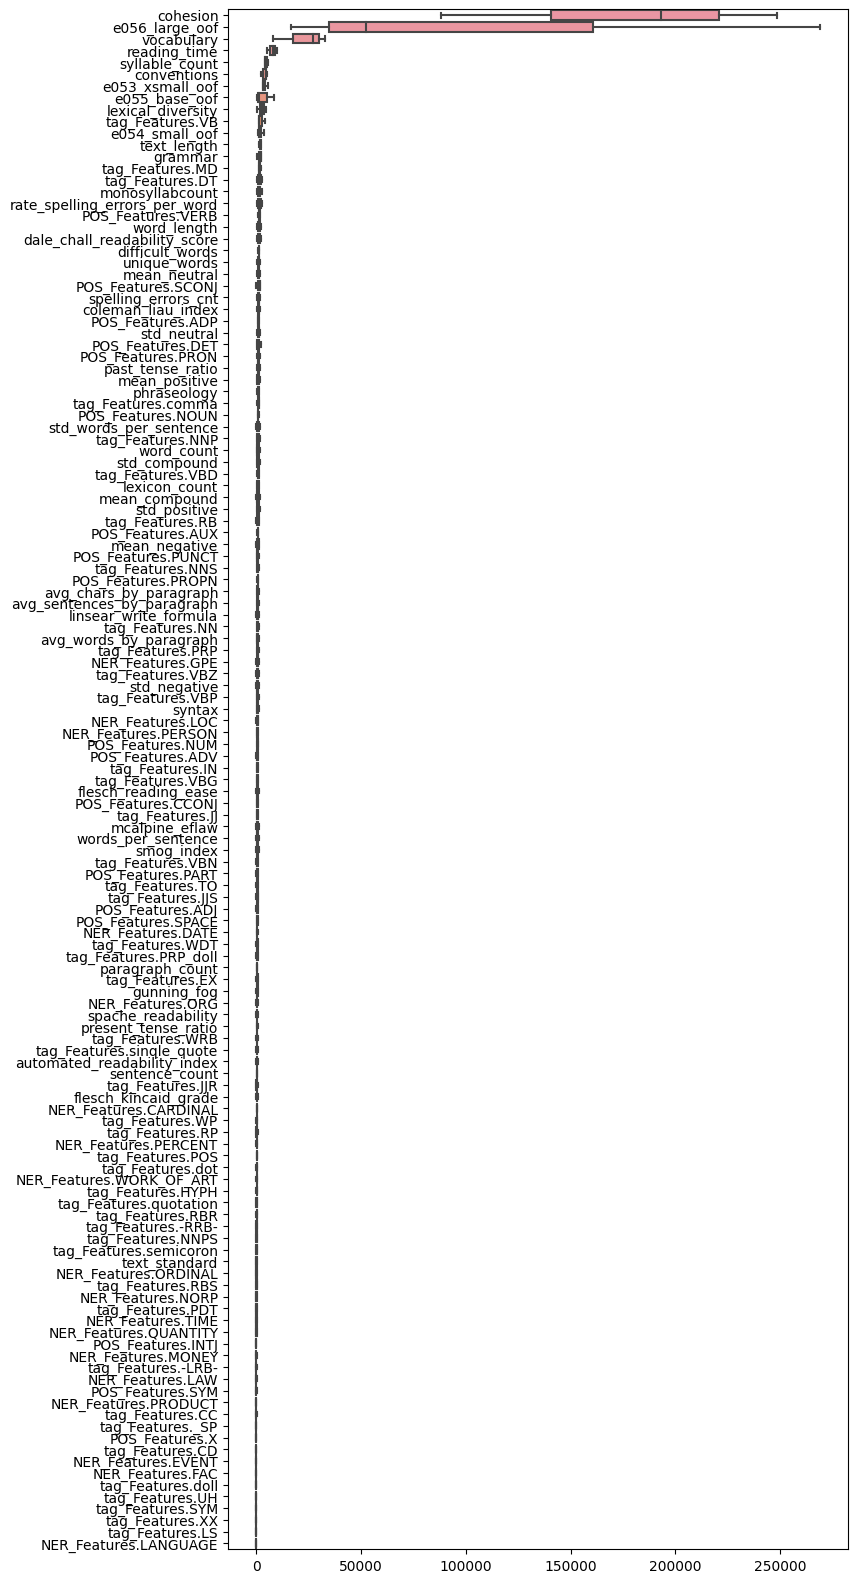

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量重要度を列にもつDataFrameを作成
feature_importances = [
    model.feature_importance(importance_type="gain") for _, model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=USE_COL)

# 表示する順番を指定、特徴量重要度の平均が大きい順に並ぶよう計算
order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

# 表示
# fold毎の特徴量重要度のばらつきを見るために、箱ひげ図を利用
plt.figure(figsize=(8, 20))
sns.boxplot(data=feature_importances_df, orient="h", order=order)
plt.savefig(f"{MODEL_OUTPUT_PATH}/feature_importance.png")

# CVの計算

In [92]:
cv_score = cohen_kappa_score(
    oof["score"],
    np.clip(oof["valid_pred"], 1, 6).round(),
    weights="quadratic",
)
print(f"OOF CV Score by round: {cv_score}")

OOF CV Score by round: 0.7994319293711503


In [93]:
# https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5#optimizedrounder
class OptimizedRounder:
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6

        ll = cohen_kappa_score(y, X_p, weights="quadratic")
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [1.5, 2.5, 3.5, 4.5, 5.5]
        self.coef_ = sp.optimize.minimize(
            loss_partial, initial_coef, method="nelder-mead"
        )

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6
        return X_p

    @property
    def coefficients(self):
        return self.coef_["x"]

In [94]:
optR = OptimizedRounder()
optR.fit(oof["valid_pred"], oof["score"])
print(optR.coefficients)

optimized_valid_pred = optR.predict(oof["valid_pred"], optR.coefficients)
np.save(f"{MODEL_OUTPUT_PATH}/opt_thr.npy", optR.coefficients)

cv_score = cohen_kappa_score(oof["score"], optimized_valid_pred, weights="quadratic")

print(f"OOF CV Score by NelderMead: {cv_score}")

# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

[1.71756207 2.53409747 3.39177149 4.23233654 4.93872488]
OOF CV Score by NelderMead: 0.8187249180348785


# 混同行列の計算

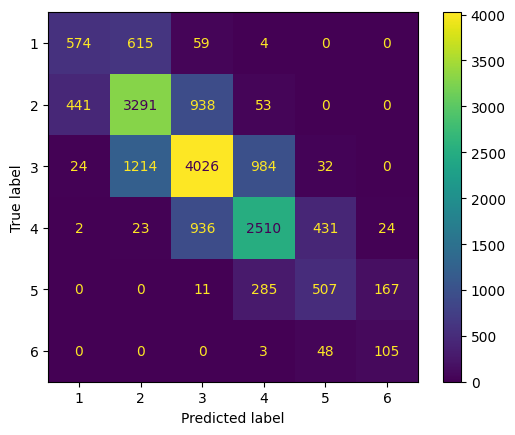

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    oof["score"],
    optimized_valid_pred,
    labels=[x for x in range(1, 7)],
)

draw_cm = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[x for x in range(1, 7)]
)

draw_cm.plot()
plt.savefig(f"{MODEL_OUTPUT_PATH}/confusion_matrix.png")
plt.show()

# Kaggleへのアップロード

In [78]:
if UPLOAD_DATA_TO_KAGGLE:
    import os
    import json

    from kaggle.api.kaggle_api_extended import KaggleApi

    def dataset_create_new(dataset_name: str, upload_dir: str):
        # if "_" in dataset_name:
        #     raise ValueError("datasetの名称に_の使用は禁止です")
        dataset_metadata = {}
        dataset_metadata["id"] = f"sinchir0/{dataset_name}"
        dataset_metadata["licenses"] = [{"name": "CC0-1.0"}]
        dataset_metadata["title"] = dataset_name
        with open(os.path.join(upload_dir, "dataset-metadata.json"), "w") as f:
            json.dump(dataset_metadata, f, indent=4)
        api = KaggleApi()
        api.authenticate()
        api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode="tar")

    print(f"Create Dataset name:{DATASET_NAME}, output_dir:{MODEL_OUTPUT_PATH}")
    dataset_create_new(dataset_name=DATASET_NAME, upload_dir=MODEL_OUTPUT_PATH)

Create Dataset name:e107-s-sl-g-p-optuna-lightgbm, output_dir:../../trained_models/e107-s-sl-g-p-optuna
Starting upload for file cv_score.txt



100%|██████████| 18.0/18.0 [00:00<00:00, 56.6B/s]


Upload successful: cv_score.txt (18B)
Starting upload for file model_1.pkl



  0%|          | 0.00/2.32M [00:00<?, ?B/s]
100%|██████████| 2.32M/2.32M [00:00<00:00, 6.18MB/s][A


Upload successful: model_1.pkl (2MB)
Starting upload for file feature_importance.png



100%|██████████| 228k/228k [00:00<00:00, 678kB/s]


Upload successful: feature_importance.png (228KB)
Starting upload for file model_2.pkl



  0%|          | 0.00/7.14M [00:00<?, ?B/s]
  3%|▎         | 224k/7.14M [00:00<00:03, 2.18MB/s]
100%|██████████| 7.14M/7.14M [00:00<00:00, 15.6MB/s]


Upload successful: model_2.pkl (7MB)
Starting upload for file confusion_matrix.png



100%|██████████| 32.4k/32.4k [00:00<00:00, 95.2kB/s]


Upload successful: confusion_matrix.png (32KB)
Starting upload for file opt_thr.npy



100%|██████████| 168/168 [00:00<00:00, 457B/s]


Upload successful: opt_thr.npy (168B)
Starting upload for file model_0.pkl



  0%|          | 0.00/679k [00:00<?, ?B/s]
100%|██████████| 679k/679k [00:00<00:00, 1.98MB/s]


Upload successful: model_0.pkl (679KB)


In [95]:
if WANDB:
    wandb.finish()

best_iteration,1065
